# Set up

In [24]:
from footbot.data import utils
import pandas as pd
import patsy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [6]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)

In [7]:
def r_squared(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return (1 - SS_res/(SS_tot + backend.epsilon()))

# Getting data

In [8]:
client = utils.set_up_bigquery(secrets_path='../secrets/service_account.json')

In [9]:
sql = \
'''
SELECT
  event,
  element,
  total_points,
  safe_web_name,
  element_type,
  cluster,
  team,
  value,
  total_points_per_minute_previous_season,
  goals_scored_per_minute_previous_season,
  assists_per_minute_previous_season,
  clean_sheets_per_minute_previous_season,
  goals_conceded_per_minute_previous_season,
  own_goals_per_minute_previous_season,
  penalties_saved_per_minute_previous_season,
  penalties_missed_per_minute_previous_season,
  yellow_cards_per_minute_previous_season,
  red_cards_per_minute_previous_season,
  saves_per_minute_previous_season,
  bonus_per_minute_previous_season,
  bps_per_minute_previous_season,
  opponent_team,
  was_home,
  was_sunday,
  was_weekday,
  was_late,
  was_early,
  rolling_avg_total_points_element,
  rolling_avg_minutes_element,
  rolling_avg_goals_scored_element,
  rolling_avg_assists_element,
  rolling_avg_clean_sheets_element,
  rolling_avg_goals_conceded_element,
  rolling_avg_own_goals_element,
  rolling_avg_penalties_saved_element,
  rolling_avg_penalties_missed_element,
  rolling_avg_yellow_cards_element,
  rolling_avg_red_cards_element,
  rolling_avg_saves_element,
  rolling_avg_bonus_element,
  rolling_avg_bps_element,
  rolling_avg_total_points_element_p1,
  rolling_avg_total_points_element_p2,
  rolling_avg_total_points_element_p3,
  rolling_avg_total_points_element_p4,
  rolling_avg_total_points_element_p5,
  rolling_avg_total_points_element_p10,
  rolling_avg_goals_scored_element_p1,
  rolling_avg_goals_scored_element_p2,
  rolling_avg_goals_scored_element_p3,
  rolling_avg_goals_scored_element_p4,
  rolling_avg_goals_scored_element_p5,
  rolling_avg_goals_scored_element_p10,
  rolling_avg_assists_element_p1,
  rolling_avg_assists_element_p2,
  rolling_avg_assists_element_p3,
  rolling_avg_assists_element_p4,
  rolling_avg_assists_element_p5,
  rolling_avg_assists_element_p10,
  rolling_avg_clean_sheets_element_p1,
  rolling_avg_clean_sheets_element_p2,
  rolling_avg_clean_sheets_element_p3,
  rolling_avg_clean_sheets_element_p4,
  rolling_avg_clean_sheets_element_p5,
  rolling_avg_clean_sheets_element_p10,
  rolling_avg_goals_conceded_element_p1,
  rolling_avg_goals_conceded_element_p2,
  rolling_avg_goals_conceded_element_p3,
  rolling_avg_goals_conceded_element_p4,
  rolling_avg_goals_conceded_element_p5,
  rolling_avg_goals_conceded_element_p10,
  rolling_avg_saves_element_p1,
  rolling_avg_saves_element_p2,
  rolling_avg_saves_element_p3,
  rolling_avg_saves_element_p4,
  rolling_avg_saves_element_p5,
  rolling_avg_saves_element_p10,
  rolling_avg_minutes_element_p1,
  rolling_avg_minutes_element_p2,
  rolling_avg_minutes_element_p3,
  rolling_avg_minutes_element_p4,
  rolling_avg_minutes_element_p5,
  rolling_avg_minutes_element_p10,
  expected_total_points_against_opponent_team_element_type,
  expected_minutes_against_opponent_team_element_type,
  expected_goals_scored_against_opponent_team_element_type,
  expected_assists_against_opponent_team_element_type,
  expected_clean_sheets_against_opponent_team_element_type,
  expected_goals_conceded_against_opponent_team_element_type,
  expected_own_goals_against_opponent_team_element_type,
  expected_penalties_saved_against_opponent_team_element_type,
  expected_penalties_missed_against_opponent_team_element_type,
  expected_yellow_cards_against_opponent_team_element_type,
  expected_red_cards_against_opponent_team_element_type,
  expected_saves_against_opponent_team_element_type,
  expected_bonus_against_opponent_team_element_type,
  expected_bps_against_opponent_team_element_type,
  rolling_avg_squad,
  rolling_avg_first_team,
  rolling_avg_vice_or_captain,
  rolling_avg_squad_p1,
  rolling_avg_first_team_p1,
  rolling_avg_vice_or_captain_p1
FROM
  `footbot-001.fpl.element_gameweeks_features_1819_v01`
'''

In [10]:
# get dataframe
df_all = client.query(sql).to_dataframe()

In [11]:
last_train_event = 25
last_test_event = 38
element_filter_field = 'rolling_avg_total_points_element'
element_filter_value = 2

In [12]:
# filter out elements
element_filter_df = df_all[df_all['event'] == last_train_event + 1]

element_filter = element_filter_df[
    element_filter_df[element_filter_field] > element_filter_value
]['element'].values

df = df_all[
    (df_all['event'] <= last_test_event)
    & (df_all['element'].isin(element_filter))
]

# impute missing values by element type
df = pd.concat([
    df[df['element_type'] == i].fillna(
        df[
            (df['event'] <= last_train_event)
            & (df['element_type'] == i)
        ].mean()).fillna(0)
    for i in range(1, 5)
])

In [13]:
df = df[df['element_type'] != 1]

# Modelling data

## Splitting data

In [14]:
test_fold = [-1 if i <= last_train_event else 0 for i in df['event']]
ps = PredefinedSplit(test_fold)

In [15]:
for train_index, test_index in ps.split():
    df_train, df_test = \
    df.copy().iloc[train_index], df.copy().iloc[test_index]

## Scaling data

In [16]:
list(df.columns)

['event',
 'element',
 'total_points',
 'safe_web_name',
 'element_type',
 'cluster',
 'team',
 'value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'opponent_team',
 'was_home',
 'was_sunday',
 'was_weekday',
 'was_late',
 'was_early',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_a

In [17]:
scaled_feature_cols = [
    i for i in df.columns if i not in [
        'total_points',
        'goals_scored',
        'assists',
        'clean_sheets',
        'goals_conceded',
        'saves',
        'minutes',
        'element',
        'safe_web_name',
        'element_type',
        'cluster',
        'team',
        'event',
        'fixture',
        'opponent_team',
        'was_home',
        'was_sunday',
        'was_weekday',
        'was_late',
        'was_early',
    ]
]

scaled_feature_cols

['value',
 'total_points_per_minute_previous_season',
 'goals_scored_per_minute_previous_season',
 'assists_per_minute_previous_season',
 'clean_sheets_per_minute_previous_season',
 'goals_conceded_per_minute_previous_season',
 'own_goals_per_minute_previous_season',
 'penalties_saved_per_minute_previous_season',
 'penalties_missed_per_minute_previous_season',
 'yellow_cards_per_minute_previous_season',
 'red_cards_per_minute_previous_season',
 'saves_per_minute_previous_season',
 'bonus_per_minute_previous_season',
 'bps_per_minute_previous_season',
 'rolling_avg_total_points_element',
 'rolling_avg_minutes_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_assists_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_own_goals_element',
 'rolling_avg_penalties_saved_element',
 'rolling_avg_penalties_missed_element',
 'rolling_avg_yellow_cards_element',
 'rolling_avg_red_cards_element',
 'rolling_avg_saves_element',
 'rolling_avg

In [18]:
scaled_df_train = df_train.copy()
scaled_df_test = df_test.copy()
scaled_df = df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

df_train[scaled_feature_cols] = scaled_df_train
df_test[scaled_feature_cols] = scaled_df_test
df[scaled_feature_cols] = scaled_df

## Building model

In [59]:
class FullRankOneHot(object):
    def __init__(self, reference=0):
        self.reference = reference

    # Called to generate a full-rank encoding
    def code_with_intercept(self, levels):
        return patsy.ContrastMatrix(np.eye(len(levels)),
                              ["[%s]" % (level,) for level in levels])

    # Called to generate a non-full-rank encoding. But we don't care,
    # we do what we want, and return a full-rank encoding anyway.
    # Take that, patsy.
    def code_without_intercept(self, levels):
        return self.code_with_intercept(levels)

In [60]:
formula = \
'''
total_points
~ C(element_type, FullRankOneHot)
+ C(opponent_team, FullRankOneHot)
+ C(team, FullRankOneHot)
+ C(was_home)
+ C(was_sunday)
+ C(was_weekday)
+ C(was_late)
+ C(was_early)
+
'''  + ' + '.join(scaled_feature_cols)

In [61]:
print(formula)


total_points
~ C(element_type, FullRankOneHot)
+ C(opponent_team, FullRankOneHot)
+ C(team, FullRankOneHot)
+ C(was_home)
+ C(was_sunday)
+ C(was_weekday)
+ C(was_late)
+ C(was_early)
+
value + total_points_per_minute_previous_season + goals_scored_per_minute_previous_season + assists_per_minute_previous_season + clean_sheets_per_minute_previous_season + goals_conceded_per_minute_previous_season + own_goals_per_minute_previous_season + penalties_saved_per_minute_previous_season + penalties_missed_per_minute_previous_season + yellow_cards_per_minute_previous_season + red_cards_per_minute_previous_season + saves_per_minute_previous_season + bonus_per_minute_previous_season + bps_per_minute_previous_season + rolling_avg_total_points_element + rolling_avg_minutes_element + rolling_avg_goals_scored_element + rolling_avg_assists_element + rolling_avg_clean_sheets_element + rolling_avg_goals_conceded_element + rolling_avg_own_goals_element + rolling_avg_penalties_saved_element + rolling_avg_

In [62]:
y, X = patsy.dmatrices(formula, df, return_type='matrix')

In [63]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [212]:
ls_estimator = LinearRegression()

ls_selector = RFECV(
    ls_estimator,
    step=1,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

ls_selector.fit(
    np.asarray(X),
    np.asarray(y).ravel()
)

Fitting estimator with 136 features.
Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.
Fitting estimator with 132 features.
Fitting estimator with 131 features.
Fitting estimator with 130 features.
Fitting estimator with 129 features.
Fitting estimator with 128 features.
Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=-1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [213]:
sum(ls_selector.support_)

84

In [214]:
-ls_selector.grid_scores_[-1]

10.594816390126127

In [215]:
ls_sel_cols = list(pd.Series(X.design_info.column_names)[ls_selector.support_])
ls_sel_cols

['C(element_type)[T.4]',
 'C(opponent_team)[T.bournemouth]',
 'C(opponent_team)[T.brighton]',
 'C(opponent_team)[T.burnley]',
 'C(opponent_team)[T.cardiff]',
 'C(opponent_team)[T.chelsea]',
 'C(opponent_team)[T.crystal palace]',
 'C(opponent_team)[T.everton]',
 'C(opponent_team)[T.fulham]',
 'C(opponent_team)[T.huddersfield]',
 'C(opponent_team)[T.leicester]',
 'C(opponent_team)[T.liverpool]',
 'C(opponent_team)[T.man city]',
 'C(opponent_team)[T.man utd]',
 'C(opponent_team)[T.newcastle]',
 'C(opponent_team)[T.southampton]',
 'C(opponent_team)[T.watford]',
 'C(opponent_team)[T.west ham]',
 'C(opponent_team)[T.wolves]',
 'C(team)[T.bournemouth]',
 'C(team)[T.brighton]',
 'C(team)[T.chelsea]',
 'C(team)[T.crystal palace]',
 'C(team)[T.everton]',
 'C(team)[T.fulham]',
 'C(team)[T.huddersfield]',
 'C(team)[T.liverpool]',
 'C(team)[T.man city]',
 'C(team)[T.man utd]',
 'C(team)[T.newcastle]',
 'C(team)[T.southampton]',
 'C(team)[T.spurs]',
 'C(team)[T.watford]',
 'C(team)[T.west ham]',
 'C

In [216]:
ls_X_sel = X[:,ls_selector.support_]
ls_X_train_sel = X_train[:,ls_selector.support_]
ls_X_test_sel = X_test[:,ls_selector.support_]

In [219]:
ls_estimator.fit(ls_X_train_sel, y_train)
pd.DataFrame(
    list(zip(ls_sel_cols, list(ls_estimator.coef_[0]))),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False)

,feature,weight
53,rolling_avg_penalties_saved_element,3.201800e+11
8,C(opponent_team)[T.fulham],1.464609e+00
4,C(opponent_team)[T.cardiff],1.427400e+00
9,C(opponent_team)[T.huddersfield],1.415886e+00
3,C(opponent_team)[T.burnley],1.299623e+00
15,C(opponent_team)[T.southampton],1.001429e+00
17,C(opponent_team)[T.west ham],9.778396e-01
19,C(team)[T.bournemouth],8.965709e-01
1,C(opponent_team)[T.bournemouth],8.673833e-01
26,C(team)[T.liverpool],8.654340e-01


## Tuning model

### GP tuner

In [36]:
space = [
    Real(1, 500, 'uniform', name='hidden_nodes'),
    Integer(0, 5, name='hidden_layers'),
    Categorical(['relu', 'linear', 'sigmoid'], name='activation'),
    Integer(1, 5, name='weight_constraint'),
    Real(0.01, 0.9, 'uniform', name='dropout_rate'),
    Real(10**-5, 10**0, 'log-uniform', name='learning_rate'),
    Real(10, 1000, 'log-uniform', name='batch_size'),
]

In [37]:
def create_model(hidden_nodes,
                 hidden_layers,
                 activation,
                 weight_constraint,
                 dropout_rate,
                 learning_rate
                ):
    
    model = Sequential()
    model.add(Dense(hidden_nodes,
                    input_shape=(X_train.shape[1],),
                    activation=activation,
                    kernel_constraint=MaxNorm(weight_constraint)))
    model.add(Dropout(dropout_rate))

    for i in range(0, hidden_layers):
        model.add(Dense(hidden_nodes, activation=activation, kernel_constraint=MaxNorm(weight_constraint)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[r_squared])
    
    return model

In [38]:
@use_named_args(space)
def objective(hidden_nodes,
              hidden_layers,
              activation,
              weight_constraint,
              dropout_rate,
              learning_rate,
              batch_size
             ):
    
    v = str(np.random.randint(1, 1000, size=1)[0])
    file_name = 'models/neural_net_model_checkpoint_' + v + '.h5'
    
    model = create_model(
        hidden_nodes=int(hidden_nodes),
        hidden_layers=int(hidden_layers),
        activation=activation,
        weight_constraint=int(weight_constraint),
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
    )
    
    es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=5,
        min_delta=0,
        verbose=1
    )

    mc = ModelCheckpoint(
        file_name,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=int(batch_size),
        validation_data=(X_test, y_test),
        callbacks=[es, mc]
    )

    model = load_model(file_name, custom_objects={'r_squared': r_squared})
    
    y_pred = model.predict(X_test).flatten()
    test_loss = mean_squared_error(y_test, y_pred)

    del model
    backend.clear_session()
    
    return test_loss

In [ ]:
res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    res_gp = gp_minimize(
        objective,
        space,
        n_calls=100,
        n_jobs=-1,
        verbose=2
    )
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
3770/3852 [============================>.] - ETA: 0s - loss: 21.9768 - r_squared: -1.0018
Epoch 00001: val_loss improved from inf to 15.00247, saving model to models/neural_net_model_checkpoint_575.h5
3852/3852 [==============================] - 2s 455us/sample - loss: 21.8790 - r_squared: -1.0125 - val_loss: 15.0025 - val_r_squared: -0.3759
Epoch 2/100
3536/3852 [==========================>...] - ETA: 0s - loss: 17.6326 - r_squared: -0.6041
Epoch 00002: val_loss improved from 15.00247 to 12.80381, saving model to models/neural_net_model_checkpoint_575.h5
3852/3852 [==============================] - 0s 128us/sample - loss: 17.6064 - r_squared: -0.6005 - val_loss: 12.8038 - val_r_squared: -0.1468
Epoch 3/100
3536/3852 [==========================>...] - ETA: 0s - loss: 15.7754 - r_squared: -0.4208
Epoch 00003: val_loss improved from 12.80381 t

3588/3852 [==========================>...] - ETA: 0s - loss: 12.0773 - r_squared: -0.0794
Epoch 00025: val_loss did not improve from 10.78752
3852/3852 [==============================] - 0s 117us/sample - loss: 11.9868 - r_squared: -2047587.2500 - val_loss: 10.7998 - val_r_squared: -0.0416
Epoch 00025: early stopping
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.4410
Function value obtained: 10.7875
Current minimum: 10.7875
Iteration No: 2 started. Evaluating function at random point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
3360/3852 [=========================>....] - ETA: 0s - loss: 16.0049 - r_squared: -0.3310
Epoch 00001: val_loss improved from inf to 12.53569, saving model to models/neural_net_model_checkpoint_734.h5
3852/3852 [==============================] - 2s 432us/sample - loss: 15.6829 - r_squared: -0.3656 - val_loss: 12.5357 - val_r_squared: -0.0378
Epoch 2/100
3360/3852 [=========================>....] - ETA: 0s - loss: 12.8108 

Epoch 24/100
3360/3852 [=========================>....] - ETA: 0s - loss: 11.2562 - r_squared: 0.0733
Epoch 00024: val_loss did not improve from 10.73891
3852/3852 [==============================] - 0s 29us/sample - loss: 10.9362 - r_squared: 0.0568 - val_loss: 10.8690 - val_r_squared: 0.0933
Epoch 25/100
3840/3852 [============================>.] - ETA: 0s - loss: 10.9032 - r_squared: 0.0725
Epoch 00025: val_loss did not improve from 10.73891
3852/3852 [==============================] - 0s 25us/sample - loss: 10.9495 - r_squared: 0.0679 - val_loss: 11.3351 - val_r_squared: 0.0543
Epoch 26/100
3360/3852 [=========================>....] - ETA: 0s - loss: 11.2331 - r_squared: 0.0416
Epoch 00026: val_loss did not improve from 10.73891
3852/3852 [==============================] - 0s 26us/sample - loss: 11.1839 - r_squared: -0.1021 - val_loss: 10.9352 - val_r_squared: 0.0916
Epoch 27/100
3840/3852 [============================>.] - ETA: 0s - loss: 11.3608 - r_squared: 0.0413
Epoch 00027: va

Epoch 20/100
3440/3852 [=========================>....] - ETA: 0s - loss: 14.2514 - r_squared: -0.3141
Epoch 00020: val_loss improved from 13.77011 to 13.50611, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 172us/sample - loss: 14.6152 - r_squared: -0.3170 - val_loss: 13.5061 - val_r_squared: -0.2426
Epoch 21/100
3760/3852 [============================>.] - ETA: 0s - loss: 14.5180 - r_squared: -0.3006
Epoch 00021: val_loss improved from 13.50611 to 13.28713, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 177us/sample - loss: 14.5821 - r_squared: -0.3012 - val_loss: 13.2871 - val_r_squared: -0.2271
Epoch 22/100
3520/3852 [==========================>...] - ETA: 0s - loss: 14.2038 - r_squared: -0.2674
Epoch 00022: val_loss improved from 13.28713 to 13.08494, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 170us/sam

3852/3852 [==============================] - 1s 183us/sample - loss: 13.2216 - r_squared: -0.2311 - val_loss: 11.9884 - val_r_squared: -0.1569
Epoch 43/100
3500/3852 [==========================>...] - ETA: 0s - loss: 13.4765 - r_squared: -0.2153
Epoch 00043: val_loss improved from 11.98844 to 11.96625, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 171us/sample - loss: 13.3503 - r_squared: -0.2254 - val_loss: 11.9662 - val_r_squared: -0.1557
Epoch 44/100
3600/3852 [===========================>..] - ETA: 0s - loss: 13.0837 - r_squared: -0.1931
Epoch 00044: val_loss improved from 11.96625 to 11.95400, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 163us/sample - loss: 13.1436 - r_squared: -0.1954 - val_loss: 11.9540 - val_r_squared: -0.1552
Epoch 45/100
3600/3852 [===========================>..] - ETA: 0s - loss: 13.9310 - r_squared: -0.2812
Epoch 00045: val_loss did not 

3852/3852 [==============================] - 1s 182us/sample - loss: 12.7272 - r_squared: -0.2025 - val_loss: 11.7855 - val_r_squared: -0.1449
Epoch 67/100
3760/3852 [============================>.] - ETA: 0s - loss: 12.9858 - r_squared: -0.1861
Epoch 00067: val_loss improved from 11.78549 to 11.78458, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 180us/sample - loss: 12.9782 - r_squared: -0.1838 - val_loss: 11.7846 - val_r_squared: -0.1447
Epoch 68/100
3460/3852 [=========================>....] - ETA: 0s - loss: 12.7677 - r_squared: -0.1525
Epoch 00068: val_loss improved from 11.78458 to 11.78043, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 172us/sample - loss: 12.8110 - r_squared: -0.1565 - val_loss: 11.7804 - val_r_squared: -0.1445
Epoch 69/100
3780/3852 [============================>.] - ETA: 0s - loss: 12.7124 - r_squared: -0.1770
Epoch 00069: val_loss improved

Epoch 3/100
2996/3852 [======================>.......] - ETA: 0s - loss: 24.7793 - r_squared: -1.1416
Epoch 00003: val_loss improved from 18.45379 to 17.96861, saving model to models/neural_net_model_checkpoint_933.h5
3852/3852 [==============================] - 0s 37us/sample - loss: 24.5708 - r_squared: -1.1286 - val_loss: 17.9686 - val_r_squared: -0.5218
Epoch 4/100
2782/3852 [====================>.........] - ETA: 0s - loss: 24.3205 - r_squared: -1.0968
Epoch 00004: val_loss improved from 17.96861 to 17.50221, saving model to models/neural_net_model_checkpoint_933.h5
3852/3852 [==============================] - 0s 37us/sample - loss: 23.8675 - r_squared: -1.0565 - val_loss: 17.5022 - val_r_squared: -0.4804
Epoch 5/100
2675/3852 [===================>..........] - ETA: 0s - loss: 22.6865 - r_squared: -0.9917
Epoch 00005: val_loss improved from 17.50221 to 17.11638, saving model to models/neural_net_model_checkpoint_933.h5
3852/3852 [==============================] - 0s 35us/sample - 

Epoch 26/100
2996/3852 [======================>.......] - ETA: 0s - loss: 16.6203 - r_squared: -0.4154
Epoch 00026: val_loss improved from 12.58578 to 12.47595, saving model to models/neural_net_model_checkpoint_933.h5
3852/3852 [==============================] - 0s 36us/sample - loss: 16.2706 - r_squared: -0.3935 - val_loss: 12.4760 - val_r_squared: -0.0470
Epoch 27/100
2889/3852 [=====================>........] - ETA: 0s - loss: 15.8792 - r_squared: -0.4185
Epoch 00027: val_loss improved from 12.47595 to 12.38697, saving model to models/neural_net_model_checkpoint_933.h5
3852/3852 [==============================] - 0s 36us/sample - loss: 16.2199 - r_squared: -0.3922 - val_loss: 12.3870 - val_r_squared: -0.0395
Epoch 28/100
2461/3852 [==================>...........] - ETA: 0s - loss: 16.4418 - r_squared: -0.4151
Epoch 00028: val_loss improved from 12.38697 to 12.27963, saving model to models/neural_net_model_checkpoint_933.h5
3852/3852 [==============================] - 0s 37us/sample

Epoch 49/100
2889/3852 [=====================>........] - ETA: 0s - loss: 14.6299 - r_squared: -0.3114
Epoch 00049: val_loss did not improve from 11.35693
3852/3852 [==============================] - 0s 30us/sample - loss: 15.1267 - r_squared: -0.2981 - val_loss: 11.3846 - val_r_squared: 0.0387
Epoch 50/100
2889/3852 [=====================>........] - ETA: 0s - loss: 14.5690 - r_squared: -0.2931
Epoch 00050: val_loss improved from 11.35693 to 11.34792, saving model to models/neural_net_model_checkpoint_933.h5
3852/3852 [==============================] - 0s 37us/sample - loss: 15.0497 - r_squared: -0.2916 - val_loss: 11.3479 - val_r_squared: 0.0416
Epoch 51/100
2782/3852 [====================>.........] - ETA: 0s - loss: 13.9286 - r_squared: -0.2053
Epoch 00051: val_loss improved from 11.34792 to 11.30199, saving model to models/neural_net_model_checkpoint_933.h5
3852/3852 [==============================] - 0s 39us/sample - loss: 14.1628 - r_squared: -0.2175 - val_loss: 11.3020 - val_r_

Train on 3852 samples, validate on 2019 samples
Epoch 1/100
3160/3852 [=======================>......] - ETA: 0s - loss: 712249.9769 - r_squared: -74029.3359  
Epoch 00001: val_loss improved from inf to 11768.33922, saving model to models/neural_net_model_checkpoint_95.h5
3852/3852 [==============================] - 1s 280us/sample - loss: 588544.8968 - r_squared: -60755.4844 - val_loss: 11768.3392 - val_r_squared: -1015.6091
Epoch 2/100
3476/3852 [==========================>...] - ETA: 0s - loss: 4289.5957 - r_squared: -373.9590
Epoch 00002: val_loss improved from 11768.33922 to 3265.15427, saving model to models/neural_net_model_checkpoint_95.h5
3852/3852 [==============================] - 0s 50us/sample - loss: 4509.4234 - r_squared: -411.4565 - val_loss: 3265.1543 - val_r_squared: -277.9098
Epoch 3/100
3555/3852 [==========================>...] - ETA: 0s - loss: 1224.7014 - r_squared: -98.3286
Epoch 00003: val_loss improved from 3265.15427 to 194.98637, saving model to models/neura

3542/3852 [==========================>...] - ETA: 0s - loss: 102.8872 - r_squared: -9.5690 
Epoch 00007: val_loss did not improve from 19.31027
3852/3852 [==============================] - 1s 205us/sample - loss: 97.2632 - r_squared: -8.9279 - val_loss: 24.3631 - val_r_squared: -1.1457
Epoch 8/100
3588/3852 [==========================>...] - ETA: 0s - loss: 35.3244 - r_squared: -2.2971
Epoch 00008: val_loss improved from 19.31027 to 17.44573, saving model to models/neural_net_model_checkpoint_415.h5
3852/3852 [==============================] - 1s 202us/sample - loss: 34.7962 - r_squared: -2.2567 - val_loss: 17.4457 - val_r_squared: -0.5008
Epoch 9/100
3588/3852 [==========================>...] - ETA: 0s - loss: 28.6774 - r_squared: -1.5831
Epoch 00009: val_loss did not improve from 17.44573
3852/3852 [==============================] - 1s 205us/sample - loss: 28.5939 - r_squared: -1.5681 - val_loss: 18.1329 - val_r_squared: -0.5668
Epoch 10/100
3772/3852 [============================>.]

Epoch 5/100
3700/3852 [===========================>..] - ETA: 0s - loss: 10.7794 - r_squared: 0.0530
Epoch 00005: val_loss did not improve from 11.15740
3852/3852 [==============================] - 1s 177us/sample - loss: 10.8131 - r_squared: 0.0386 - val_loss: 11.3284 - val_r_squared: -0.0725
Epoch 6/100
3700/3852 [===========================>..] - ETA: 0s - loss: 10.9251 - r_squared: 0.0146
Epoch 00006: val_loss did not improve from 11.15740
3852/3852 [==============================] - 1s 188us/sample - loss: 11.0547 - r_squared: 0.0171 - val_loss: 11.4685 - val_r_squared: -0.0838
Epoch 7/100
3700/3852 [===========================>..] - ETA: 0s - loss: 10.7036 - r_squared: 0.0576
Epoch 00007: val_loss did not improve from 11.15740
3852/3852 [==============================] - 1s 183us/sample - loss: 10.7849 - r_squared: 0.0142 - val_loss: 11.5750 - val_r_squared: -0.1000
Epoch 8/100
3500/3852 [==========================>...] - ETA: 0s - loss: 10.8889 - r_squared: 0.0490
Epoch 00008: v

3650/3852 [===========================>..] - ETA: 0s - loss: 12.5519 - r_squared: -0.1305
Epoch 00020: val_loss did not improve from 10.80454
3852/3852 [==============================] - 0s 118us/sample - loss: 12.5039 - r_squared: -0.1283 - val_loss: 10.8050 - val_r_squared: -0.0476
Epoch 21/100
3775/3852 [============================>.] - ETA: 0s - loss: 12.1682 - r_squared: -0.1368
Epoch 00021: val_loss improved from 10.80454 to 10.75758, saving model to models/neural_net_model_checkpoint_887.h5
3852/3852 [==============================] - 0s 124us/sample - loss: 12.1607 - r_squared: -0.1509 - val_loss: 10.7576 - val_r_squared: -0.0422
Epoch 22/100
3400/3852 [=========================>....] - ETA: 0s - loss: 12.1494 - r_squared: -0.1131
Epoch 00022: val_loss improved from 10.75758 to 10.74923, saving model to models/neural_net_model_checkpoint_887.h5
3852/3852 [==============================] - 1s 133us/sample - loss: 12.1544 - r_squared: -167659.0938 - val_loss: 10.7492 - val_r_squ

3852/3852 [==============================] - 0s 127us/sample - loss: 15.0049 - r_squared: -0.2696 - val_loss: 14.3757 - val_r_squared: -0.1954
Epoch 4/100
3537/3852 [==========================>...] - ETA: 0s - loss: 13.4600 - r_squared: -0.1221
Epoch 00004: val_loss improved from 14.37573 to 12.77761, saving model to models/neural_net_model_checkpoint_232.h5
3852/3852 [==============================] - 0s 127us/sample - loss: 13.2058 - r_squared: -0.1147 - val_loss: 12.7776 - val_r_squared: -0.0896
Epoch 5/100
3537/3852 [==========================>...] - ETA: 0s - loss: 12.7180 - r_squared: -0.0690
Epoch 00005: val_loss improved from 12.77761 to 12.25296, saving model to models/neural_net_model_checkpoint_232.h5
3852/3852 [==============================] - 0s 120us/sample - loss: 12.5671 - r_squared: -0.0642 - val_loss: 12.2530 - val_r_squared: -0.0674
Epoch 6/100
3537/3852 [==========================>...] - ETA: 0s - loss: 12.6688 - r_squared: -0.0761
Epoch 00006: val_loss did not imp

3537/3852 [==========================>...] - ETA: 0s - loss: 11.3548 - r_squared: 0.0191
Epoch 00028: val_loss did not improve from 11.56072
3852/3852 [==============================] - 0s 108us/sample - loss: 11.4533 - r_squared: 0.0267 - val_loss: 11.5936 - val_r_squared: 0.0267
Epoch 29/100
3537/3852 [==========================>...] - ETA: 0s - loss: 11.3291 - r_squared: 0.0309
Epoch 00029: val_loss did not improve from 11.56072
3852/3852 [==============================] - 0s 107us/sample - loss: 11.4482 - r_squared: 0.0306 - val_loss: 11.5916 - val_r_squared: 0.0282
Epoch 30/100
3537/3852 [==========================>...] - ETA: 0s - loss: 11.6328 - r_squared: 0.0182
Epoch 00030: val_loss did not improve from 11.56072
3852/3852 [==============================] - 0s 101us/sample - loss: 11.5263 - r_squared: 0.0252 - val_loss: 11.5699 - val_r_squared: 0.0311
Epoch 31/100
3537/3852 [==========================>...] - ETA: 0s - loss: 11.3502 - r_squared: 0.0388
Epoch 00031: val_loss impr

Epoch 53/100
3537/3852 [==========================>...] - ETA: 0s - loss: 10.6582 - r_squared: 0.0872
Epoch 00053: val_loss did not improve from 11.10286
3852/3852 [==============================] - 0s 100us/sample - loss: 10.7848 - r_squared: 0.0858 - val_loss: 11.1157 - val_r_squared: 0.0800
Epoch 54/100
3537/3852 [==========================>...] - ETA: 0s - loss: 10.6135 - r_squared: 0.0924
Epoch 00054: val_loss did not improve from 11.10286
3852/3852 [==============================] - 0s 99us/sample - loss: 10.6794 - r_squared: 0.0952 - val_loss: 11.1743 - val_r_squared: 0.0746
Epoch 55/100
3537/3852 [==========================>...] - ETA: 0s - loss: 10.6459 - r_squared: 0.0981
Epoch 00055: val_loss improved from 11.10286 to 11.08653, saving model to models/neural_net_model_checkpoint_232.h5
3852/3852 [==============================] - 0s 123us/sample - loss: 10.6308 - r_squared: 0.0993 - val_loss: 11.0865 - val_r_squared: 0.0825
Epoch 56/100
3537/3852 [==========================>.

3852/3852 [==============================] - 1s 139us/sample - loss: 21.9504 - r_squared: -0.9797 - val_loss: 20.0163 - val_r_squared: -0.8514
Epoch 6/100
3525/3852 [==========================>...] - ETA: 0s - loss: 21.8187 - r_squared: -0.9541
Epoch 00006: val_loss improved from 20.01628 to 20.00776, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 133us/sample - loss: 21.9407 - r_squared: -0.9878 - val_loss: 20.0078 - val_r_squared: -0.8504
Epoch 7/100
3725/3852 [============================>.] - ETA: 0s - loss: 21.8941 - r_squared: -0.9797
Epoch 00007: val_loss improved from 20.00776 to 19.99926, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 130us/sample - loss: 21.9311 - r_squared: -1.0080 - val_loss: 19.9993 - val_r_squared: -0.8495
Epoch 8/100
3650/3852 [===========================>..] - ETA: 0s - loss: 21.7137 - r_squared: -0.9770
Epoch 00008: val_loss improved fr

3500/3852 [==========================>...] - ETA: 0s - loss: 21.3351 - r_squared: -0.9696
Epoch 00028: val_loss improved from 19.83059 to 19.82224, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 134us/sample - loss: 21.7305 - r_squared: -0.9918 - val_loss: 19.8222 - val_r_squared: -0.8291
Epoch 29/100
3475/3852 [==========================>...] - ETA: 0s - loss: 21.7843 - r_squared: -0.9377
Epoch 00029: val_loss improved from 19.82224 to 19.81384, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 135us/sample - loss: 21.7211 - r_squared: -0.9428 - val_loss: 19.8138 - val_r_squared: -0.8282
Epoch 30/100
3725/3852 [============================>.] - ETA: 0s - loss: 21.8568 - r_squared: -0.9517
Epoch 00030: val_loss improved from 19.81384 to 19.80548, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 0s 130us/sample - loss: 2

Epoch 51/100
3450/3852 [=========================>....] - ETA: 0s - loss: 21.0652 - r_squared: -0.9435
Epoch 00051: val_loss improved from 19.63917 to 19.63093, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 138us/sample - loss: 21.5136 - r_squared: -0.9765 - val_loss: 19.6309 - val_r_squared: -0.8072
Epoch 52/100
3525/3852 [==========================>...] - ETA: 0s - loss: 21.3144 - r_squared: -0.9571
Epoch 00052: val_loss improved from 19.63093 to 19.62265, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 134us/sample - loss: 21.5042 - r_squared: -0.9556 - val_loss: 19.6227 - val_r_squared: -0.8063
Epoch 53/100
3325/3852 [========================>.....] - ETA: 0s - loss: 20.9799 - r_squared: -0.9494
Epoch 00053: val_loss improved from 19.62265 to 19.61439, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 140us/sam

3852/3852 [==============================] - 0s 126us/sample - loss: 21.3083 - r_squared: -0.9060 - val_loss: 19.4502 - val_r_squared: -0.7866
Epoch 74/100
3575/3852 [==========================>...] - ETA: 0s - loss: 21.1928 - r_squared: -0.9150
Epoch 00074: val_loss improved from 19.45018 to 19.44200, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 134us/sample - loss: 21.2990 - r_squared: -0.9212 - val_loss: 19.4420 - val_r_squared: -0.7857
Epoch 75/100
3550/3852 [==========================>...] - ETA: 0s - loss: 21.2970 - r_squared: -0.9052
Epoch 00075: val_loss improved from 19.44200 to 19.43386, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 135us/sample - loss: 21.2897 - r_squared: -1.9611 - val_loss: 19.4339 - val_r_squared: -0.7848
Epoch 76/100
3275/3852 [========================>.....] - ETA: 0s - loss: 21.6271 - r_squared: -0.9105
Epoch 00076: val_loss improved

3625/3852 [===========================>..] - ETA: 0s - loss: 20.8918 - r_squared: -0.8849
Epoch 00096: val_loss improved from 19.27187 to 19.26375, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 130us/sample - loss: 21.0961 - r_squared: -0.8908 - val_loss: 19.2637 - val_r_squared: -0.7655
Epoch 97/100
3650/3852 [===========================>..] - ETA: 0s - loss: 21.1385 - r_squared: -0.8914
Epoch 00097: val_loss improved from 19.26375 to 19.25562, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 132us/sample - loss: 21.0869 - r_squared: -0.9342 - val_loss: 19.2556 - val_r_squared: -0.7645
Epoch 98/100
3625/3852 [===========================>..] - ETA: 0s - loss: 20.9644 - r_squared: -0.8949
Epoch 00098: val_loss improved from 19.25562 to 19.24761, saving model to models/neural_net_model_checkpoint_198.h5
3852/3852 [==============================] - 1s 131us/sample - loss: 2

Epoch 18/100
3780/3852 [============================>.] - ETA: 0s - loss: 14.6563 - r_squared: -0.3482
Epoch 00018: val_loss improved from 13.01673 to 12.90989, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 179us/sample - loss: 14.6478 - r_squared: -0.3433 - val_loss: 12.9099 - val_r_squared: -0.2942
Epoch 19/100
3474/3852 [==========================>...] - ETA: 0s - loss: 13.9214 - r_squared: -0.2956
Epoch 00019: val_loss improved from 12.90989 to 12.79074, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 172us/sample - loss: 14.0501 - r_squared: -0.2954 - val_loss: 12.7907 - val_r_squared: -0.2871
Epoch 20/100
3600/3852 [===========================>..] - ETA: 0s - loss: 14.1735 - r_squared: -0.3434
Epoch 00020: val_loss improved from 12.79074 to 12.72505, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 169us/sam

Epoch 41/100
3762/3852 [============================>.] - ETA: 0s - loss: 12.9910 - r_squared: -0.2194
Epoch 00041: val_loss improved from 12.08390 to 12.03697, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 160us/sample - loss: 13.0389 - r_squared: -0.2225 - val_loss: 12.0370 - val_r_squared: -0.2085
Epoch 42/100
3744/3852 [============================>.] - ETA: 0s - loss: 12.8429 - r_squared: -0.2123
Epoch 00042: val_loss improved from 12.03697 to 12.00877, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 181us/sample - loss: 12.8935 - r_squared: -0.2132 - val_loss: 12.0088 - val_r_squared: -0.2072
Epoch 43/100
3474/3852 [==========================>...] - ETA: 0s - loss: 13.1586 - r_squared: -0.2485
Epoch 00043: val_loss improved from 12.00877 to 12.00702, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 171us/sam

Epoch 65/100
3528/3852 [==========================>...] - ETA: 0s - loss: 12.7712 - r_squared: -0.1503
Epoch 00065: val_loss improved from 11.77536 to 11.75906, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 173us/sample - loss: 12.5959 - r_squared: -0.1645 - val_loss: 11.7591 - val_r_squared: -0.1862
Epoch 66/100
3780/3852 [============================>.] - ETA: 0s - loss: 12.6567 - r_squared: -0.1829
Epoch 00066: val_loss did not improve from 11.75906
3852/3852 [==============================] - 1s 153us/sample - loss: 12.6082 - r_squared: -0.1824 - val_loss: 11.7646 - val_r_squared: -0.1852
Epoch 67/100
3474/3852 [==========================>...] - ETA: 0s - loss: 12.9296 - r_squared: -0.1893
Epoch 00067: val_loss improved from 11.75906 to 11.75130, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 175us/sample - loss: 12.6824 - r_squared: -0.1927 - val_loss: 11.7513 - v

Epoch 90/100
3456/3852 [=========================>....] - ETA: 0s - loss: 12.2960 - r_squared: -0.1566
Epoch 00090: val_loss improved from 11.65449 to 11.65320, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 1s 175us/sample - loss: 12.3322 - r_squared: -0.1706 - val_loss: 11.6532 - val_r_squared: -0.1778
Epoch 91/100
3708/3852 [===========================>..] - ETA: 0s - loss: 12.4123 - r_squared: -0.1591
Epoch 00091: val_loss did not improve from 11.65320
3852/3852 [==============================] - 1s 159us/sample - loss: 12.5088 - r_squared: -0.1583 - val_loss: 11.6618 - val_r_squared: -0.1772
Epoch 92/100
3546/3852 [==========================>...] - ETA: 0s - loss: 12.4369 - r_squared: -0.1887
Epoch 00092: val_loss did not improve from 11.65320
3852/3852 [==============================] - 1s 165us/sample - loss: 12.4053 - r_squared: -0.1701 - val_loss: 11.6654 - val_r_squared: -0.1778
Epoch 93/100
3528/3852 [==================

3275/3852 [========================>.....] - ETA: 0s - loss: 23.1333 - r_squared: -1.0139
Epoch 00013: val_loss improved from 18.47907 to 18.40950, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 23.5640 - r_squared: -1.0224 - val_loss: 18.4095 - val_r_squared: -0.5550
Epoch 14/100
3275/3852 [========================>.....] - ETA: 0s - loss: 23.0185 - r_squared: -1.0050
Epoch 00014: val_loss improved from 18.40950 to 18.33769, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 31us/sample - loss: 23.2096 - r_squared: -0.9799 - val_loss: 18.3377 - val_r_squared: -0.5489
Epoch 15/100
3275/3852 [========================>.....] - ETA: 0s - loss: 22.8857 - r_squared: -0.9843
Epoch 00015: val_loss improved from 18.33769 to 18.27322, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 23.1

Epoch 36/100
2882/3852 [=====================>........] - ETA: 0s - loss: 20.6748 - r_squared: -0.8716
Epoch 00036: val_loss improved from 17.08155 to 17.02882, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 36us/sample - loss: 21.7645 - r_squared: -0.8664 - val_loss: 17.0288 - val_r_squared: -0.4371
Epoch 37/100
2751/3852 [====================>.........] - ETA: 0s - loss: 21.5326 - r_squared: -0.8067
Epoch 00037: val_loss improved from 17.02882 to 16.97555, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 34us/sample - loss: 21.1037 - r_squared: -0.8026 - val_loss: 16.9756 - val_r_squared: -0.4325
Epoch 38/100
3144/3852 [=======================>......] - ETA: 0s - loss: 20.8681 - r_squared: -0.8361
Epoch 00038: val_loss improved from 16.97555 to 16.92254, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 33us/sample

Epoch 59/100
3668/3852 [===========================>..] - ETA: 0s - loss: 20.2058 - r_squared: -0.7298
Epoch 00059: val_loss improved from 15.94115 to 15.89549, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 28us/sample - loss: 20.3128 - r_squared: -0.7681 - val_loss: 15.8955 - val_r_squared: -0.3419
Epoch 60/100
3406/3852 [=========================>....] - ETA: 0s - loss: 19.6397 - r_squared: -0.7115
Epoch 00060: val_loss improved from 15.89549 to 15.85417, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 29us/sample - loss: 19.8851 - r_squared: -0.7135 - val_loss: 15.8542 - val_r_squared: -0.3383
Epoch 61/100
3537/3852 [==========================>...] - ETA: 0s - loss: 19.7373 - r_squared: -0.7135
Epoch 00061: val_loss improved from 15.85417 to 15.80906, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 29us/sample

3852/3852 [==============================] - 0s 34us/sample - loss: 18.7624 - r_squared: -0.6254 - val_loss: 14.9717 - val_r_squared: -0.2646
Epoch 82/100
2751/3852 [====================>.........] - ETA: 0s - loss: 18.3255 - r_squared: -0.6119
Epoch 00082: val_loss improved from 14.97165 to 14.93328, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 35us/sample - loss: 18.9011 - r_squared: -0.6159 - val_loss: 14.9333 - val_r_squared: -0.2614
Epoch 83/100
3275/3852 [========================>.....] - ETA: 0s - loss: 17.9617 - r_squared: -0.5609
Epoch 00083: val_loss improved from 14.93328 to 14.89470, saving model to models/neural_net_model_checkpoint_115.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 18.4150 - r_squared: -0.5637 - val_loss: 14.8947 - val_r_squared: -0.2582
Epoch 84/100
3406/3852 [=========================>....] - ETA: 0s - loss: 18.5678 - r_squared: -0.5908
Epoch 00084: val_loss improved fr

Epoch 4/100
3600/3852 [===========================>..] - ETA: 0s - loss: 19.4275 - r_squared: -0.9291
Epoch 00004: val_loss improved from 14.62119 to 14.13334, saving model to models/neural_net_model_checkpoint_434.h5
3852/3852 [==============================] - 1s 219us/sample - loss: 19.3068 - r_squared: -0.9163 - val_loss: 14.1333 - val_r_squared: -0.4548
Epoch 5/100
3645/3852 [===========================>..] - ETA: 0s - loss: 18.2274 - r_squared: -0.8571
Epoch 00005: val_loss improved from 14.13334 to 13.77551, saving model to models/neural_net_model_checkpoint_434.h5
3852/3852 [==============================] - 1s 218us/sample - loss: 18.2043 - r_squared: -0.8444 - val_loss: 13.7755 - val_r_squared: -0.4424
Epoch 6/100
3765/3852 [============================>.] - ETA: 0s - loss: 17.6394 - r_squared: -0.7416
Epoch 00006: val_loss improved from 13.77551 to 13.49791, saving model to models/neural_net_model_checkpoint_434.h5
3852/3852 [==============================] - 1s 199us/sample

3690/3852 [===========================>..] - ETA: 0s - loss: 14.4914 - r_squared: -0.3875
Epoch 00027: val_loss improved from 12.72194 to 12.70259, saving model to models/neural_net_model_checkpoint_434.h5
3852/3852 [==============================] - 1s 215us/sample - loss: 14.4192 - r_squared: -0.3856 - val_loss: 12.7026 - val_r_squared: -0.3166
Epoch 28/100
3720/3852 [===========================>..] - ETA: 0s - loss: 14.4698 - r_squared: -0.3953
Epoch 00028: val_loss improved from 12.70259 to 12.69024, saving model to models/neural_net_model_checkpoint_434.h5
3852/3852 [==============================] - 1s 218us/sample - loss: 14.4387 - r_squared: -0.3920 - val_loss: 12.6902 - val_r_squared: -0.3105
Epoch 29/100
3735/3852 [============================>.] - ETA: 0s - loss: 13.9254 - r_squared: -0.3730
Epoch 00029: val_loss improved from 12.69024 to 12.68516, saving model to models/neural_net_model_checkpoint_434.h5
3852/3852 [==============================] - 1s 212us/sample - loss: 1

3612/3852 [===========================>..] - ETA: 0s - loss: 16.4730 - r_squared: -0.4140
Epoch 00017: val_loss did not improve from 12.17098
3852/3852 [==============================] - 0s 42us/sample - loss: 16.5070 - r_squared: -0.4074 - val_loss: 12.2465 - val_r_squared: -0.1200
Epoch 00017: early stopping
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 7.0785
Function value obtained: 12.1710
Current minimum: 10.6766
Iteration No: 19 started. Searching for the next optimal point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
3312/3852 [========================>.....] - ETA: 0s - loss: 22.4070 - r_squared: -1.0851
Epoch 00001: val_loss improved from inf to 16.98666, saving model to models/neural_net_model_checkpoint_418.h5
3852/3852 [==============================] - 2s 391us/sample - loss: 22.2157 - r_squared: -1.0664 - val_loss: 16.9867 - val_r_squared: -0.6384
Epoch 2/100
3335/3852 [========================>.....] - ETA: 0s - loss: 19

3726/3852 [============================>.] - ETA: 0s - loss: 12.6413 - r_squared: -0.1469
Epoch 00022: val_loss did not improve from 10.70027
3852/3852 [==============================] - 1s 131us/sample - loss: 12.5519 - r_squared: -0.1534 - val_loss: 10.7256 - val_r_squared: -0.0254
Epoch 23/100
3542/3852 [==========================>...] - ETA: 0s - loss: 12.6788 - r_squared: -0.1584
Epoch 00023: val_loss did not improve from 10.70027
3852/3852 [==============================] - 0s 124us/sample - loss: 12.7306 - r_squared: -0.1547 - val_loss: 10.7034 - val_r_squared: -0.0238
Epoch 24/100
3795/3852 [============================>.] - ETA: 0s - loss: 12.1441 - r_squared: -0.1046
Epoch 00024: val_loss improved from 10.70027 to 10.69436, saving model to models/neural_net_model_checkpoint_418.h5
3852/3852 [==============================] - 1s 139us/sample - loss: 12.1517 - r_squared: -0.1081 - val_loss: 10.6944 - val_r_squared: -0.0230
Epoch 25/100
3749/3852 [============================>.]

3791/3852 [============================>.] - ETA: 0s - loss: 21.8439 - r_squared: -1.0343
Epoch 00003: val_loss improved from 20.03387 to 20.02156, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 201us/sample - loss: 21.9585 - r_squared: -1.0410 - val_loss: 20.0216 - val_r_squared: -0.9550
Epoch 4/100
3587/3852 [==========================>...] - ETA: 0s - loss: 22.0655 - r_squared: -1.0266
Epoch 00004: val_loss improved from 20.02156 to 20.00918, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 195us/sample - loss: 21.9445 - r_squared: -1.0396 - val_loss: 20.0092 - val_r_squared: -0.9534
Epoch 5/100
3604/3852 [===========================>..] - ETA: 0s - loss: 22.0995 - r_squared: -1.0374
Epoch 00005: val_loss improved from 20.00918 to 19.99685, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 192us/sample - loss: 21.

Epoch 26/100
3519/3852 [==========================>...] - ETA: 0s - loss: 21.7974 - r_squared: -0.9942
Epoch 00026: val_loss improved from 19.75284 to 19.74075, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 195us/sample - loss: 21.6403 - r_squared: -0.9916 - val_loss: 19.7408 - val_r_squared: -0.9180
Epoch 27/100
3485/3852 [==========================>...] - ETA: 0s - loss: 21.7005 - r_squared: -1.0057
Epoch 00027: val_loss improved from 19.74075 to 19.72865, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 199us/sample - loss: 21.6266 - r_squared: -1.0097 - val_loss: 19.7287 - val_r_squared: -0.9164
Epoch 28/100
3825/3852 [============================>.] - ETA: 0s - loss: 21.7182 - r_squared: -0.9955
Epoch 00028: val_loss improved from 19.72865 to 19.71656, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 198us/sam

Epoch 49/100
3502/3852 [==========================>...] - ETA: 0s - loss: 21.6674 - r_squared: -0.9666
Epoch 00049: val_loss improved from 19.47719 to 19.46545, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 197us/sample - loss: 21.3277 - r_squared: -0.9720 - val_loss: 19.4655 - val_r_squared: -0.8821
Epoch 50/100
3825/3852 [============================>.] - ETA: 0s - loss: 21.2462 - r_squared: -0.9705
Epoch 00050: val_loss improved from 19.46545 to 19.45369, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 194us/sample - loss: 21.3143 - r_squared: -0.9736 - val_loss: 19.4537 - val_r_squared: -0.8806
Epoch 51/100
3638/3852 [===========================>..] - ETA: 0s - loss: 21.7325 - r_squared: -0.9731
Epoch 00051: val_loss improved from 19.45369 to 19.44174, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 192us/sam

Epoch 72/100
3740/3852 [============================>.] - ETA: 0s - loss: 20.9689 - r_squared: -0.9750
Epoch 00072: val_loss improved from 19.20718 to 19.19554, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 186us/sample - loss: 21.0205 - r_squared: -0.9823 - val_loss: 19.1955 - val_r_squared: -0.8473
Epoch 73/100
3774/3852 [============================>.] - ETA: 0s - loss: 20.9859 - r_squared: -0.9422- ETA: 0s - loss: 19.7377 - r_squared: -0
Epoch 00073: val_loss improved from 19.19554 to 19.18394, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 200us/sample - loss: 21.0073 - r_squared: -0.9374 - val_loss: 19.1839 - val_r_squared: -0.8458
Epoch 74/100
3468/3852 [==========================>...] - ETA: 0s - loss: 20.8380 - r_squared: -0.9463
Epoch 00074: val_loss improved from 19.18394 to 19.17233, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [=====

Epoch 95/100
3502/3852 [==========================>...] - ETA: 0s - loss: 20.9047 - r_squared: -0.9369
Epoch 00095: val_loss improved from 18.94280 to 18.93136, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 202us/sample - loss: 20.7192 - r_squared: -0.9301 - val_loss: 18.9314 - val_r_squared: -0.8137
Epoch 96/100
3791/3852 [============================>.] - ETA: 0s - loss: 20.5902 - r_squared: -0.8885
Epoch 00096: val_loss improved from 18.93136 to 18.92004, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 200us/sample - loss: 20.7062 - r_squared: -0.8932 - val_loss: 18.9200 - val_r_squared: -0.8122
Epoch 97/100
3519/3852 [==========================>...] - ETA: 0s - loss: 20.9174 - r_squared: -0.9080
Epoch 00097: val_loss improved from 18.92004 to 18.90859, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 1s 196us/sam

Epoch 17/100
3680/3852 [===========================>..] - ETA: 0s - loss: 13.7099 - r_squared: -0.5302
Epoch 00017: val_loss improved from 11.71776 to 11.67920, saving model to models/neural_net_model_checkpoint_698.h5
3852/3852 [==============================] - 1s 355us/sample - loss: 13.6413 - r_squared: -0.5371 - val_loss: 11.6792 - val_r_squared: -5252465.0000
Epoch 18/100
3730/3852 [============================>.] - ETA: 0s - loss: 13.8406 - r_squared: -0.5680
Epoch 00018: val_loss improved from 11.67920 to 11.66790, saving model to models/neural_net_model_checkpoint_698.h5
3852/3852 [==============================] - 1s 367us/sample - loss: 13.8893 - r_squared: -0.5541 - val_loss: 11.6679 - val_r_squared: -5391091.5000
Epoch 19/100
3800/3852 [============================>.] - ETA: 0s - loss: 13.8400 - r_squared: -0.6460
Epoch 00019: val_loss did not improve from 11.66790
3852/3852 [==============================] - 1s 357us/sample - loss: 13.8748 - r_squared: -0.6365 - val_loss:

Epoch 41/100
3700/3852 [===========================>..] - ETA: 0s - loss: 12.2225 - r_squared: -0.2888
Epoch 00041: val_loss improved from 11.20895 to 11.20268, saving model to models/neural_net_model_checkpoint_698.h5
3852/3852 [==============================] - 1s 356us/sample - loss: 12.1298 - r_squared: -0.3160 - val_loss: 11.2027 - val_r_squared: -4370901.0000
Epoch 42/100
3760/3852 [============================>.] - ETA: 0s - loss: 12.1582 - r_squared: -0.3386
Epoch 00042: val_loss improved from 11.20268 to 11.18644, saving model to models/neural_net_model_checkpoint_698.h5
3852/3852 [==============================] - 1s 375us/sample - loss: 12.1622 - r_squared: -0.4087 - val_loss: 11.1864 - val_r_squared: -4299804.0000
Epoch 43/100
3660/3852 [===========================>..] - ETA: 0s - loss: 12.0111 - r_squared: -0.3957
Epoch 00043: val_loss improved from 11.18644 to 11.17666, saving model to models/neural_net_model_checkpoint_698.h5
3852/3852 [==============================] - 

Epoch 66/100
3800/3852 [============================>.] - ETA: 0s - loss: 11.4884 - r_squared: -0.3204
Epoch 00066: val_loss did not improve from 10.90088
3852/3852 [==============================] - 1s 361us/sample - loss: 11.4958 - r_squared: -0.3162 - val_loss: 10.9363 - val_r_squared: -3393692.5000
Epoch 67/100
3790/3852 [============================>.] - ETA: 0s - loss: 11.4751 - r_squared: -0.1986
Epoch 00067: val_loss did not improve from 10.90088
3852/3852 [==============================] - 1s 352us/sample - loss: 11.5481 - r_squared: -104676.3750 - val_loss: 10.9484 - val_r_squared: -3498130.5000
Epoch 68/100
3810/3852 [============================>.] - ETA: 0s - loss: 11.1354 - r_squared: -0.3565
Epoch 00068: val_loss did not improve from 10.90088
3852/3852 [==============================] - 1s 347us/sample - loss: 11.2186 - r_squared: -512228.0312 - val_loss: 10.9629 - val_r_squared: -3524338.7500
Epoch 00068: early stopping
Iteration No: 21 ended. Search finished for the ne

Epoch 21/100
3565/3852 [==========================>...] - ETA: 0s - loss: 24.0404 - r_squared: -1.3450
Epoch 00021: val_loss improved from 16.62718 to 16.49224, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 151us/sample - loss: 24.1871 - r_squared: -1.3321 - val_loss: 16.4922 - val_r_squared: -0.4850
Epoch 22/100
3657/3852 [===========================>..] - ETA: 0s - loss: 24.4539 - r_squared: -1.2895
Epoch 00022: val_loss improved from 16.49224 to 16.36283, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 144us/sample - loss: 24.6288 - r_squared: -1.3064 - val_loss: 16.3628 - val_r_squared: -0.4715
Epoch 23/100
3358/3852 [=========================>....] - ETA: 0s - loss: 24.5948 - r_squared: -1.2698
Epoch 00023: val_loss improved from 16.36283 to 16.26132, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 141us/sam

Epoch 44/100
3749/3852 [============================>.] - ETA: 0s - loss: 20.0108 - r_squared: -0.8335
Epoch 00044: val_loss improved from 14.32823 to 14.26074, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 158us/sample - loss: 19.9736 - r_squared: -0.8235 - val_loss: 14.2607 - val_r_squared: -0.2543
Epoch 45/100
3772/3852 [============================>.] - ETA: 0s - loss: 19.5803 - r_squared: -0.8166
Epoch 00045: val_loss improved from 14.26074 to 14.17799, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 145us/sample - loss: 19.6163 - r_squared: -0.8119 - val_loss: 14.1780 - val_r_squared: -0.2467
Epoch 46/100
3611/3852 [===========================>..] - ETA: 0s - loss: 19.5579 - r_squared: -0.8426
Epoch 00046: val_loss improved from 14.17799 to 14.11914, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 152us/sam

Epoch 67/100
3565/3852 [==========================>...] - ETA: 0s - loss: 17.3681 - r_squared: -0.6231
Epoch 00067: val_loss improved from 13.16283 to 13.13024, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 147us/sample - loss: 17.6396 - r_squared: -0.6298 - val_loss: 13.1302 - val_r_squared: -0.1504
Epoch 68/100
3611/3852 [===========================>..] - ETA: 0s - loss: 17.3143 - r_squared: -0.5595
Epoch 00068: val_loss improved from 13.13024 to 13.09913, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 154us/sample - loss: 17.2655 - r_squared: -0.5657 - val_loss: 13.0991 - val_r_squared: -0.1481
Epoch 69/100
3703/3852 [===========================>..] - ETA: 0s - loss: 17.3320 - r_squared: -0.6260
Epoch 00069: val_loss improved from 13.09913 to 13.05804, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 142us/sam

Epoch 90/100
3450/3852 [=========================>....] - ETA: 0s - loss: 15.9415 - r_squared: -0.4777
Epoch 00090: val_loss improved from 12.50111 to 12.48332, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 167us/sample - loss: 16.1086 - r_squared: -0.4698 - val_loss: 12.4833 - val_r_squared: -0.0977
Epoch 91/100
3588/3852 [==========================>...] - ETA: 0s - loss: 15.8637 - r_squared: -0.4517
Epoch 00091: val_loss improved from 12.48332 to 12.46871, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 152us/sample - loss: 16.1463 - r_squared: -0.4537 - val_loss: 12.4687 - val_r_squared: -0.0966
Epoch 92/100
3611/3852 [===========================>..] - ETA: 0s - loss: 16.1154 - r_squared: -0.4565
Epoch 00092: val_loss improved from 12.46871 to 12.44568, saving model to models/neural_net_model_checkpoint_623.h5
3852/3852 [==============================] - 1s 151us/sam

Epoch 12/100
2926/3852 [=====================>........] - ETA: 0s - loss: 17.4171 - r_squared: -0.4871
Epoch 00012: val_loss improved from 14.28686 to 13.92441, saving model to models/neural_net_model_checkpoint_997.h5
3852/3852 [==============================] - 0s 38us/sample - loss: 17.3236 - r_squared: -0.8019 - val_loss: 13.9244 - val_r_squared: -0.1825
Epoch 13/100
2772/3852 [====================>.........] - ETA: 0s - loss: 16.8122 - r_squared: -0.4379
Epoch 00013: val_loss improved from 13.92441 to 13.61568, saving model to models/neural_net_model_checkpoint_997.h5
3852/3852 [==============================] - 0s 40us/sample - loss: 16.8744 - r_squared: -16772272.0000 - val_loss: 13.6157 - val_r_squared: -0.1584
Epoch 14/100
2926/3852 [=====================>........] - ETA: 0s - loss: 16.8629 - r_squared: -0.4038
Epoch 00014: val_loss improved from 13.61568 to 13.27961, saving model to models/neural_net_model_checkpoint_997.h5
3852/3852 [==============================] - 0s 45us

Epoch 36/100
2772/3852 [====================>.........] - ETA: 0s - loss: 13.5186 - r_squared: -0.1304
Epoch 00036: val_loss did not improve from 11.64196
3852/3852 [==============================] - 0s 31us/sample - loss: 13.3384 - r_squared: -0.9686 - val_loss: 11.6708 - val_r_squared: 0.0100
Epoch 37/100
2926/3852 [=====================>........] - ETA: 0s - loss: 13.3990 - r_squared: -0.1577
Epoch 00037: val_loss did not improve from 11.64196
3852/3852 [==============================] - 0s 29us/sample - loss: 13.5450 - r_squared: -0.8471 - val_loss: 11.6441 - val_r_squared: 0.0121
Epoch 38/100
2926/3852 [=====================>........] - ETA: 0s - loss: 13.2771 - r_squared: -0.1165
Epoch 00038: val_loss improved from 11.64196 to 11.58184, saving model to models/neural_net_model_checkpoint_997.h5
3852/3852 [==============================] - 0s 40us/sample - loss: 13.0490 - r_squared: -0.1153 - val_loss: 11.5818 - val_r_squared: 0.0171
Epoch 39/100
3080/3852 [======================>.

3852/3852 [==============================] - 0s 24us/sample - loss: 17.5644 - r_squared: -0.4859 - val_loss: 16.5356 - val_r_squared: -0.3155
Epoch 10/100
1000/3852 [======>.......................] - ETA: 0s - loss: 15.0829 - r_squared: -0.4242
Epoch 00010: val_loss improved from 16.53565 to 16.13015, saving model to models/neural_net_model_checkpoint_142.h5
3852/3852 [==============================] - 0s 25us/sample - loss: 16.5813 - r_squared: -0.4062 - val_loss: 16.1301 - val_r_squared: -0.2869
Epoch 11/100
1000/3852 [======>.......................] - ETA: 0s - loss: 17.0952 - r_squared: -0.4244
Epoch 00011: val_loss improved from 16.13015 to 15.70931, saving model to models/neural_net_model_checkpoint_142.h5
3852/3852 [==============================] - 0s 27us/sample - loss: 16.8634 - r_squared: -0.4278 - val_loss: 15.7093 - val_r_squared: -0.2567
Epoch 12/100
1000/3852 [======>.......................] - ETA: 0s - loss: 14.8003 - r_squared: -0.3016
Epoch 00012: val_loss improved fr

3852/3852 [==============================] - 0s 25us/sample - loss: 13.7575 - r_squared: -0.1664 - val_loss: 12.2176 - val_r_squared: -0.0110
Epoch 33/100
1000/3852 [======>.......................] - ETA: 0s - loss: 13.4292 - r_squared: -0.0958
Epoch 00033: val_loss improved from 12.21758 to 12.21061, saving model to models/neural_net_model_checkpoint_142.h5
3852/3852 [==============================] - 0s 25us/sample - loss: 13.4455 - r_squared: -0.1392 - val_loss: 12.2106 - val_r_squared: -0.0105
Epoch 34/100
1000/3852 [======>.......................] - ETA: 0s - loss: 14.4482 - r_squared: -0.1755
Epoch 00034: val_loss improved from 12.21061 to 12.20446, saving model to models/neural_net_model_checkpoint_142.h5
3852/3852 [==============================] - 0s 25us/sample - loss: 13.5773 - r_squared: -0.1482 - val_loss: 12.2045 - val_r_squared: -0.0101
Epoch 35/100
1000/3852 [======>.......................] - ETA: 0s - loss: 14.8586 - r_squared: -0.1917
Epoch 00035: val_loss improved fr

1000/3852 [======>.......................] - ETA: 0s - loss: 11.9846 - r_squared: -0.0711
Epoch 00056: val_loss did not improve from 12.12652
3852/3852 [==============================] - 0s 13us/sample - loss: 13.6140 - r_squared: -0.1491 - val_loss: 12.1333 - val_r_squared: -0.0072
Epoch 57/100
1000/3852 [======>.......................] - ETA: 0s - loss: 13.7283 - r_squared: -0.0929
Epoch 00057: val_loss did not improve from 12.12652
3852/3852 [==============================] - 0s 12us/sample - loss: 13.0929 - r_squared: -0.1084 - val_loss: 12.1389 - val_r_squared: -0.0073
Epoch 00057: early stopping
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.9254
Function value obtained: 12.1265
Current minimum: 10.5758
Iteration No: 25 started. Searching for the next optimal point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
 531/3852 [===>..........................] - ETA: 4s - loss: 53.1458 - r_squared: -3.5297
Epoch 00001: val_loss improved 

Epoch 22/100
 531/3852 [===>..........................] - ETA: 0s - loss: 44.6023 - r_squared: -2.6325
Epoch 00022: val_loss improved from 22.09606 to 22.06676, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 23us/sample - loss: 47.8621 - r_squared: -3.0767 - val_loss: 22.0668 - val_r_squared: -0.8366
Epoch 23/100
 531/3852 [===>..........................] - ETA: 0s - loss: 46.9057 - r_squared: -2.8133
Epoch 00023: val_loss improved from 22.06676 to 22.03859, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 22us/sample - loss: 46.4151 - r_squared: -2.9080 - val_loss: 22.0386 - val_r_squared: -0.8343
Epoch 24/100
 531/3852 [===>..........................] - ETA: 0s - loss: 50.4415 - r_squared: -3.2683
Epoch 00024: val_loss improved from 22.03859 to 22.00995, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 22us/sample

Epoch 45/100
 531/3852 [===>..........................] - ETA: 0s - loss: 35.8398 - r_squared: -2.6231
Epoch 00045: val_loss improved from 21.45265 to 21.42456, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 25us/sample - loss: 43.1029 - r_squared: -2.8222 - val_loss: 21.4246 - val_r_squared: -0.7833
Epoch 46/100
 531/3852 [===>..........................] - ETA: 0s - loss: 54.0586 - r_squared: -3.5148
Epoch 00046: val_loss improved from 21.42456 to 21.39860, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 23us/sample - loss: 46.2760 - r_squared: -2.9115 - val_loss: 21.3986 - val_r_squared: -0.7811
Epoch 47/100
 531/3852 [===>..........................] - ETA: 0s - loss: 48.3185 - r_squared: -3.4277
Epoch 00047: val_loss improved from 21.39860 to 21.37291, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 22us/sample

Epoch 68/100
 531/3852 [===>..........................] - ETA: 0s - loss: 41.7215 - r_squared: -2.3303
Epoch 00068: val_loss improved from 20.92401 to 20.90021, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 24us/sample - loss: 42.8364 - r_squared: -2.6224 - val_loss: 20.9002 - val_r_squared: -0.7397
Epoch 69/100
 531/3852 [===>..........................] - ETA: 0s - loss: 46.0749 - r_squared: -2.4897
Epoch 00069: val_loss improved from 20.90021 to 20.87804, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 24us/sample - loss: 45.0596 - r_squared: -2.8483 - val_loss: 20.8780 - val_r_squared: -0.7379
Epoch 70/100
 531/3852 [===>..........................] - ETA: 0s - loss: 46.9768 - r_squared: -2.9385
Epoch 00070: val_loss improved from 20.87804 to 20.85582, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 24us/sample

Epoch 91/100
 531/3852 [===>..........................] - ETA: 0s - loss: 42.8895 - r_squared: -1.9988
Epoch 00091: val_loss improved from 20.44414 to 20.42300, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 22us/sample - loss: 39.6377 - r_squared: -2.3361 - val_loss: 20.4230 - val_r_squared: -0.7001
Epoch 92/100
 531/3852 [===>..........................] - ETA: 0s - loss: 54.9516 - r_squared: -3.5435
Epoch 00092: val_loss improved from 20.42300 to 20.40307, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 24us/sample - loss: 43.6586 - r_squared: -2.6151 - val_loss: 20.4031 - val_r_squared: -0.6984
Epoch 93/100
 531/3852 [===>..........................] - ETA: 0s - loss: 41.0492 - r_squared: -2.3382
Epoch 00093: val_loss improved from 20.40307 to 20.38280, saving model to models/neural_net_model_checkpoint_168.h5
3852/3852 [==============================] - 0s 23us/sample

2640/3852 [===================>..........] - ETA: 0s - loss: 15.6033 - r_squared: -0.3122
Epoch 00013: val_loss improved from 11.94060 to 11.79933, saving model to models/neural_net_model_checkpoint_877.h5
3852/3852 [==============================] - 0s 65us/sample - loss: 15.0981 - r_squared: -0.3123 - val_loss: 11.7993 - val_r_squared: -0.0186
Epoch 14/100
2838/3852 [=====================>........] - ETA: 0s - loss: 14.8869 - r_squared: -0.3149
Epoch 00014: val_loss improved from 11.79933 to 11.68828, saving model to models/neural_net_model_checkpoint_877.h5
3852/3852 [==============================] - 0s 64us/sample - loss: 14.7869 - r_squared: -0.2801 - val_loss: 11.6883 - val_r_squared: -0.0118
Epoch 15/100
3102/3852 [=======================>......] - ETA: 0s - loss: 15.4624 - r_squared: -0.3384
Epoch 00015: val_loss did not improve from 11.68828
3852/3852 [==============================] - 0s 51us/sample - loss: 15.4678 - r_squared: -0.3387 - val_loss: 11.7683 - val_r_squared: -0

3828/3852 [============================>.] - ETA: 0s - loss: 12.2616 - r_squared: -0.0575
Epoch 00038: val_loss did not improve from 11.12088
3852/3852 [==============================] - 0s 63us/sample - loss: 12.2599 - r_squared: -0.0592 - val_loss: 11.2156 - val_r_squared: 0.0124
Epoch 39/100
2706/3852 [====================>.........] - ETA: 0s - loss: 12.2586 - r_squared: -0.0415
Epoch 00039: val_loss improved from 11.12088 to 11.11452, saving model to models/neural_net_model_checkpoint_877.h5
3852/3852 [==============================] - 0s 67us/sample - loss: 12.2991 - r_squared: -0.0590 - val_loss: 11.1145 - val_r_squared: 0.0201
Epoch 40/100
2706/3852 [====================>.........] - ETA: 0s - loss: 12.2548 - r_squared: -0.0553
Epoch 00040: val_loss did not improve from 11.11452
3852/3852 [==============================] - 0s 59us/sample - loss: 12.1553 - r_squared: -0.0511 - val_loss: 11.1339 - val_r_squared: 0.0173
Epoch 41/100
2706/3852 [====================>.........] - ETA

Epoch 5/100
3696/3852 [===========================>..] - ETA: 0s - loss: 20.8413 - r_squared: -0.9460
Epoch 00005: val_loss improved from 15.45840 to 14.57079, saving model to models/neural_net_model_checkpoint_337.h5
3852/3852 [==============================] - 1s 182us/sample - loss: 20.7732 - r_squared: -0.9529 - val_loss: 14.5708 - val_r_squared: -0.3406
Epoch 6/100
3507/3852 [==========================>...] - ETA: 0s - loss: 19.4644 - r_squared: -0.8064
Epoch 00006: val_loss improved from 14.57079 to 13.81307, saving model to models/neural_net_model_checkpoint_337.h5
3852/3852 [==============================] - 1s 173us/sample - loss: 19.2952 - r_squared: -0.7926 - val_loss: 13.8131 - val_r_squared: -0.2631
Epoch 7/100
3717/3852 [===========================>..] - ETA: 0s - loss: 18.1103 - r_squared: -0.6745
Epoch 00007: val_loss improved from 13.81307 to 13.19641, saving model to models/neural_net_model_checkpoint_337.h5
3852/3852 [==============================] - 1s 180us/sample

3507/3852 [==========================>...] - ETA: 0s - loss: 13.2664 - r_squared: -0.2725
Epoch 00028: val_loss did not improve from 10.70712
3852/3852 [==============================] - 1s 162us/sample - loss: 13.4740 - r_squared: -0.2701 - val_loss: 10.7346 - val_r_squared: -0.1121
Epoch 29/100
3549/3852 [==========================>...] - ETA: 0s - loss: 13.5970 - r_squared: -0.2634
Epoch 00029: val_loss did not improve from 10.70712
3852/3852 [==============================] - 1s 159us/sample - loss: 13.7914 - r_squared: -0.2524 - val_loss: 10.7313 - val_r_squared: -0.1138
Epoch 30/100
3822/3852 [============================>.] - ETA: 0s - loss: 13.5104 - r_squared: -0.2504
Epoch 00030: val_loss did not improve from 10.70712
3852/3852 [==============================] - 1s 168us/sample - loss: 13.4791 - r_squared: -0.2516 - val_loss: 10.7435 - val_r_squared: -0.1133
Epoch 31/100
3486/3852 [==========================>...] - ETA: 0s - loss: 13.5040 - r_squared: -0.2770
Epoch 00031: val

3808/3852 [============================>.] - ETA: 0s - loss: 9.7878 - r_squared: 0.0618
Epoch 00020: val_loss improved from 10.85311 to 10.84884, saving model to models/neural_net_model_checkpoint_792.h5
3852/3852 [==============================] - 1s 204us/sample - loss: 9.8217 - r_squared: 0.0626 - val_loss: 10.8488 - val_r_squared: -0.2559
Epoch 21/100
3706/3852 [===========================>..] - ETA: 0s - loss: 9.5875 - r_squared: 0.0771
Epoch 00021: val_loss did not improve from 10.84884
3852/3852 [==============================] - 1s 176us/sample - loss: 9.7459 - r_squared: 0.0772 - val_loss: 10.8546 - val_r_squared: -0.2552
Epoch 22/100
3774/3852 [============================>.] - ETA: 0s - loss: 9.7561 - r_squared: 0.0320
Epoch 00022: val_loss did not improve from 10.84884
3852/3852 [==============================] - 1s 207us/sample - loss: 9.6739 - r_squared: 0.0277 - val_loss: 10.9074 - val_r_squared: -0.2772
Epoch 23/100
3553/3852 [==========================>...] - ETA: 0s -

Epoch 18/100
3402/3852 [=========================>....] - ETA: 0s - loss: 12.7375 - r_squared: -0.1730
Epoch 00018: val_loss improved from 10.95512 to 10.94280, saving model to models/neural_net_model_checkpoint_239.h5
3852/3852 [==============================] - 1s 171us/sample - loss: 12.5651 - r_squared: -0.1736 - val_loss: 10.9428 - val_r_squared: -0.1432
Epoch 19/100
3423/3852 [=========================>....] - ETA: 0s - loss: 12.7880 - r_squared: -0.2370
Epoch 00019: val_loss improved from 10.94280 to 10.92544, saving model to models/neural_net_model_checkpoint_239.h5
3852/3852 [==============================] - 1s 180us/sample - loss: 12.6034 - r_squared: -0.2364 - val_loss: 10.9254 - val_r_squared: -0.1461
Epoch 20/100
3822/3852 [============================>.] - ETA: 0s - loss: 12.2107 - r_squared: -0.1397
Epoch 00020: val_loss improved from 10.92544 to 10.87649, saving model to models/neural_net_model_checkpoint_239.h5
3852/3852 [==============================] - 1s 183us/sam

3570/3852 [==========================>...] - ETA: 0s - loss: 12.0952 - r_squared: -0.1289
Epoch 00042: val_loss did not improve from 10.74486
3852/3852 [==============================] - 1s 165us/sample - loss: 11.9340 - r_squared: -0.1153 - val_loss: 10.7520 - val_r_squared: -0.1605
Epoch 43/100
3738/3852 [============================>.] - ETA: 0s - loss: 11.9959 - r_squared: -0.1057
Epoch 00043: val_loss did not improve from 10.74486
3852/3852 [==============================] - 1s 156us/sample - loss: 11.9246 - r_squared: -0.1026 - val_loss: 10.7492 - val_r_squared: -0.1572
Epoch 44/100
3633/3852 [===========================>..] - ETA: 0s - loss: 11.7324 - r_squared: -0.0741
Epoch 00044: val_loss improved from 10.74486 to 10.74115, saving model to models/neural_net_model_checkpoint_239.h5
3852/3852 [==============================] - 1s 164us/sample - loss: 11.6805 - r_squared: -0.0767 - val_loss: 10.7412 - val_r_squared: -0.1555
Epoch 45/100
3402/3852 [=========================>....]

 314/3852 [=>............................] - ETA: 0s - loss: 187.2756 - r_squared: -15.5056
Epoch 00004: val_loss improved from 17.74347 to 17.20604, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 23us/sample - loss: 174.6487 - r_squared: -13.4650 - val_loss: 17.2060 - val_r_squared: -0.4320
Epoch 5/100
 314/3852 [=>............................] - ETA: 0s - loss: 119.9875 - r_squared: -9.3650
Epoch 00005: val_loss improved from 17.20604 to 16.77819, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 23us/sample - loss: 165.2096 - r_squared: -13.1969 - val_loss: 16.7782 - val_r_squared: -0.3965
Epoch 6/100
 314/3852 [=>............................] - ETA: 0s - loss: 205.0961 - r_squared: -17.0528
Epoch 00006: val_loss improved from 16.77819 to 16.50744, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 25us/sample - los

Epoch 27/100
 314/3852 [=>............................] - ETA: 0s - loss: 22.5727 - r_squared: -0.8274
Epoch 00027: val_loss improved from 13.22049 to 13.15524, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 29us/sample - loss: 26.4967 - r_squared: -1.2792 - val_loss: 13.1552 - val_r_squared: -0.0959
Epoch 28/100
 314/3852 [=>............................] - ETA: 0s - loss: 19.5073 - r_squared: -0.6327
Epoch 00028: val_loss improved from 13.15524 to 13.08878, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 28us/sample - loss: 24.7538 - r_squared: -1.1111 - val_loss: 13.0888 - val_r_squared: -0.0904
Epoch 29/100
 314/3852 [=>............................] - ETA: 0s - loss: 19.9600 - r_squared: -0.7177
Epoch 00029: val_loss improved from 13.08878 to 13.03353, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 28us/sample

Epoch 50/100
 314/3852 [=>............................] - ETA: 0s - loss: 14.5631 - r_squared: -0.2889
Epoch 00050: val_loss improved from 12.35444 to 12.33542, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 30us/sample - loss: 15.8574 - r_squared: -0.3534 - val_loss: 12.3354 - val_r_squared: -0.0277
Epoch 51/100
 314/3852 [=>............................] - ETA: 0s - loss: 12.1869 - r_squared: -0.4256
Epoch 00051: val_loss improved from 12.33542 to 12.32393, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 30us/sample - loss: 16.0731 - r_squared: -0.3718 - val_loss: 12.3239 - val_r_squared: -0.0268
Epoch 52/100
 314/3852 [=>............................] - ETA: 0s - loss: 18.7762 - r_squared: -0.2354
Epoch 00052: val_loss improved from 12.32393 to 12.31449, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 27us/sample

Epoch 73/100
 314/3852 [=>............................] - ETA: 0s - loss: 23.0416 - r_squared: -1.0179
Epoch 00073: val_loss improved from 12.14826 to 12.14465, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 27us/sample - loss: 14.9447 - r_squared: -0.2639 - val_loss: 12.1446 - val_r_squared: -0.0119
Epoch 74/100
 314/3852 [=>............................] - ETA: 0s - loss: 14.7822 - r_squared: -0.1745
Epoch 00074: val_loss improved from 12.14465 to 12.14451, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 26us/sample - loss: 14.4087 - r_squared: -0.2266 - val_loss: 12.1445 - val_r_squared: -0.0118
Epoch 75/100
 314/3852 [=>............................] - ETA: 0s - loss: 12.4135 - r_squared: -0.1230
Epoch 00075: val_loss improved from 12.14451 to 12.14330, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 31us/sample

Epoch 96/100
 314/3852 [=>............................] - ETA: 0s - loss: 13.8191 - r_squared: -0.1696
Epoch 00096: val_loss improved from 12.10695 to 12.10466, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 27us/sample - loss: 13.3282 - r_squared: -0.1388 - val_loss: 12.1047 - val_r_squared: -0.0085
Epoch 97/100
 314/3852 [=>............................] - ETA: 0s - loss: 13.3771 - r_squared: -0.0809
Epoch 00097: val_loss improved from 12.10466 to 12.10385, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 31us/sample - loss: 13.0584 - r_squared: -0.1062 - val_loss: 12.1038 - val_r_squared: -0.0084
Epoch 98/100
 314/3852 [=>............................] - ETA: 0s - loss: 11.1966 - r_squared: -0.1010
Epoch 00098: val_loss improved from 12.10385 to 12.10373, saving model to models/neural_net_model_checkpoint_381.h5
3852/3852 [==============================] - 0s 27us/sample

Epoch 18/100
3731/3852 [============================>.] - ETA: 0s - loss: 10.9914 - r_squared: -0.1107
Epoch 00018: val_loss improved from 10.93556 to 10.92078, saving model to models/neural_net_model_checkpoint_117.h5
3852/3852 [==============================] - 1s 249us/sample - loss: 10.9678 - r_squared: -0.1056 - val_loss: 10.9208 - val_r_squared: -1200981.0000
Epoch 19/100
3692/3852 [===========================>..] - ETA: 0s - loss: 10.7602 - r_squared: -0.0833
Epoch 00019: val_loss improved from 10.92078 to 10.88945, saving model to models/neural_net_model_checkpoint_117.h5
3852/3852 [==============================] - 1s 252us/sample - loss: 10.7083 - r_squared: -0.0860 - val_loss: 10.8894 - val_r_squared: -1119831.5000
Epoch 20/100
3718/3852 [===========================>..] - ETA: 0s - loss: 10.7968 - r_squared: -0.0870
Epoch 00020: val_loss did not improve from 10.88945
3852/3852 [==============================] - 1s 232us/sample - loss: 10.7595 - r_squared: -0.0897 - val_loss:

Epoch 7/100
3750/3852 [============================>.] - ETA: 0s - loss: 13.8688 - r_squared: -0.3945
Epoch 00007: val_loss improved from 13.03938 to 12.67525, saving model to models/neural_net_model_checkpoint_487.h5
3852/3852 [==============================] - 1s 342us/sample - loss: 13.8432 - r_squared: -0.4074 - val_loss: 12.6752 - val_r_squared: -3258593.5000
Epoch 8/100
3660/3852 [===========================>..] - ETA: 0s - loss: 13.9221 - r_squared: -0.4554
Epoch 00008: val_loss improved from 12.67525 to 12.51192, saving model to models/neural_net_model_checkpoint_487.h5
3852/3852 [==============================] - 1s 339us/sample - loss: 13.8059 - r_squared: -0.4662 - val_loss: 12.5119 - val_r_squared: -3620530.0000
Epoch 9/100
3830/3852 [============================>.] - ETA: 0s - loss: 13.2333 - r_squared: -0.3927
Epoch 00009: val_loss improved from 12.51192 to 12.28805, saving model to models/neural_net_model_checkpoint_487.h5
3852/3852 [==============================] - 1s 

3700/3852 [===========================>..] - ETA: 0s - loss: 11.5499 - r_squared: -0.3175
Epoch 00030: val_loss improved from 11.70418 to 11.65279, saving model to models/neural_net_model_checkpoint_487.h5
3852/3852 [==============================] - 1s 344us/sample - loss: 11.5839 - r_squared: -0.3053 - val_loss: 11.6528 - val_r_squared: -6832965.5000
Epoch 31/100
3710/3852 [===========================>..] - ETA: 0s - loss: 11.5162 - r_squared: -0.2036
Epoch 00031: val_loss did not improve from 11.65279
3852/3852 [==============================] - 1s 355us/sample - loss: 11.7046 - r_squared: -0.1970 - val_loss: 11.6801 - val_r_squared: -6869499.0000
Epoch 32/100
3760/3852 [============================>.] - ETA: 0s - loss: 11.6724 - r_squared: -0.3594
Epoch 00032: val_loss improved from 11.65279 to 11.64111, saving model to models/neural_net_model_checkpoint_487.h5
3852/3852 [==============================] - 1s 343us/sample - loss: 11.6289 - r_squared: -0.3533 - val_loss: 11.6411 - va

3509/3852 [==========================>...] - ETA: 0s - loss: 12.4215 - r_squared: -0.1341
Epoch 00015: val_loss improved from 10.73027 to 10.72659, saving model to models/neural_net_model_checkpoint_630.h5
3852/3852 [==============================] - 1s 136us/sample - loss: 12.5875 - r_squared: -0.1335 - val_loss: 10.7266 - val_r_squared: 0.0074
Epoch 16/100
3509/3852 [==========================>...] - ETA: 0s - loss: 12.7243 - r_squared: -0.1317
Epoch 00016: val_loss improved from 10.72659 to 10.71751, saving model to models/neural_net_model_checkpoint_630.h5
3852/3852 [==============================] - 0s 129us/sample - loss: 12.5300 - r_squared: -0.1325 - val_loss: 10.7175 - val_r_squared: 0.0052
Epoch 17/100
3509/3852 [==========================>...] - ETA: 0s - loss: 12.3113 - r_squared: -0.1137
Epoch 00017: val_loss improved from 10.71751 to 10.69394, saving model to models/neural_net_model_checkpoint_630.h5
3852/3852 [==============================] - 0s 128us/sample - loss: 12.

Epoch 14/100
3770/3852 [============================>.] - ETA: 0s - loss: 191.6735 - r_squared: -27.8982
Epoch 00014: val_loss improved from 19.29418 to 19.15548, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [==============================] - 2s 473us/sample - loss: 191.4304 - r_squared: -678373.3125 - val_loss: 19.1555 - val_r_squared: -26988.2441
Epoch 15/100
3800/3852 [============================>.] - ETA: 0s - loss: 166.2157 - r_squared: -29.5793
Epoch 00015: val_loss improved from 19.15548 to 19.01730, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [==============================] - 2s 489us/sample - loss: 165.4299 - r_squared: -29.2596 - val_loss: 19.0173 - val_r_squared: -36219.8164
Epoch 16/100
3840/3852 [============================>.] - ETA: 0s - loss: 307.1135 - r_squared: -51.5615
Epoch 00016: val_loss improved from 19.01730 to 18.85758, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [========================

3850/3852 [============================>.] - ETA: 0s - loss: 19.8225 - r_squared: -1.0090
Epoch 00036: val_loss improved from 14.66481 to 14.43881, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [==============================] - 2s 473us/sample - loss: 19.8247 - r_squared: -1.2529 - val_loss: 14.4388 - val_r_squared: -1657614.0000
Epoch 37/100
3840/3852 [============================>.] - ETA: 0s - loss: 18.8988 - r_squared: -1.0438
Epoch 00037: val_loss improved from 14.43881 to 14.22700, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [==============================] - 2s 469us/sample - loss: 18.8639 - r_squared: -1.0430 - val_loss: 14.2270 - val_r_squared: -1844830.1250
Epoch 38/100
3810/3852 [============================>.] - ETA: 0s - loss: 29.0254 - r_squared: -1.5973
Epoch 00038: val_loss improved from 14.22700 to 14.01234, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [==============================] - 2s 470us/samp

3830/3852 [============================>.] - ETA: 0s - loss: 12.9721 - r_squared: -0.3715
Epoch 00058: val_loss improved from 12.17067 to 12.16646, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [==============================] - 2s 481us/sample - loss: 12.9438 - r_squared: -0.3869 - val_loss: 12.1665 - val_r_squared: -6637156.0000
Epoch 59/100
3840/3852 [============================>.] - ETA: 0s - loss: 12.7387 - r_squared: -0.3621
Epoch 00059: val_loss improved from 12.16646 to 12.15272, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [==============================] - 2s 465us/sample - loss: 12.7368 - r_squared: -0.3615 - val_loss: 12.1527 - val_r_squared: -6803197.5000
Epoch 60/100
3710/3852 [===========================>..] - ETA: 0s - loss: 12.4501 - r_squared: -0.2606
Epoch 00060: val_loss improved from 12.15272 to 12.13791, saving model to models/neural_net_model_checkpoint_133.h5
3852/3852 [==============================] - 2s 485us/samp

3852/3852 [==============================] - 1s 165us/sample - loss: 12.0345 - r_squared: -0.0804 - val_loss: 11.8584 - val_r_squared: -0.2634
Epoch 10/100
3612/3852 [===========================>..] - ETA: 0s - loss: 11.7146 - r_squared: -0.0656
Epoch 00010: val_loss improved from 11.85839 to 11.76765, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 171us/sample - loss: 11.8566 - r_squared: -0.0693 - val_loss: 11.7677 - val_r_squared: -0.2696
Epoch 11/100
3591/3852 [==========================>...] - ETA: 0s - loss: 11.7878 - r_squared: -0.0625
Epoch 00011: val_loss improved from 11.76765 to 11.69436, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 165us/sample - loss: 11.7561 - r_squared: -0.0624 - val_loss: 11.6944 - val_r_squared: -0.2752
Epoch 12/100
3570/3852 [==========================>...] - ETA: 0s - loss: 11.6665 - r_squared: -0.0474
Epoch 00012: val_loss improved

3591/3852 [==========================>...] - ETA: 0s - loss: 10.7598 - r_squared: 0.0137
Epoch 00032: val_loss improved from 11.10604 to 11.09520, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 164us/sample - loss: 10.7750 - r_squared: 0.0186 - val_loss: 11.0952 - val_r_squared: -0.2183
Epoch 33/100
3822/3852 [============================>.] - ETA: 0s - loss: 10.7511 - r_squared: 0.0137
Epoch 00033: val_loss improved from 11.09520 to 11.07661, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 175us/sample - loss: 10.7380 - r_squared: 0.0161 - val_loss: 11.0766 - val_r_squared: -0.2143
Epoch 34/100
3654/3852 [===========================>..] - ETA: 0s - loss: 10.5616 - r_squared: 0.0168
Epoch 00034: val_loss improved from 11.07661 to 11.07363, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 166us/sample - loss: 10.716

Epoch 55/100
3507/3852 [==========================>...] - ETA: 0s - loss: 10.2920 - r_squared: 0.0645
Epoch 00055: val_loss improved from 10.91519 to 10.90652, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 184us/sample - loss: 10.3319 - r_squared: 0.0609 - val_loss: 10.9065 - val_r_squared: -0.1954
Epoch 56/100
3696/3852 [===========================>..] - ETA: 0s - loss: 10.3013 - r_squared: 0.0624
Epoch 00056: val_loss improved from 10.90652 to 10.90455, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 158us/sample - loss: 10.3073 - r_squared: 0.0595 - val_loss: 10.9045 - val_r_squared: -0.1950
Epoch 57/100
3612/3852 [===========================>..] - ETA: 0s - loss: 10.3137 - r_squared: 0.0588
Epoch 00057: val_loss did not improve from 10.90455
3852/3852 [==============================] - 1s 159us/sample - loss: 10.3140 - r_squared: 0.0562 - val_loss: 10.9130 - val_r_s

3696/3852 [===========================>..] - ETA: 0s - loss: 9.8651 - r_squared: 0.0730 
Epoch 00079: val_loss improved from 10.85019 to 10.84763, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 158us/sample - loss: 10.0226 - r_squared: 0.0749 - val_loss: 10.8476 - val_r_squared: -0.1947
Epoch 80/100
3570/3852 [==========================>...] - ETA: 0s - loss: 9.9232 - r_squared: 0.0823
Epoch 00080: val_loss improved from 10.84763 to 10.84363, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 168us/sample - loss: 10.0069 - r_squared: 0.0837 - val_loss: 10.8436 - val_r_squared: -0.1937
Epoch 81/100
3633/3852 [===========================>..] - ETA: 0s - loss: 10.0901 - r_squared: 0.0824
Epoch 00081: val_loss improved from 10.84363 to 10.84008, saving model to models/neural_net_model_checkpoint_214.h5
3852/3852 [==============================] - 1s 166us/sample - loss: 10.0029

Epoch 10/100
2772/3852 [====================>.........] - ETA: 0s - loss: 14.3115 - r_squared: -0.2630
Epoch 00010: val_loss improved from 12.90322 to 12.69957, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 0s 66us/sample - loss: 14.6130 - r_squared: -0.2503 - val_loss: 12.6996 - val_r_squared: -0.0888
Epoch 11/100
2706/3852 [====================>.........] - ETA: 0s - loss: 14.3219 - r_squared: -0.2132
Epoch 00011: val_loss improved from 12.69957 to 12.54413, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 0s 65us/sample - loss: 14.0521 - r_squared: -0.2228 - val_loss: 12.5441 - val_r_squared: -0.0799
Epoch 12/100
2772/3852 [====================>.........] - ETA: 0s - loss: 13.5299 - r_squared: -0.2042
Epoch 00012: val_loss improved from 12.54413 to 12.40255, saving model to models/neural_net_model_checkpoint_979.h5
3852/3852 [==============================] - 0s 65us/sample

Epoch 7/100
3648/3852 [===========================>..] - ETA: 0s - loss: 11.1906 - r_squared: -0.1605
Epoch 00007: val_loss improved from 10.92743 to 10.90509, saving model to models/neural_net_model_checkpoint_924.h5
3852/3852 [==============================] - 1s 285us/sample - loss: 11.1669 - r_squared: -0.1548 - val_loss: 10.9051 - val_r_squared: -1529925.8750
Epoch 8/100
3804/3852 [============================>.] - ETA: 0s - loss: 11.1380 - r_squared: -0.1297
Epoch 00008: val_loss improved from 10.90509 to 10.80176, saving model to models/neural_net_model_checkpoint_924.h5
3852/3852 [==============================] - 1s 271us/sample - loss: 11.0926 - r_squared: -0.1582 - val_loss: 10.8018 - val_r_squared: -1456689.8750
Epoch 9/100
3576/3852 [==========================>...] - ETA: 0s - loss: 10.9683 - r_squared: -0.1136
Epoch 00009: val_loss did not improve from 10.80176
3852/3852 [==============================] - 1s 259us/sample - loss: 10.9822 - r_squared: -0.1133 - val_loss: 10

Epoch 2/100
3850/3852 [============================>.] - ETA: 0s - loss: 16.5798 - r_squared: -0.7873
Epoch 00002: val_loss improved from 15.13660 to 12.36799, saving model to models/neural_net_model_checkpoint_217.h5
3852/3852 [==============================] - 1s 361us/sample - loss: 16.5714 - r_squared: -18100.2539 - val_loss: 12.3680 - val_r_squared: -337034.8125
Epoch 3/100
3820/3852 [============================>.] - ETA: 0s - loss: 14.1612 - r_squared: -0.5096
Epoch 00003: val_loss improved from 12.36799 to 11.34926, saving model to models/neural_net_model_checkpoint_217.h5
3852/3852 [==============================] - 1s 358us/sample - loss: 14.1319 - r_squared: -0.5043 - val_loss: 11.3493 - val_r_squared: -734324.4375
Epoch 4/100
3700/3852 [===========================>..] - ETA: 0s - loss: 13.5498 - r_squared: -0.4885
Epoch 00004: val_loss improved from 11.34926 to 11.05040, saving model to models/neural_net_model_checkpoint_217.h5
3852/3852 [==============================] - 1

Epoch 26/100
3760/3852 [============================>.] - ETA: 0s - loss: 11.2548 - r_squared: -0.2365
Epoch 00026: val_loss did not improve from 10.58511
3852/3852 [==============================] - 1s 313us/sample - loss: 11.1680 - r_squared: -0.2409 - val_loss: 10.6149 - val_r_squared: -1624249.0000
Epoch 27/100
3650/3852 [===========================>..] - ETA: 0s - loss: 10.9171 - r_squared: -0.1979
Epoch 00027: val_loss did not improve from 10.58511
3852/3852 [==============================] - 1s 334us/sample - loss: 11.0200 - r_squared: -0.1970 - val_loss: 10.5984 - val_r_squared: -1549307.2500
Epoch 28/100
3830/3852 [============================>.] - ETA: 0s - loss: 11.3743 - r_squared: -0.3376
Epoch 00028: val_loss did not improve from 10.58511
3852/3852 [==============================] - 1s 339us/sample - loss: 11.3765 - r_squared: -0.3367 - val_loss: 10.6400 - val_r_squared: -1883815.6250
Epoch 00028: early stopping
Iteration No: 45 ended. Search finished for the next optimal

3840/3852 [============================>.] - ETA: 0s - loss: 26.6770 - r_squared: -1.9927
Epoch 00001: val_loss improved from inf to 12.13647, saving model to models/neural_net_model_checkpoint_606.h5
3852/3852 [==============================] - 2s 561us/sample - loss: 26.6164 - r_squared: -1.9889 - val_loss: 12.1365 - val_r_squared: -721983.0000
Epoch 2/100
3650/3852 [===========================>..] - ETA: 0s - loss: 17.5325 - r_squared: -1.0023
Epoch 00002: val_loss improved from 12.13647 to 11.18910, saving model to models/neural_net_model_checkpoint_606.h5
3852/3852 [==============================] - 1s 352us/sample - loss: 17.3105 - r_squared: -1.0004 - val_loss: 11.1891 - val_r_squared: -881234.3125
Epoch 3/100
3770/3852 [============================>.] - ETA: 0s - loss: 15.5714 - r_squared: -0.8238
Epoch 00003: val_loss did not improve from 11.18910
3852/3852 [==============================] - 1s 313us/sample - loss: 15.5555 - r_squared: -0.8234 - val_loss: 11.2313 - val_r_squar

Epoch 10/100
3720/3852 [===========================>..] - ETA: 0s - loss: 16.8182 - r_squared: -0.8837
Epoch 00010: val_loss improved from 12.38908 to 12.19997, saving model to models/neural_net_model_checkpoint_945.h5
3852/3852 [==============================] - 1s 301us/sample - loss: 16.8441 - r_squared: -1267955.5000 - val_loss: 12.2000 - val_r_squared: -430128.5625
Epoch 11/100
3850/3852 [============================>.] - ETA: 0s - loss: 16.7526 - r_squared: -0.8184
Epoch 00011: val_loss improved from 12.19997 to 12.11904, saving model to models/neural_net_model_checkpoint_945.h5
3852/3852 [==============================] - 1s 285us/sample - loss: 16.7460 - r_squared: -0.8564 - val_loss: 12.1190 - val_r_squared: -517262.9375
Epoch 12/100
3800/3852 [============================>.] - ETA: 0s - loss: 16.3991 - r_squared: -0.9341
Epoch 00012: val_loss improved from 12.11904 to 11.94037, saving model to models/neural_net_model_checkpoint_945.h5
3852/3852 [==============================

Epoch 34/100
3670/3852 [===========================>..] - ETA: 0s - loss: 12.8057 - r_squared: -0.3435
Epoch 00034: val_loss improved from 11.12283 to 11.10889, saving model to models/neural_net_model_checkpoint_945.h5
3852/3852 [==============================] - 1s 322us/sample - loss: 12.7593 - r_squared: -0.3711 - val_loss: 11.1089 - val_r_squared: -1456522.7500
Epoch 35/100
3780/3852 [============================>.] - ETA: 0s - loss: 12.7439 - r_squared: -0.3612
Epoch 00035: val_loss improved from 11.10889 to 11.07734, saving model to models/neural_net_model_checkpoint_945.h5
3852/3852 [==============================] - 1s 314us/sample - loss: 12.7398 - r_squared: -0.3575 - val_loss: 11.0773 - val_r_squared: -1403278.3750
Epoch 36/100
3800/3852 [============================>.] - ETA: 0s - loss: 13.0988 - r_squared: -0.3808
Epoch 00036: val_loss did not improve from 11.07734
3852/3852 [==============================] - 1s 287us/sample - loss: 13.1047 - r_squared: -0.3795 - val_loss:

3840/3852 [============================>.] - ETA: 0s - loss: 11.4913 - r_squared: -0.3904
Epoch 00008: val_loss improved from 10.92317 to 10.82872, saving model to models/neural_net_model_checkpoint_140.h5
3852/3852 [==============================] - 1s 347us/sample - loss: 11.4633 - r_squared: -0.4172 - val_loss: 10.8287 - val_r_squared: -1401123.3750
Epoch 9/100
3770/3852 [============================>.] - ETA: 0s - loss: 11.4574 - r_squared: -0.2940
Epoch 00009: val_loss improved from 10.82872 to 10.73257, saving model to models/neural_net_model_checkpoint_140.h5
3852/3852 [==============================] - 1s 335us/sample - loss: 11.4017 - r_squared: -0.3255 - val_loss: 10.7326 - val_r_squared: -1233246.0000
Epoch 10/100
3710/3852 [===========================>..] - ETA: 0s - loss: 11.3896 - r_squared: -0.3464
Epoch 00010: val_loss did not improve from 10.73257
3852/3852 [==============================] - 1s 329us/sample - loss: 11.4371 - r_squared: -0.3368 - val_loss: 10.8115 - val

Epoch 5/100
1000/3852 [======>.......................] - ETA: 0s - loss: 23.1730 - r_squared: -0.8438
Epoch 00005: val_loss improved from 20.18032 to 20.05551, saving model to models/neural_net_model_checkpoint_735.h5
3852/3852 [==============================] - 0s 15us/sample - loss: 21.9627 - r_squared: -0.8596 - val_loss: 20.0555 - val_r_squared: -1.3438
Epoch 6/100
1000/3852 [======>.......................] - ETA: 0s - loss: 24.5712 - r_squared: -0.8343
Epoch 00006: val_loss improved from 20.05551 to 19.93512, saving model to models/neural_net_model_checkpoint_735.h5
3852/3852 [==============================] - 0s 15us/sample - loss: 21.8089 - r_squared: -0.8458 - val_loss: 19.9351 - val_r_squared: -1.3303
Epoch 7/100
1000/3852 [======>.......................] - ETA: 0s - loss: 22.1436 - r_squared: -0.8412
Epoch 00007: val_loss improved from 19.93512 to 19.82128, saving model to models/neural_net_model_checkpoint_735.h5
3852/3852 [==============================] - 0s 17us/sample - 

Epoch 28/100
1000/3852 [======>.......................] - ETA: 0s - loss: 18.9735 - r_squared: -0.7201
Epoch 00028: val_loss improved from 18.07993 to 18.00788, saving model to models/neural_net_model_checkpoint_735.h5
3852/3852 [==============================] - 0s 18us/sample - loss: 19.5921 - r_squared: -0.6580 - val_loss: 18.0079 - val_r_squared: -1.0684
Epoch 29/100
1000/3852 [======>.......................] - ETA: 0s - loss: 18.4147 - r_squared: -0.6703
Epoch 00029: val_loss improved from 18.00788 to 17.93514, saving model to models/neural_net_model_checkpoint_735.h5
3852/3852 [==============================] - 0s 16us/sample - loss: 19.4963 - r_squared: -0.6478 - val_loss: 17.9351 - val_r_squared: -1.0572
Epoch 30/100
1000/3852 [======>.......................] - ETA: 0s - loss: 18.6193 - r_squared: -0.6006
Epoch 00030: val_loss improved from 17.93514 to 17.86528, saving model to models/neural_net_model_checkpoint_735.h5
3852/3852 [==============================] - 0s 14us/sample

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00005: val_loss did not improve from 10.83609
3852/3852 [==============================] - 1s 329us/sample - loss: 11.8000 - r_squared: -0.3530 - val_loss: 10.8544 - val_r_squared: -2125706.2500
Epoch 6/100
3620/3852 [===========================>..] - ETA: 0s - loss: 11.8598 - r_squared: -0.3402
Epoch 00006: val_loss did not improve from 10.83609
3852/3852 [==============================] - 1s 307us/sample - loss: 11.8247 - r_squared: -0.3622 - val_loss: 10.9556 - val_r_squared: -2752048.2500
Epoch 7/100
3680/3852 [===========================>..] - ETA: 0s - loss: 11.4738 - r_squared: -0.3151
Epoch 00007: val_loss improved from 10.83609 to 10.69322, saving model to models/neural_net_model_checkpoint_660.h5
3852/3852 [==============================] - 1s 335us/sample - loss: 11.5106 - r_squared: -0.3354 - val_loss: 10.6932 - val_r_squared: -1569601.2500
Epoch 8/100
3750/3852 [============================>.] - ETA: 0s - loss: 11.3263 - r_squared: -0.2972
Epoch 00008: val_loss did 

Epoch 8/100
3620/3852 [===========================>..] - ETA: 0s - loss: 14.7872 - r_squared: -0.6922
Epoch 00008: val_loss improved from 12.33310 to 12.03666, saving model to models/neural_net_model_checkpoint_410.h5
3852/3852 [==============================] - 1s 352us/sample - loss: 14.8518 - r_squared: -699220.5625 - val_loss: 12.0367 - val_r_squared: -479569.7500
Epoch 9/100
3730/3852 [============================>.] - ETA: 0s - loss: 14.7726 - r_squared: -0.6052
Epoch 00009: val_loss improved from 12.03666 to 11.82128, saving model to models/neural_net_model_checkpoint_410.h5
3852/3852 [==============================] - 1s 345us/sample - loss: 14.6699 - r_squared: -0.6588 - val_loss: 11.8213 - val_r_squared: -547204.3750
Epoch 10/100
3800/3852 [============================>.] - ETA: 0s - loss: 14.2527 - r_squared: -0.6263
Epoch 00010: val_loss improved from 11.82128 to 11.65970, saving model to models/neural_net_model_checkpoint_410.h5
3852/3852 [==============================] -

Epoch 31/100
3790/3852 [============================>.] - ETA: 0s - loss: 12.3730 - r_squared: -0.5074
Epoch 00031: val_loss improved from 10.95700 to 10.94949, saving model to models/neural_net_model_checkpoint_410.h5
3852/3852 [==============================] - 1s 315us/sample - loss: 12.3750 - r_squared: -0.5018 - val_loss: 10.9495 - val_r_squared: -947788.1875
Epoch 32/100
3800/3852 [============================>.] - ETA: 0s - loss: 12.2062 - r_squared: -0.4387
Epoch 00032: val_loss improved from 10.94949 to 10.94242, saving model to models/neural_net_model_checkpoint_410.h5
3852/3852 [==============================] - 1s 330us/sample - loss: 12.1671 - r_squared: -0.4371 - val_loss: 10.9424 - val_r_squared: -983756.7500
Epoch 33/100
3780/3852 [============================>.] - ETA: 0s - loss: 12.4335 - r_squared: -0.4064
Epoch 00033: val_loss improved from 10.94242 to 10.93405, saving model to models/neural_net_model_checkpoint_410.h5
3852/3852 [==============================] - 1s

Epoch 55/100
3750/3852 [============================>.] - ETA: 0s - loss: 11.7127 - r_squared: -0.3141
Epoch 00055: val_loss did not improve from 10.76959
3852/3852 [==============================] - 1s 335us/sample - loss: 11.7568 - r_squared: -0.3077 - val_loss: 10.7747 - val_r_squared: -1205789.5000
Epoch 56/100
3760/3852 [============================>.] - ETA: 0s - loss: 12.0218 - r_squared: -0.3484
Epoch 00056: val_loss improved from 10.76959 to 10.76676, saving model to models/neural_net_model_checkpoint_410.h5
3852/3852 [==============================] - 1s 319us/sample - loss: 11.9137 - r_squared: -0.4576 - val_loss: 10.7668 - val_r_squared: -1195244.3750
Epoch 57/100
3680/3852 [===========================>..] - ETA: 0s - loss: 11.6549 - r_squared: -0.3719
Epoch 00057: val_loss improved from 10.76676 to 10.76099, saving model to models/neural_net_model_checkpoint_410.h5
3852/3852 [==============================] - 1s 333us/sample - loss: 11.6432 - r_squared: -0.3974 - val_loss:

Epoch 10/100
3816/3852 [============================>.] - ETA: 0s - loss: 10.4813 - r_squared: 0.1086
Epoch 00010: val_loss did not improve from 10.57088
3852/3852 [==============================] - 0s 23us/sample - loss: 10.5101 - r_squared: 0.1099 - val_loss: 10.9801 - val_r_squared: 0.0802
Epoch 11/100
3604/3852 [===========================>..] - ETA: 0s - loss: 10.3076 - r_squared: 0.1162
Epoch 00011: val_loss did not improve from 10.57088
3852/3852 [==============================] - 0s 27us/sample - loss: 10.4587 - r_squared: 0.0958 - val_loss: 10.8312 - val_r_squared: 0.0953
Epoch 12/100
3392/3852 [=========================>....] - ETA: 0s - loss: 10.2106 - r_squared: 0.1123
Epoch 00012: val_loss did not improve from 10.57088
3852/3852 [==============================] - 0s 25us/sample - loss: 10.4486 - r_squared: 0.1045 - val_loss: 10.7343 - val_r_squared: 0.1030
Epoch 13/100
3604/3852 [===========================>..] - ETA: 0s - loss: 10.2855 - r_squared: 0.1203
Epoch 00013: val

3680/3852 [===========================>..] - ETA: 0s - loss: 11.2829 - r_squared: -0.4175
Epoch 00005: val_loss improved from 10.77409 to 10.74573, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 338us/sample - loss: 11.3364 - r_squared: -0.4061 - val_loss: 10.7457 - val_r_squared: -953229.3125
Epoch 6/100
3770/3852 [============================>.] - ETA: 0s - loss: 11.1146 - r_squared: -0.2439
Epoch 00006: val_loss improved from 10.74573 to 10.67149, saving model to models/neural_net_model_checkpoint_779.h5
3852/3852 [==============================] - 1s 330us/sample - loss: 11.1126 - r_squared: -0.2632 - val_loss: 10.6715 - val_r_squared: -933875.0000
Epoch 7/100
3790/3852 [============================>.] - ETA: 0s - loss: 11.1768 - r_squared: -0.1953
Epoch 00007: val_loss did not improve from 10.67149
3852/3852 [==============================] - 1s 336us/sample - loss: 11.1309 - r_squared: -0.1888 - val_loss: 10.7275 - val_r_

3708/3852 [===========================>..] - ETA: 0s - loss: 14.0620 - r_squared: -0.2779
Epoch 00011: val_loss improved from 11.43821 to 11.37684, saving model to models/neural_net_model_checkpoint_82.h5
3852/3852 [==============================] - 1s 181us/sample - loss: 14.0866 - r_squared: -0.2757 - val_loss: 11.3768 - val_r_squared: -0.1556
Epoch 12/100
3510/3852 [==========================>...] - ETA: 0s - loss: 13.6424 - r_squared: -0.3187
Epoch 00012: val_loss improved from 11.37684 to 11.29391, saving model to models/neural_net_model_checkpoint_82.h5
3852/3852 [==============================] - 1s 187us/sample - loss: 13.8767 - r_squared: -0.3254 - val_loss: 11.2939 - val_r_squared: -0.1560
Epoch 13/100
3510/3852 [==========================>...] - ETA: 0s - loss: 13.6957 - r_squared: -0.2668
Epoch 00013: val_loss improved from 11.29391 to 11.29188, saving model to models/neural_net_model_checkpoint_82.h5
3852/3852 [==============================] - 1s 174us/sample - loss: 13.8

Epoch 7/100
3640/3852 [===========================>..] - ETA: 0s - loss: 10.9424 - r_squared: -0.3108
Epoch 00007: val_loss improved from 10.77589 to 10.73179, saving model to models/neural_net_model_checkpoint_32.h5
3852/3852 [==============================] - 1s 339us/sample - loss: 10.8487 - r_squared: -0.3601 - val_loss: 10.7318 - val_r_squared: -1672787.6250
Epoch 8/100
3720/3852 [===========================>..] - ETA: 0s - loss: 10.8100 - r_squared: -0.1790
Epoch 00008: val_loss did not improve from 10.73179
3852/3852 [==============================] - 1s 342us/sample - loss: 10.8070 - r_squared: -0.1950 - val_loss: 10.7461 - val_r_squared: -1769575.6250
Epoch 9/100
3730/3852 [============================>.] - ETA: 0s - loss: 10.6421 - r_squared: -0.1907
Epoch 00009: val_loss improved from 10.73179 to 10.70137, saving model to models/neural_net_model_checkpoint_32.h5
3852/3852 [==============================] - 1s 348us/sample - loss: 10.7714 - r_squared: -0.1940 - val_loss: 10.7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3790/3852 [============================>.] - ETA: 0s - loss: 10.8042 - r_squared: -0.2495
Epoch 00066: val_loss did not improve from 10.77153
3852/3852 [==============================] - 1s 340us/sample - loss: 10.7917 - r_squared: -0.2553 - val_loss: 10.7716 - val_r_squared: -1933221.3750
Epoch 67/100
3660/3852 [===========================>..] - ETA: 0s - loss: 10.7926 - r_squared: -0.2088
Epoch 00067: val_loss improved from 10.77153 to 10.76924, saving model to models/neural_net_model_checkpoint_498.h5
3852/3852 [==============================] - 1s 324us/sample - loss: 10.8208 - r_squared: -0.1995 - val_loss: 10.7692 - val_r_squared: -1916556.2500
Epoch 68/100
3800/3852 [============================>.] - ETA: 0s - loss: 10.7732 - r_squared: -0.1351
Epoch 00068: val_loss improved from 10.76924 to 10.76225, saving model to models/neural_net_model_checkpoint_498.h5
3852/3852 [==============================] - 1s 325us/sample - loss: 10.7979 - r_squared: -0.1349 - val_loss: 10.7623 - va

Epoch 90/100
3640/3852 [===========================>..] - ETA: 0s - loss: 10.6588 - r_squared: -0.2091
Epoch 00090: val_loss improved from 10.73083 to 10.73057, saving model to models/neural_net_model_checkpoint_498.h5
3852/3852 [==============================] - 1s 313us/sample - loss: 10.7191 - r_squared: -0.1961 - val_loss: 10.7306 - val_r_squared: -1729950.2500
Epoch 91/100
3800/3852 [============================>.] - ETA: 0s - loss: 10.5983 - r_squared: -0.2474
Epoch 00091: val_loss improved from 10.73057 to 10.72786, saving model to models/neural_net_model_checkpoint_498.h5
3852/3852 [==============================] - 1s 318us/sample - loss: 10.7175 - r_squared: -0.2659 - val_loss: 10.7279 - val_r_squared: -1712671.6250
Epoch 92/100
3660/3852 [===========================>..] - ETA: 0s - loss: 10.8260 - r_squared: -0.2737
Epoch 00092: val_loss did not improve from 10.72786
3852/3852 [==============================] - 1s 328us/sample - loss: 10.7092 - r_squared: -0.2581 - val_loss:

Epoch 14/100
3700/3852 [===========================>..] - ETA: 0s - loss: 10.8023 - r_squared: -0.2185
Epoch 00014: val_loss did not improve from 10.60636
3852/3852 [==============================] - 1s 298us/sample - loss: 10.8061 - r_squared: -292531.9375 - val_loss: 10.7194 - val_r_squared: -1621880.7500
Epoch 15/100
3650/3852 [===========================>..] - ETA: 0s - loss: 11.0891 - r_squared: -0.2131
Epoch 00015: val_loss did not improve from 10.60636
3852/3852 [==============================] - 1s 309us/sample - loss: 10.9959 - r_squared: -0.2895 - val_loss: 10.6132 - val_r_squared: -751317.6875
Epoch 16/100
3850/3852 [============================>.] - ETA: 0s - loss: 10.8911 - r_squared: -0.1625
Epoch 00016: val_loss did not improve from 10.60636
3852/3852 [==============================] - 1s 311us/sample - loss: 10.8883 - r_squared: -0.1611 - val_loss: 10.7130 - val_r_squared: -1867234.7500
Epoch 17/100
3710/3852 [===========================>..] - ETA: 0s - loss: 10.9345 - 

Epoch 19/100
3139/3852 [=======================>......] - ETA: 0s - loss: 15.0238 - r_squared: -0.2886
Epoch 00019: val_loss improved from 11.24705 to 11.22845, saving model to models/neural_net_model_checkpoint_300.h5
3852/3852 [==============================] - 0s 54us/sample - loss: 14.8887 - r_squared: -0.2867 - val_loss: 11.2284 - val_r_squared: 0.0345
Epoch 20/100
2993/3852 [======================>.......] - ETA: 0s - loss: 15.7519 - r_squared: -0.3284
Epoch 00020: val_loss did not improve from 11.22845
3852/3852 [==============================] - 0s 52us/sample - loss: 15.2305 - r_squared: -0.3284 - val_loss: 11.2414 - val_r_squared: 0.0335
Epoch 21/100
2993/3852 [======================>.......] - ETA: 0s - loss: 14.6664 - r_squared: -0.2723
Epoch 00021: val_loss did not improve from 11.22845
3852/3852 [==============================] - 0s 50us/sample - loss: 14.8027 - r_squared: -0.2759 - val_loss: 11.2592 - val_r_squared: 0.0325
Epoch 22/100
2993/3852 [======================>.

Epoch 44/100
2701/3852 [====================>.........] - ETA: 0s - loss: 13.7398 - r_squared: -0.1635
Epoch 00044: val_loss did not improve from 10.94330
3852/3852 [==============================] - 0s 53us/sample - loss: 13.3542 - r_squared: -0.1592 - val_loss: 10.9507 - val_r_squared: 0.0570
Epoch 45/100
2847/3852 [=====================>........] - ETA: 0s - loss: 13.7184 - r_squared: -0.1633
Epoch 00045: val_loss did not improve from 10.94330
3852/3852 [==============================] - 0s 59us/sample - loss: 13.4006 - r_squared: -0.1586 - val_loss: 10.9667 - val_r_squared: 0.0565
Epoch 46/100
2701/3852 [====================>.........] - ETA: 0s - loss: 13.1111 - r_squared: -0.1470
Epoch 00046: val_loss did not improve from 10.94330
3852/3852 [==============================] - 0s 55us/sample - loss: 13.2385 - r_squared: -0.1434 - val_loss: 10.9862 - val_r_squared: 0.0542
Epoch 47/100
3723/3852 [===========================>..] - ETA: 0s - loss: 12.8802 - r_squared: -0.1222
Epoch 000

3770/3852 [============================>.] - ETA: 0s - loss: 15.1252 - r_squared: -0.6933
Epoch 00004: val_loss improved from 11.95859 to 11.53734, saving model to models/neural_net_model_checkpoint_104.h5
3852/3852 [==============================] - 1s 336us/sample - loss: 14.9878 - r_squared: -0.6936 - val_loss: 11.5373 - val_r_squared: -948678.2500
Epoch 5/100
3830/3852 [============================>.] - ETA: 0s - loss: 14.6637 - r_squared: -0.7138
Epoch 00005: val_loss improved from 11.53734 to 11.36440, saving model to models/neural_net_model_checkpoint_104.h5
3852/3852 [==============================] - 1s 347us/sample - loss: 14.7721 - r_squared: -0.7204 - val_loss: 11.3644 - val_r_squared: -1392798.2500
Epoch 6/100
3780/3852 [============================>.] - ETA: 0s - loss: 14.3736 - r_squared: -0.6492
Epoch 00006: val_loss improved from 11.36440 to 11.20871, saving model to models/neural_net_model_checkpoint_104.h5
3852/3852 [==============================] - 1s 341us/sample 

Epoch 28/100
3800/3852 [============================>.] - ETA: 0s - loss: 11.7678 - r_squared: -0.3174
Epoch 00028: val_loss did not improve from 10.69387
3852/3852 [==============================] - 1s 332us/sample - loss: 11.7771 - r_squared: -0.3385 - val_loss: 10.7029 - val_r_squared: -1743123.6250
Epoch 29/100
3830/3852 [============================>.] - ETA: 0s - loss: 11.7396 - r_squared: -0.2926
Epoch 00029: val_loss improved from 10.69387 to 10.68324, saving model to models/neural_net_model_checkpoint_104.h5
3852/3852 [==============================] - 1s 336us/sample - loss: 11.7321 - r_squared: -0.2900 - val_loss: 10.6832 - val_r_squared: -1709220.1250
Epoch 30/100
3740/3852 [============================>.] - ETA: 0s - loss: 11.6956 - r_squared: -0.3909
Epoch 00030: val_loss improved from 10.68324 to 10.66809, saving model to models/neural_net_model_checkpoint_104.h5
3852/3852 [==============================] - 1s 343us/sample - loss: 11.6195 - r_squared: -0.3798 - val_loss:

Epoch 14/100
3800/3852 [============================>.] - ETA: 0s - loss: 11.6883 - r_squared: -0.0996
Epoch 00014: val_loss did not improve from 10.73478
3852/3852 [==============================] - 1s 169us/sample - loss: 11.6854 - r_squared: -0.0994 - val_loss: 10.7388 - val_r_squared: -0.1357
Epoch 15/100
3667/3852 [===========================>..] - ETA: 0s - loss: 11.4779 - r_squared: -0.0865
Epoch 00015: val_loss did not improve from 10.73478
3852/3852 [==============================] - 1s 178us/sample - loss: 11.5601 - r_squared: -0.0859 - val_loss: 10.7514 - val_r_squared: -0.1415
Epoch 16/100
3838/3852 [============================>.] - ETA: 0s - loss: 11.5779 - r_squared: -0.0741
Epoch 00016: val_loss did not improve from 10.73478
3852/3852 [==============================] - 1s 176us/sample - loss: 11.5576 - r_squared: -0.0743 - val_loss: 10.7513 - val_r_squared: -0.1403
Epoch 00016: early stopping
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken

3600/3852 [===========================>..] - ETA: 0s - loss: 17.5773 - r_squared: -0.6589
Epoch 00001: val_loss improved from inf to 11.76075, saving model to models/neural_net_model_checkpoint_575.h5
3852/3852 [==============================] - 2s 438us/sample - loss: 17.2742 - r_squared: -0.6273 - val_loss: 11.7607 - val_r_squared: -0.1693
Epoch 2/100
3795/3852 [============================>.] - ETA: 0s - loss: 12.8566 - r_squared: -0.2759
Epoch 00002: val_loss improved from 11.76075 to 10.93828, saving model to models/neural_net_model_checkpoint_575.h5
3852/3852 [==============================] - 1s 222us/sample - loss: 12.8631 - r_squared: -0.2709 - val_loss: 10.9383 - val_r_squared: -0.2549
Epoch 3/100
3615/3852 [===========================>..] - ETA: 0s - loss: 12.4381 - r_squared: -0.2381
Epoch 00003: val_loss improved from 10.93828 to 10.84615, saving model to models/neural_net_model_checkpoint_575.h5
3852/3852 [==============================] - 1s 221us/sample - loss: 12.5445 

3730/3852 [============================>.] - ETA: 0s - loss: 17.2654 - r_squared: -0.8123
Epoch 00003: val_loss improved from 15.50397 to 14.02134, saving model to models/neural_net_model_checkpoint_751.h5
3852/3852 [==============================] - 1s 347us/sample - loss: 17.1904 - r_squared: -0.8078 - val_loss: 14.0213 - val_r_squared: -150592.9531
Epoch 4/100
3790/3852 [============================>.] - ETA: 0s - loss: 16.0669 - r_squared: -0.6649
Epoch 00004: val_loss improved from 14.02134 to 12.99252, saving model to models/neural_net_model_checkpoint_751.h5
3852/3852 [==============================] - 1s 334us/sample - loss: 15.9529 - r_squared: -0.6564 - val_loss: 12.9925 - val_r_squared: -202198.5312
Epoch 5/100
3800/3852 [============================>.] - ETA: 0s - loss: 14.9833 - r_squared: -0.5179
Epoch 00005: val_loss improved from 12.99252 to 12.25345, saving model to models/neural_net_model_checkpoint_751.h5
3852/3852 [==============================] - 1s 350us/sample -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3654/3852 [===========================>..] - ETA: 0s - loss: 10.4391 - r_squared: -0.0675
Epoch 00040: val_loss did not improve from 10.62106
3852/3852 [==============================] - 1s 234us/sample - loss: 10.6331 - r_squared: -0.0701 - val_loss: 10.6270 - val_r_squared: -0.2903
Epoch 41/100
3766/3852 [============================>.] - ETA: 0s - loss: 10.6561 - r_squared: -0.0914
Epoch 00041: val_loss did not improve from 10.62106
3852/3852 [==============================] - 1s 225us/sample - loss: 10.7571 - r_squared: -0.0860 - val_loss: 10.6281 - val_r_squared: -0.2933
Epoch 42/100
3780/3852 [============================>.] - ETA: 0s - loss: 10.7423 - r_squared: -0.0669
Epoch 00042: val_loss improved from 10.62106 to 10.61998, saving model to models/neural_net_model_checkpoint_68.h5
3852/3852 [==============================] - 1s 257us/sample - loss: 10.7677 - r_squared: -0.2268 - val_loss: 10.6200 - val_r_squared: -0.2903
Epoch 43/100
3822/3852 [============================>.] 

Epoch 14/100
 778/3852 [=====>........................] - ETA: 0s - loss: 10.4674 - r_squared: 0.0845
Epoch 00014: val_loss improved from 11.17455 to 11.04522, saving model to models/neural_net_model_checkpoint_858.h5
3852/3852 [==============================] - 0s 15us/sample - loss: 10.7097 - r_squared: 0.0936 - val_loss: 11.0452 - val_r_squared: 0.0799
Epoch 15/100
 778/3852 [=====>........................] - ETA: 0s - loss: 10.3458 - r_squared: 0.0891
Epoch 00015: val_loss improved from 11.04522 to 11.00461, saving model to models/neural_net_model_checkpoint_858.h5
3852/3852 [==============================] - 0s 15us/sample - loss: 10.6576 - r_squared: 0.0948 - val_loss: 11.0046 - val_r_squared: 0.0835
Epoch 16/100
 778/3852 [=====>........................] - ETA: 0s - loss: 11.2312 - r_squared: 0.1354
Epoch 00016: val_loss did not improve from 11.00461
3852/3852 [==============================] - 0s 9us/sample - loss: 10.5756 - r_squared: 0.1048 - val_loss: 11.0143 - val_r_squared

Epoch 15/100
3712/3852 [===========================>..] - ETA: 0s - loss: 11.0272 - r_squared: -0.0532
Epoch 00015: val_loss did not improve from 10.59349
3852/3852 [==============================] - 1s 213us/sample - loss: 10.9246 - r_squared: -0.0525 - val_loss: 10.5993 - val_r_squared: -0.2614
Epoch 00015: early stopping
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 17.1385
Function value obtained: 10.5935
Current minimum: 10.5540
Iteration No: 92 started. Searching for the next optimal point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
 603/3852 [===>..........................] - ETA: 4s - loss: 23.2352 - r_squared: -0.8272
Epoch 00001: val_loss improved from inf to 18.92440, saving model to models/neural_net_model_checkpoint_802.h5
3852/3852 [==============================] - 1s 275us/sample - loss: 21.1583 - r_squared: -0.7834 - val_loss: 18.9244 - val_r_squared: -0.6229
Epoch 2/100
 603/3852 [===>..........................] - ETA

3852/3852 [==============================] - 0s 17us/sample - loss: 11.0702 - r_squared: 0.0688 - val_loss: 10.8303 - val_r_squared: 0.0927
Epoch 23/100
 603/3852 [===>..........................] - ETA: 0s - loss: 11.5247 - r_squared: 0.0839
Epoch 00023: val_loss did not improve from 10.83035
3852/3852 [==============================] - 0s 13us/sample - loss: 11.0250 - r_squared: 0.0601 - val_loss: 10.8453 - val_r_squared: 0.0919
Epoch 24/100
 603/3852 [===>..........................] - ETA: 0s - loss: 11.1516 - r_squared: 0.1441
Epoch 00024: val_loss did not improve from 10.83035
3852/3852 [==============================] - 0s 11us/sample - loss: 10.9781 - r_squared: 0.0678 - val_loss: 10.8584 - val_r_squared: 0.0904
Epoch 25/100
 603/3852 [===>..........................] - ETA: 0s - loss: 11.6834 - r_squared: 0.0858
Epoch 00025: val_loss improved from 10.83035 to 10.81827, saving model to models/neural_net_model_checkpoint_802.h5
3852/3852 [==============================] - 0s 17us/s

Epoch 48/100
 603/3852 [===>..........................] - ETA: 0s - loss: 11.3517 - r_squared: 0.0785
Epoch 00048: val_loss did not improve from 10.66290
3852/3852 [==============================] - 0s 14us/sample - loss: 10.6721 - r_squared: 0.1002 - val_loss: 10.7351 - val_r_squared: 0.1021
Epoch 49/100
 603/3852 [===>..........................] - ETA: 0s - loss: 10.0063 - r_squared: 0.1017
Epoch 00049: val_loss did not improve from 10.66290
3852/3852 [==============================] - 0s 13us/sample - loss: 10.6330 - r_squared: 0.1045 - val_loss: 10.6876 - val_r_squared: 0.1051
Epoch 50/100
 603/3852 [===>..........................] - ETA: 0s - loss: 8.2677 - r_squared: 0.0991
Epoch 00050: val_loss did not improve from 10.66290
3852/3852 [==============================] - 0s 12us/sample - loss: 10.6526 - r_squared: 0.0946 - val_loss: 10.6781 - val_r_squared: 0.1044
Epoch 51/100
 603/3852 [===>..........................] - ETA: 0s - loss: 11.2726 - r_squared: 0.0794
Epoch 00051: val_

3730/3852 [============================>.] - ETA: 0s - loss: 10.9356 - r_squared: -0.2721
Epoch 00006: val_loss improved from 10.71722 to 10.64828, saving model to models/neural_net_model_checkpoint_580.h5
3852/3852 [==============================] - 1s 283us/sample - loss: 10.9451 - r_squared: -0.2623 - val_loss: 10.6483 - val_r_squared: -511421.6562
Epoch 7/100
3680/3852 [===========================>..] - ETA: 0s - loss: 10.9198 - r_squared: -0.1774
Epoch 00007: val_loss did not improve from 10.64828
3852/3852 [==============================] - 1s 352us/sample - loss: 10.8376 - r_squared: -0.2037 - val_loss: 10.7335 - val_r_squared: -788605.8125
Epoch 8/100
3790/3852 [============================>.] - ETA: 0s - loss: 10.7380 - r_squared: -0.1914
Epoch 00008: val_loss improved from 10.64828 to 10.62859, saving model to models/neural_net_model_checkpoint_580.h5
3852/3852 [==============================] - 1s 362us/sample - loss: 10.7695 - r_squared: -0.3668 - val_loss: 10.6286 - val_r_

Epoch 15/100
3790/3852 [============================>.] - ETA: 0s - loss: 10.6273 - r_squared: -0.1961
Epoch 00015: val_loss did not improve from 10.64015
3852/3852 [==============================] - 1s 312us/sample - loss: 10.6212 - r_squared: -0.1956 - val_loss: 10.7089 - val_r_squared: -1835359.2500
Epoch 16/100
3850/3852 [============================>.] - ETA: 0s - loss: 10.6393 - r_squared: -0.2183
Epoch 00016: val_loss did not improve from 10.64015
3852/3852 [==============================] - 1s 312us/sample - loss: 10.6363 - r_squared: -245037.3125 - val_loss: 10.7626 - val_r_squared: -1929984.6250
Epoch 17/100
3850/3852 [============================>.] - ETA: 0s - loss: 10.6240 - r_squared: -0.1861
Epoch 00017: val_loss did not improve from 10.64015
3852/3852 [==============================] - 1s 320us/sample - loss: 10.6203 - r_squared: -190135.3125 - val_loss: 10.7740 - val_r_squared: -2249549.7500
Epoch 18/100
3720/3852 [===========================>..] - ETA: 0s - loss: 10.4

3640/3852 [===========================>..] - ETA: 0s - loss: 13.6933 - r_squared: -0.6304
Epoch 00020: val_loss improved from 10.79949 to 10.79087, saving model to models/neural_net_model_checkpoint_823.h5
3852/3852 [==============================] - 1s 307us/sample - loss: 13.8782 - r_squared: -0.6198 - val_loss: 10.7909 - val_r_squared: -454057.1562
Epoch 21/100
3740/3852 [============================>.] - ETA: 0s - loss: 13.5926 - r_squared: -0.5541
Epoch 00021: val_loss improved from 10.79087 to 10.77308, saving model to models/neural_net_model_checkpoint_823.h5
3852/3852 [==============================] - 1s 332us/sample - loss: 13.6863 - r_squared: -12014.8770 - val_loss: 10.7731 - val_r_squared: -518441.7500
Epoch 22/100
3820/3852 [============================>.] - ETA: 0s - loss: 13.8536 - r_squared: -0.7030
Epoch 00022: val_loss did not improve from 10.77308
3852/3852 [==============================] - 1s 318us/sample - loss: 13.8607 - r_squared: -0.7100 - val_loss: 10.8184 - 

Epoch 7/100
3354/3852 [=========================>....] - ETA: 0s - loss: 12.6106 - r_squared: -0.1139
Epoch 00007: val_loss improved from 11.10604 to 10.98704, saving model to models/neural_net_model_checkpoint_85.h5
3852/3852 [==============================] - 1s 133us/sample - loss: 12.4792 - r_squared: -0.1164 - val_loss: 10.9870 - val_r_squared: -0.0668
Epoch 8/100
3354/3852 [=========================>....] - ETA: 0s - loss: 12.0019 - r_squared: -0.0822
Epoch 00008: val_loss did not improve from 10.98704
3852/3852 [==============================] - 0s 130us/sample - loss: 11.9939 - r_squared: -0.0811 - val_loss: 10.9911 - val_r_squared: -0.0765
Epoch 9/100
3484/3852 [==========================>...] - ETA: 0s - loss: 12.1823 - r_squared: -0.0999
Epoch 00009: val_loss improved from 10.98704 to 10.90017, saving model to models/neural_net_model_checkpoint_85.h5
3852/3852 [==============================] - 1s 139us/sample - loss: 12.1942 - r_squared: -0.1205 - val_loss: 10.9002 - val_r_

Epoch 5/100
3404/3852 [=========================>....] - ETA: 0s - loss: 36.3451 - r_squared: -2.4219
Epoch 00005: val_loss improved from 20.44412 to 20.11696, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 94us/sample - loss: 36.7477 - r_squared: -2.3912 - val_loss: 20.1170 - val_r_squared: -0.7243
Epoch 6/100
3450/3852 [=========================>....] - ETA: 0s - loss: 35.5870 - r_squared: -2.1834
Epoch 00006: val_loss improved from 20.11696 to 19.81461, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 94us/sample - loss: 34.8985 - r_squared: -2.1847 - val_loss: 19.8146 - val_r_squared: -0.7016
Epoch 7/100
3634/3852 [===========================>..] - ETA: 0s - loss: 34.8835 - r_squared: -2.1494
Epoch 00007: val_loss improved from 19.81461 to 19.53986, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 87us/sample - los

Epoch 28/100
3588/3852 [==========================>...] - ETA: 0s - loss: 28.0381 - r_squared: -1.5216
Epoch 00028: val_loss improved from 16.20035 to 16.09055, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 89us/sample - loss: 27.9191 - r_squared: -1.5149 - val_loss: 16.0906 - val_r_squared: -0.3999
Epoch 29/100
3680/3852 [===========================>..] - ETA: 0s - loss: 27.6530 - r_squared: -1.4381
Epoch 00029: val_loss improved from 16.09055 to 15.98590, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 88us/sample - loss: 27.5687 - r_squared: -1.4574 - val_loss: 15.9859 - val_r_squared: -0.3908
Epoch 30/100
3588/3852 [==========================>...] - ETA: 0s - loss: 28.4259 - r_squared: -1.6355
Epoch 00030: val_loss improved from 15.98590 to 15.88624, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 93us/sample - 

Epoch 51/100
3404/3852 [=========================>....] - ETA: 0s - loss: 24.0601 - r_squared: -1.0989
Epoch 00051: val_loss improved from 14.25414 to 14.18225, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 93us/sample - loss: 23.9253 - r_squared: -1.0928 - val_loss: 14.1823 - val_r_squared: -0.2301
Epoch 52/100
3588/3852 [==========================>...] - ETA: 0s - loss: 24.8204 - r_squared: -1.1792
Epoch 00052: val_loss improved from 14.18225 to 14.12346, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 88us/sample - loss: 24.3776 - r_squared: -1.1717 - val_loss: 14.1235 - val_r_squared: -0.2247
Epoch 53/100
3312/3852 [========================>.....] - ETA: 0s - loss: 24.5332 - r_squared: -1.2188
Epoch 00053: val_loss improved from 14.12346 to 14.06812, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 100us/sample -

Epoch 74/100
3542/3852 [==========================>...] - ETA: 0s - loss: 20.6731 - r_squared: -0.8311
Epoch 00074: val_loss improved from 13.11555 to 13.08057, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 90us/sample - loss: 20.6877 - r_squared: -0.8416 - val_loss: 13.0806 - val_r_squared: -0.1305
Epoch 75/100
3634/3852 [===========================>..] - ETA: 0s - loss: 21.2958 - r_squared: -0.9060
Epoch 00075: val_loss improved from 13.08057 to 13.04506, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 91us/sample - loss: 21.1680 - r_squared: -0.9069 - val_loss: 13.0451 - val_r_squared: -0.1273
Epoch 76/100
3358/3852 [=========================>....] - ETA: 0s - loss: 19.7148 - r_squared: -0.7489
Epoch 00076: val_loss improved from 13.04506 to 13.00660, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 93us/sample - 

Epoch 97/100
3542/3852 [==========================>...] - ETA: 0s - loss: 20.0400 - r_squared: -0.7806
Epoch 00097: val_loss improved from 12.37618 to 12.34631, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 90us/sample - loss: 20.5420 - r_squared: -0.8548 - val_loss: 12.3463 - val_r_squared: -0.0675
Epoch 98/100
3128/3852 [=======================>......] - ETA: 0s - loss: 18.9127 - r_squared: -0.6629
Epoch 00098: val_loss improved from 12.34631 to 12.32645, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 96us/sample - loss: 18.9345 - r_squared: -0.6614 - val_loss: 12.3265 - val_r_squared: -0.0659
Epoch 99/100
3358/3852 [=========================>....] - ETA: 0s - loss: 19.7391 - r_squared: -0.6967
Epoch 00099: val_loss improved from 12.32645 to 12.30500, saving model to models/neural_net_model_checkpoint_35.h5
3852/3852 [==============================] - 0s 93us/sample - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3830/3852 [============================>.] - ETA: 0s - loss: 15.1147 - r_squared: -0.6365
Epoch 00015: val_loss improved from 12.04718 to 11.92869, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 372us/sample - loss: 15.1493 - r_squared: -0.6750 - val_loss: 11.9287 - val_r_squared: -1850079.5000
Epoch 16/100
3820/3852 [============================>.] - ETA: 0s - loss: 14.8516 - r_squared: -0.6306
Epoch 00016: val_loss improved from 11.92869 to 11.83589, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 386us/sample - loss: 14.8675 - r_squared: -678801.6875 - val_loss: 11.8359 - val_r_squared: -1893281.6250
Epoch 17/100
3720/3852 [===========================>..] - ETA: 0s - loss: 14.8758 - r_squared: -0.6396
Epoch 00017: val_loss improved from 11.83589 to 11.78839, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 376us

3820/3852 [============================>.] - ETA: 0s - loss: 13.7184 - r_squared: -0.5604
Epoch 00037: val_loss improved from 11.28967 to 11.28332, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 370us/sample - loss: 13.7124 - r_squared: -0.5707 - val_loss: 11.2833 - val_r_squared: -1768220.2500
Epoch 38/100
3820/3852 [============================>.] - ETA: 0s - loss: 13.5796 - r_squared: -0.5319
Epoch 00038: val_loss improved from 11.28332 to 11.28090, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 350us/sample - loss: 13.7480 - r_squared: -0.5314 - val_loss: 11.2809 - val_r_squared: -1769905.0000
Epoch 39/100
3740/3852 [============================>.] - ETA: 0s - loss: 13.2953 - r_squared: -0.5928
Epoch 00039: val_loss improved from 11.28090 to 11.26613, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 386us/samp

Epoch 60/100
3750/3852 [============================>.] - ETA: 0s - loss: 12.9947 - r_squared: -0.3864
Epoch 00060: val_loss improved from 11.08800 to 11.07929, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 379us/sample - loss: 13.0041 - r_squared: -0.4422 - val_loss: 11.0793 - val_r_squared: -1214051.3750
Epoch 61/100
3850/3852 [============================>.] - ETA: 0s - loss: 12.8948 - r_squared: -0.4960
Epoch 00061: val_loss improved from 11.07929 to 11.07806, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 369us/sample - loss: 12.8994 - r_squared: -0.5063 - val_loss: 11.0781 - val_r_squared: -1232951.2500
Epoch 62/100
3720/3852 [===========================>..] - ETA: 0s - loss: 12.6376 - r_squared: -0.4224
Epoch 00062: val_loss improved from 11.07806 to 11.06817, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 

Epoch 83/100
3790/3852 [============================>.] - ETA: 0s - loss: 12.8119 - r_squared: -0.5078
Epoch 00083: val_loss improved from 10.99474 to 10.99134, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 378us/sample - loss: 12.8088 - r_squared: -0.4999 - val_loss: 10.9913 - val_r_squared: -1056064.7500
Epoch 84/100
3820/3852 [============================>.] - ETA: 0s - loss: 12.3201 - r_squared: -0.4478
Epoch 00084: val_loss improved from 10.99134 to 10.99000, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 1s 375us/sample - loss: 12.2714 - r_squared: -0.4788 - val_loss: 10.9900 - val_r_squared: -1044797.2500
Epoch 85/100
3780/3852 [============================>.] - ETA: 0s - loss: 12.4302 - r_squared: -0.4039
Epoch 00085: val_loss improved from 10.99000 to 10.98745, saving model to models/neural_net_model_checkpoint_845.h5
3852/3852 [==============================] - 

3852/3852 [==============================] - 0s 16us/sample - loss: 11.3281 - r_squared: 0.0408 - val_loss: 10.7799 - val_r_squared: 0.1047
Epoch 6/100
 786/3852 [=====>........................] - ETA: 0s - loss: 12.5742 - r_squared: 0.0623
Epoch 00006: val_loss did not improve from 10.77990
3852/3852 [==============================] - 0s 13us/sample - loss: 11.0773 - r_squared: 0.0602 - val_loss: 10.8188 - val_r_squared: 0.1025
Epoch 7/100
 786/3852 [=====>........................] - ETA: 0s - loss: 11.4580 - r_squared: 0.1275
Epoch 00007: val_loss did not improve from 10.77990
3852/3852 [==============================] - 0s 14us/sample - loss: 11.0645 - r_squared: 0.0610 - val_loss: 11.1663 - val_r_squared: 0.0738
Epoch 8/100
 786/3852 [=====>........................] - ETA: 0s - loss: 11.9397 - r_squared: 0.0754
Epoch 00008: val_loss did not improve from 10.77990
3852/3852 [==============================] - 0s 13us/sample - loss: 11.1271 - r_squared: 0.0546 - val_loss: 11.1001 - val

Epoch 20/100
 636/3852 [===>..........................] - ETA: 0s - loss: 11.2750 - r_squared: 0.0343
Epoch 00020: val_loss did not improve from 10.67891
3852/3852 [==============================] - 0s 16us/sample - loss: 11.3946 - r_squared: 0.0215 - val_loss: 10.6869 - val_r_squared: 0.1098
Epoch 21/100
 636/3852 [===>..........................] - ETA: 0s - loss: 11.7625 - r_squared: 0.0201
Epoch 00021: val_loss improved from 10.67891 to 10.63690, saving model to models/neural_net_model_checkpoint_955.h5
3852/3852 [==============================] - 0s 19us/sample - loss: 11.5140 - r_squared: -0.0150 - val_loss: 10.6369 - val_r_squared: 0.1116
Epoch 22/100
 636/3852 [===>..........................] - ETA: 0s - loss: 10.8399 - r_squared: 0.0503
Epoch 00022: val_loss improved from 10.63690 to 10.62204, saving model to models/neural_net_model_checkpoint_955.h5
3852/3852 [==============================] - 0s 19us/sample - loss: 11.4190 - r_squared: 0.0202 - val_loss: 10.6220 - val_r_squar

Epoch 3/100
3820/3852 [============================>.] - ETA: 0s - loss: 31.4025 - r_squared: -2.8404
Epoch 00003: val_loss improved from 20.69003 to 20.59685, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================] - 1s 275us/sample - loss: 31.3258 - r_squared: -2.8285 - val_loss: 20.5969 - val_r_squared: -810200.2500
Epoch 4/100
3750/3852 [============================>.] - ETA: 0s - loss: 27.8863 - r_squared: -2.3883
Epoch 00004: val_loss improved from 20.59685 to 20.52820, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================] - 1s 290us/sample - loss: 27.8478 - r_squared: -2.3990 - val_loss: 20.5282 - val_r_squared: -771442.4375
Epoch 5/100
3720/3852 [===========================>..] - ETA: 0s - loss: 28.9760 - r_squared: -2.4711
Epoch 00005: val_loss improved from 20.52820 to 20.44807, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================] - 1s 27

Epoch 26/100
3830/3852 [============================>.] - ETA: 0s - loss: 25.6488 - r_squared: -1.9256
Epoch 00026: val_loss improved from 19.29058 to 19.23613, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================] - 1s 273us/sample - loss: 25.6516 - r_squared: -1.9190 - val_loss: 19.2361 - val_r_squared: -313821.3125
Epoch 27/100
3760/3852 [============================>.] - ETA: 0s - loss: 23.6071 - r_squared: -1.6498
Epoch 00027: val_loss improved from 19.23613 to 19.19793, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================] - 1s 278us/sample - loss: 23.5609 - r_squared: -187991.2500 - val_loss: 19.1979 - val_r_squared: -312756.9375
Epoch 28/100
3850/3852 [============================>.] - ETA: 0s - loss: 26.1564 - r_squared: -2.0925
Epoch 00028: val_loss improved from 19.19793 to 19.14547, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================]

3570/3852 [==========================>...] - ETA: 0s - loss: 23.1920 - r_squared: -1.5324
Epoch 00048: val_loss improved from 18.38518 to 18.35577, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================] - 1s 277us/sample - loss: 23.0133 - r_squared: -1.5109 - val_loss: 18.3558 - val_r_squared: -256590.7656
Epoch 49/100
3750/3852 [============================>.] - ETA: 0s - loss: 22.6875 - r_squared: -893019.5625
Epoch 00049: val_loss improved from 18.35577 to 18.32083, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================] - 1s 286us/sample - loss: 22.6839 - r_squared: -867570.8125 - val_loss: 18.3208 - val_r_squared: -254240.3750
Epoch 50/100
3830/3852 [============================>.] - ETA: 0s - loss: 23.0600 - r_squared: -1.5885
Epoch 00050: val_loss improved from 18.32083 to 18.28554, saving model to models/neural_net_model_checkpoint_954.h5
3852/3852 [==============================] - 1s 28

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2907/3852 [=====================>........] - ETA: 0s - loss: 26.9318 - r_squared: -1.2652
Epoch 00046: val_loss improved from 12.32019 to 12.27244, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 69us/sample - loss: 26.1821 - r_squared: -1.2277 - val_loss: 12.2724 - val_r_squared: -0.0231
Epoch 47/100
2907/3852 [=====================>........] - ETA: 0s - loss: 25.9310 - r_squared: -1.1414
Epoch 00047: val_loss improved from 12.27244 to 12.22396, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 70us/sample - loss: 26.3267 - r_squared: -1.2364 - val_loss: 12.2240 - val_r_squared: -0.0190
Epoch 48/100
2907/3852 [=====================>........] - ETA: 0s - loss: 25.9811 - r_squared: -1.1789
Epoch 00048: val_loss improved from 12.22396 to 12.19320, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 71us/sample - loss: 25.4112

Epoch 69/100
2907/3852 [=====================>........] - ETA: 0s - loss: 24.1863 - r_squared: -1.0578
Epoch 00069: val_loss improved from 11.59878 to 11.57800, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 71us/sample - loss: 23.9390 - r_squared: -1.0331 - val_loss: 11.5780 - val_r_squared: 0.0346
Epoch 70/100
2907/3852 [=====================>........] - ETA: 0s - loss: 24.4751 - r_squared: -1.1386
Epoch 00070: val_loss improved from 11.57800 to 11.56336, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 70us/sample - loss: 24.3906 - r_squared: -1.0858 - val_loss: 11.5634 - val_r_squared: 0.0359
Epoch 71/100
2907/3852 [=====================>........] - ETA: 0s - loss: 24.5266 - r_squared: -1.0944
Epoch 00071: val_loss improved from 11.56336 to 11.54782, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 70us/sample - lo

Epoch 92/100
2907/3852 [=====================>........] - ETA: 0s - loss: 23.2943 - r_squared: -0.9791
Epoch 00092: val_loss improved from 11.34153 to 11.33350, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 68us/sample - loss: 22.8841 - r_squared: -0.9485 - val_loss: 11.3335 - val_r_squared: 0.0549
Epoch 93/100
2907/3852 [=====================>........] - ETA: 0s - loss: 23.0432 - r_squared: -0.9949
Epoch 00093: val_loss improved from 11.33350 to 11.33214, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 72us/sample - loss: 23.3891 - r_squared: -1.0068 - val_loss: 11.3321 - val_r_squared: 0.0551
Epoch 94/100
2907/3852 [=====================>........] - ETA: 0s - loss: 23.2301 - r_squared: -0.9491
Epoch 00094: val_loss improved from 11.33214 to 11.32923, saving model to models/neural_net_model_checkpoint_78.h5
3852/3852 [==============================] - 0s 70us/sample - lo

Epoch 6/100
2568/3852 [===================>..........] - ETA: 0s - loss: 17.7646 - r_squared: -0.5026
Epoch 00006: val_loss improved from 11.50572 to 11.43154, saving model to models/neural_net_model_checkpoint_900.h5
3852/3852 [==============================] - 0s 42us/sample - loss: 17.1321 - r_squared: -0.4598 - val_loss: 11.4315 - val_r_squared: 0.0457
Epoch 7/100
2568/3852 [===================>..........] - ETA: 0s - loss: 14.6482 - r_squared: -0.2406
Epoch 00007: val_loss did not improve from 11.43154
3852/3852 [==============================] - 0s 35us/sample - loss: 14.2611 - r_squared: -0.2122 - val_loss: 11.6812 - val_r_squared: 0.0268
Epoch 8/100
2568/3852 [===================>..........] - ETA: 0s - loss: 13.9069 - r_squared: -0.1492
Epoch 00008: val_loss improved from 11.43154 to 10.89252, saving model to models/neural_net_model_checkpoint_900.h5
3852/3852 [==============================] - 0s 43us/sample - loss: 13.5294 - r_squared: -0.1454 - val_loss: 10.8925 - val_r_squ

Epoch 3/100
3816/3852 [============================>.] - ETA: 0s - loss: 18.7334 - r_squared: -0.5951
Epoch 00003: val_loss improved from 11.06278 to 10.91933, saving model to models/neural_net_model_checkpoint_745.h5
3852/3852 [==============================] - 0s 51us/sample - loss: 18.6243 - r_squared: -0.5200 - val_loss: 10.9193 - val_r_squared: 0.0891
Epoch 4/100
2226/3852 [================>.............] - ETA: 0s - loss: 17.7867 - r_squared: -0.5206
Epoch 00004: val_loss did not improve from 10.91933
3852/3852 [==============================] - 0s 41us/sample - loss: 17.5366 - r_squared: -0.4776 - val_loss: 10.9938 - val_r_squared: 0.0823
Epoch 5/100
2226/3852 [================>.............] - ETA: 0s - loss: 16.9049 - r_squared: -0.4223
Epoch 00005: val_loss did not improve from 10.91933
3852/3852 [==============================] - 0s 42us/sample - loss: 16.9184 - r_squared: -0.4689 - val_loss: 10.9805 - val_r_squared: 0.0794
Epoch 6/100
2226/3852 [================>...........

Epoch 9/100
2528/3852 [==================>...........] - ETA: 0s - loss: 13.7371 - r_squared: -0.1906
Epoch 00009: val_loss improved from 10.81915 to 10.79838, saving model to models/neural_net_model_checkpoint_59.h5
3852/3852 [==============================] - 0s 39us/sample - loss: 14.0805 - r_squared: -0.1957 - val_loss: 10.7984 - val_r_squared: 0.0977
Epoch 10/100
2528/3852 [==================>...........] - ETA: 0s - loss: 13.2427 - r_squared: -0.1443
Epoch 00010: val_loss improved from 10.79838 to 10.70354, saving model to models/neural_net_model_checkpoint_59.h5
3852/3852 [==============================] - 0s 39us/sample - loss: 13.6364 - r_squared: -0.1592 - val_loss: 10.7035 - val_r_squared: 0.1050
Epoch 11/100
2528/3852 [==================>...........] - ETA: 0s - loss: 13.6540 - r_squared: -0.1452
Epoch 00011: val_loss did not improve from 10.70354
3852/3852 [==============================] - 0s 33us/sample - loss: 13.4320 - r_squared: -0.1615 - val_loss: 10.7521 - val_r_squ

Epoch 9/100
 314/3852 [=>............................] - ETA: 0s - loss: 12.8488 - r_squared: 0.0817
Epoch 00009: val_loss did not improve from 10.60686
3852/3852 [==============================] - 0s 21us/sample - loss: 11.0219 - r_squared: 0.0482 - val_loss: 10.6755 - val_r_squared: 0.1050
Epoch 10/100
 314/3852 [=>............................] - ETA: 0s - loss: 10.7246 - r_squared: 0.0768
Epoch 00010: val_loss did not improve from 10.60686
3852/3852 [==============================] - 0s 20us/sample - loss: 11.2373 - r_squared: 0.0420 - val_loss: 10.6942 - val_r_squared: 0.1050
Epoch 11/100
 314/3852 [=>............................] - ETA: 0s - loss: 10.4073 - r_squared: 0.0826
Epoch 00011: val_loss did not improve from 10.60686
3852/3852 [==============================] - 0s 21us/sample - loss: 10.8989 - r_squared: 0.0759 - val_loss: 10.9121 - val_r_squared: 0.0880
Epoch 00011: early stopping
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 3.4230
Func

Epoch 21/100
 312/3852 [=>............................] - ETA: 0s - loss: 19.6920 - r_squared: -0.4696
Epoch 00021: val_loss improved from 13.73813 to 13.56621, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 30us/sample - loss: 19.3335 - r_squared: -0.6567 - val_loss: 13.5662 - val_r_squared: -0.1294
Epoch 22/100
 312/3852 [=>............................] - ETA: 0s - loss: 18.3438 - r_squared: -0.6723
Epoch 00022: val_loss improved from 13.56621 to 13.41168, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 29us/sample - loss: 18.9164 - r_squared: -0.6162 - val_loss: 13.4117 - val_r_squared: -0.1165
Epoch 23/100
 312/3852 [=>............................] - ETA: 0s - loss: 19.0007 - r_squared: -0.5688
Epoch 00023: val_loss improved from 13.41168 to 13.26371, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 29us/sample

Epoch 44/100
 312/3852 [=>............................] - ETA: 0s - loss: 18.3164 - r_squared: -0.6621
Epoch 00044: val_loss improved from 11.49172 to 11.44536, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 30us/sample - loss: 16.7038 - r_squared: -0.4307 - val_loss: 11.4454 - val_r_squared: 0.0464
Epoch 45/100
 312/3852 [=>............................] - ETA: 0s - loss: 14.4929 - r_squared: -0.4292
Epoch 00045: val_loss improved from 11.44536 to 11.41293, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 29us/sample - loss: 16.5485 - r_squared: -0.4042 - val_loss: 11.4129 - val_r_squared: 0.0490
Epoch 46/100
 312/3852 [=>............................] - ETA: 0s - loss: 15.1981 - r_squared: -0.4082
Epoch 00046: val_loss improved from 11.41293 to 11.39139, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 29us/sample -

3852/3852 [==============================] - 0s 32us/sample - loss: 15.6644 - r_squared: -0.3292 - val_loss: 11.0989 - val_r_squared: 0.0746
Epoch 68/100
 312/3852 [=>............................] - ETA: 0s - loss: 14.7569 - r_squared: -0.2536
Epoch 00068: val_loss improved from 11.09889 to 11.08167, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 29us/sample - loss: 15.6512 - r_squared: -0.3589 - val_loss: 11.0817 - val_r_squared: 0.0759
Epoch 69/100
 312/3852 [=>............................] - ETA: 0s - loss: 14.8070 - r_squared: -0.3346
Epoch 00069: val_loss improved from 11.08167 to 11.06640, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 29us/sample - loss: 16.2231 - r_squared: -0.3938 - val_loss: 11.0664 - val_r_squared: 0.0772
Epoch 70/100
3432/3852 [=========================>....] - ETA: 0s - loss: 15.4385 - r_squared: -0.2873
Epoch 00070: val_loss improved from 

Epoch 91/100
 312/3852 [=>............................] - ETA: 0s - loss: 13.4806 - r_squared: -0.1987
Epoch 00091: val_loss improved from 10.91714 to 10.91606, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 31us/sample - loss: 15.2177 - r_squared: -0.2886 - val_loss: 10.9161 - val_r_squared: 0.0893
Epoch 92/100
 312/3852 [=>............................] - ETA: 0s - loss: 13.1298 - r_squared: -0.3713
Epoch 00092: val_loss improved from 10.91606 to 10.90829, saving model to models/neural_net_model_checkpoint_676.h5
3852/3852 [==============================] - 0s 30us/sample - loss: 14.7006 - r_squared: -0.2500 - val_loss: 10.9083 - val_r_squared: 0.0899
Epoch 93/100
3744/3852 [============================>.] - ETA: 0s - loss: 14.7901 - r_squared: -0.2466
Epoch 00093: val_loss did not improve from 10.90829
3852/3852 [==============================] - 0s 24us/sample - loss: 14.7753 - r_squared: -0.2674 - val_loss: 10.9105 - val_r_

2472/3852 [==================>...........] - ETA: 0s - loss: 13.7184 - r_squared: -0.1614
Epoch 00014: val_loss did not improve from 10.59730
3852/3852 [==============================] - 0s 32us/sample - loss: 13.5903 - r_squared: -0.1565 - val_loss: 10.6796 - val_r_squared: 0.1099
Epoch 15/100
2781/3852 [====================>.........] - ETA: 0s - loss: 13.8479 - r_squared: -0.1524
Epoch 00015: val_loss did not improve from 10.59730
3852/3852 [==============================] - 0s 32us/sample - loss: 13.6982 - r_squared: -0.1622 - val_loss: 10.6533 - val_r_squared: 0.1125
Epoch 16/100
2781/3852 [====================>.........] - ETA: 0s - loss: 12.8409 - r_squared: -0.1141
Epoch 00016: val_loss did not improve from 10.59730
3852/3852 [==============================] - 0s 33us/sample - loss: 13.2991 - r_squared: -0.1317 - val_loss: 10.6532 - val_r_squared: 0.1122
Epoch 17/100
2472/3852 [==================>...........] - ETA: 0s - loss: 12.6437 - r_squared: -0.1245
Epoch 00017: val_loss 

Epoch 4/100
 300/3852 [=>............................] - ETA: 0s - loss: 37977.3633 - r_squared: -3701.7971
Epoch 00004: val_loss improved from 10788.22067 to 2541.85366, saving model to models/neural_net_model_checkpoint_636.h5
3852/3852 [==============================] - 0s 23us/sample - loss: 22584.3697 - r_squared: -2023.4159 - val_loss: 2541.8537 - val_r_squared: -208.2266
Epoch 5/100
 300/3852 [=>............................] - ETA: 0s - loss: 4313.2334 - r_squared: -361.1526
Epoch 00005: val_loss improved from 2541.85366 to 1531.76527, saving model to models/neural_net_model_checkpoint_636.h5
3852/3852 [==============================] - 0s 24us/sample - loss: 5509.3752 - r_squared: -469.9044 - val_loss: 1531.7653 - val_r_squared: -128.8121
Epoch 6/100
 300/3852 [=>............................] - ETA: 0s - loss: 2864.2537 - r_squared: -251.2409
Epoch 00006: val_loss improved from 1531.76527 to 1113.07920, saving model to models/neural_net_model_checkpoint_636.h5
3852/3852 [======

Epoch 15/100
3443/3852 [=========================>....] - ETA: 0s - loss: 16.3057 - r_squared: -0.4144
Epoch 00015: val_loss did not improve from 10.69442
3852/3852 [==============================] - 0s 43us/sample - loss: 16.5077 - r_squared: -0.4084 - val_loss: 10.7403 - val_r_squared: 0.1032
Epoch 16/100
3443/3852 [=========================>....] - ETA: 0s - loss: 15.5702 - r_squared: -0.3439
Epoch 00016: val_loss did not improve from 10.69442
3852/3852 [==============================] - 0s 44us/sample - loss: 15.7509 - r_squared: -0.3311 - val_loss: 10.7082 - val_r_squared: 0.1060
Epoch 00016: early stopping
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 6.7337
Function value obtained: 10.6944
Current minimum: 10.5144
Iteration No: 49 started. Searching for the next optimal point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
3110/3852 [=======================>......] - ETA: 0s - loss: 27.2671 - r_squared: -1.2422
Epoch 00001: val_loss

2772/3852 [====================>.........] - ETA: 0s - loss: 50.3047 - r_squared: -3.3352
Epoch 00004: val_loss improved from 14.37752 to 13.97053, saving model to models/neural_net_model_checkpoint_565.h5
3852/3852 [==============================] - 0s 72us/sample - loss: 51.7635 - r_squared: -3.4074 - val_loss: 13.9705 - val_r_squared: -0.1627
Epoch 5/100
2772/3852 [====================>.........] - ETA: 0s - loss: 45.9416 - r_squared: -3.0235
Epoch 00005: val_loss improved from 13.97053 to 13.71646, saving model to models/neural_net_model_checkpoint_565.h5
3852/3852 [==============================] - 0s 76us/sample - loss: 48.3092 - r_squared: -3.1690 - val_loss: 13.7165 - val_r_squared: -0.1412
Epoch 6/100
2772/3852 [====================>.........] - ETA: 0s - loss: 42.3278 - r_squared: -2.7190
Epoch 00006: val_loss improved from 13.71646 to 13.54664, saving model to models/neural_net_model_checkpoint_565.h5
3852/3852 [==============================] - 0s 72us/sample - loss: 43.113

Epoch 27/100
2772/3852 [====================>.........] - ETA: 0s - loss: 32.1167 - r_squared: -1.8210
Epoch 00027: val_loss improved from 11.33769 to 11.30346, saving model to models/neural_net_model_checkpoint_565.h5
3852/3852 [==============================] - 0s 67us/sample - loss: 31.7590 - r_squared: -1.7277 - val_loss: 11.3035 - val_r_squared: 0.0595
Epoch 28/100
2772/3852 [====================>.........] - ETA: 0s - loss: 26.7444 - r_squared: -1.2022
Epoch 00028: val_loss improved from 11.30346 to 11.24142, saving model to models/neural_net_model_checkpoint_565.h5
3852/3852 [==============================] - 0s 68us/sample - loss: 25.8821 - r_squared: -1.2036 - val_loss: 11.2414 - val_r_squared: 0.0645
Epoch 29/100
2772/3852 [====================>.........] - ETA: 0s - loss: 30.4740 - r_squared: -1.5795
Epoch 00029: val_loss did not improve from 11.24142
3852/3852 [==============================] - 0s 56us/sample - loss: 28.9675 - r_squared: -1.4509 - val_loss: 11.2777 - val_r_

Epoch 10/100
3390/3852 [=========================>....] - ETA: 0s - loss: 14.1880 - r_squared: -0.2088
Epoch 00010: val_loss did not improve from 10.64654
3852/3852 [==============================] - 0s 45us/sample - loss: 14.1644 - r_squared: -0.2177 - val_loss: 10.7136 - val_r_squared: 0.0967
Epoch 11/100
3390/3852 [=========================>....] - ETA: 0s - loss: 13.4308 - r_squared: -0.1790
Epoch 00011: val_loss did not improve from 10.64654
3852/3852 [==============================] - 0s 45us/sample - loss: 13.7202 - r_squared: -0.1474 - val_loss: 10.7937 - val_r_squared: 0.0903
Epoch 12/100
3390/3852 [=========================>....] - ETA: 0s - loss: 13.7252 - r_squared: -0.1678
Epoch 00012: val_loss did not improve from 10.64654
3852/3852 [==============================] - 0s 45us/sample - loss: 13.7317 - r_squared: -0.1697 - val_loss: 10.8294 - val_r_squared: 0.0878
Epoch 13/100
3390/3852 [=========================>....] - ETA: 0s - loss: 13.5959 - r_squared: -0.1422
Epoch 000

3783/3852 [============================>.] - ETA: 0s - loss: 18.6258 - r_squared: -0.6068
Epoch 00020: val_loss improved from 10.82937 to 10.80087, saving model to models/neural_net_model_checkpoint_472.h5
3852/3852 [==============================] - 0s 67us/sample - loss: 18.7296 - r_squared: -0.6079 - val_loss: 10.8009 - val_r_squared: 0.1030
Epoch 21/100
3783/3852 [============================>.] - ETA: 0s - loss: 19.7839 - r_squared: -0.6885
Epoch 00021: val_loss improved from 10.80087 to 10.78981, saving model to models/neural_net_model_checkpoint_472.h5
3852/3852 [==============================] - 0s 69us/sample - loss: 19.6838 - r_squared: -0.6721 - val_loss: 10.7898 - val_r_squared: 0.1041
Epoch 22/100
3783/3852 [============================>.] - ETA: 0s - loss: 18.4624 - r_squared: -0.5824
Epoch 00022: val_loss improved from 10.78981 to 10.74261, saving model to models/neural_net_model_checkpoint_472.h5
3852/3852 [==============================] - 0s 68us/sample - loss: 18.562

3731/3852 [============================>.] - ETA: 0s - loss: 21.0666 - r_squared: -0.7782
Epoch 00014: val_loss improved from 11.00554 to 10.90908, saving model to models/neural_net_model_checkpoint_317.h5
3852/3852 [==============================] - 0s 69us/sample - loss: 21.1866 - r_squared: -0.8495 - val_loss: 10.9091 - val_r_squared: 0.0765
Epoch 15/100
3731/3852 [============================>.] - ETA: 0s - loss: 21.7798 - r_squared: -0.8464
Epoch 00015: val_loss did not improve from 10.90908
3852/3852 [==============================] - 0s 57us/sample - loss: 21.6975 - r_squared: -0.8565 - val_loss: 10.9201 - val_r_squared: 0.0745
Epoch 16/100
3731/3852 [============================>.] - ETA: 0s - loss: 19.8771 - r_squared: -0.6995
Epoch 00016: val_loss improved from 10.90908 to 10.89426, saving model to models/neural_net_model_checkpoint_317.h5
3852/3852 [==============================] - 0s 67us/sample - loss: 19.8395 - r_squared: -0.6827 - val_loss: 10.8943 - val_r_squared: 0.07

Epoch 39/100
3731/3852 [============================>.] - ETA: 0s - loss: 16.3481 - r_squared: -0.3885
Epoch 00039: val_loss did not improve from 10.68573
3852/3852 [==============================] - 0s 58us/sample - loss: 16.2689 - r_squared: -0.3762 - val_loss: 10.7492 - val_r_squared: 0.0874
Epoch 40/100
3731/3852 [============================>.] - ETA: 0s - loss: 16.3759 - r_squared: -0.4093
Epoch 00040: val_loss did not improve from 10.68573
3852/3852 [==============================] - 0s 57us/sample - loss: 16.4413 - r_squared: -0.3987 - val_loss: 10.7779 - val_r_squared: 0.0842
Epoch 41/100
2870/3852 [=====================>........] - ETA: 0s - loss: 15.1059 - r_squared: -0.2998
Epoch 00041: val_loss did not improve from 10.68573
3852/3852 [==============================] - 0s 57us/sample - loss: 15.1008 - r_squared: -0.2977 - val_loss: 10.7276 - val_r_squared: 0.0888
Epoch 42/100
3731/3852 [============================>.] - ETA: 0s - loss: 16.2319 - r_squared: -0.3987
Epoch 000

3679/3852 [===========================>..] - ETA: 0s - loss: 16.9700 - r_squared: -0.4467
Epoch 00011: val_loss improved from 10.90560 to 10.87014, saving model to models/neural_net_model_checkpoint_58.h5
3852/3852 [==============================] - 0s 49us/sample - loss: 17.1025 - r_squared: -0.4577 - val_loss: 10.8701 - val_r_squared: 0.0935
Epoch 12/100
3679/3852 [===========================>..] - ETA: 0s - loss: 17.3804 - r_squared: -0.5028
Epoch 00012: val_loss did not improve from 10.87014
3852/3852 [==============================] - 0s 42us/sample - loss: 17.4654 - r_squared: -0.5003 - val_loss: 10.9135 - val_r_squared: 0.0901
Epoch 13/100
3679/3852 [===========================>..] - ETA: 0s - loss: 16.8276 - r_squared: -0.4147
Epoch 00013: val_loss improved from 10.87014 to 10.86551, saving model to models/neural_net_model_checkpoint_58.h5
3852/3852 [==============================] - 0s 48us/sample - loss: 16.6440 - r_squared: -0.4321 - val_loss: 10.8655 - val_r_squared: 0.0931

Epoch 36/100
3679/3852 [===========================>..] - ETA: 0s - loss: 14.0541 - r_squared: -0.1950
Epoch 00036: val_loss did not improve from 10.62147
3852/3852 [==============================] - 0s 40us/sample - loss: 13.9751 - r_squared: -0.1873 - val_loss: 10.6215 - val_r_squared: 0.1120
Epoch 37/100
3679/3852 [===========================>..] - ETA: 0s - loss: 14.0153 - r_squared: -0.2077
Epoch 00037: val_loss improved from 10.62147 to 10.60450, saving model to models/neural_net_model_checkpoint_58.h5
3852/3852 [==============================] - 0s 51us/sample - loss: 14.1840 - r_squared: -0.2128 - val_loss: 10.6045 - val_r_squared: 0.1129
Epoch 38/100
3679/3852 [===========================>..] - ETA: 0s - loss: 14.3188 - r_squared: -0.2150
Epoch 00038: val_loss improved from 10.60450 to 10.58776, saving model to models/neural_net_model_checkpoint_58.h5
3852/3852 [==============================] - 0s 50us/sample - loss: 14.2857 - r_squared: -0.2129 - val_loss: 10.5878 - val_r_sq

Epoch 15/100
3614/3852 [===========================>..] - ETA: 0s - loss: 45.9131 - r_squared: -2.8834
Epoch 00015: val_loss improved from 13.39095 to 13.28957, saving model to models/neural_net_model_checkpoint_600.h5
3852/3852 [==============================] - 0s 105us/sample - loss: 45.4963 - r_squared: -2.8987 - val_loss: 13.2896 - val_r_squared: -0.1076
Epoch 16/100
3614/3852 [===========================>..] - ETA: 0s - loss: 44.0930 - r_squared: -2.7323
Epoch 00016: val_loss improved from 13.28957 to 13.15577, saving model to models/neural_net_model_checkpoint_600.h5
3852/3852 [==============================] - 0s 105us/sample - loss: 44.1262 - r_squared: -2.7659 - val_loss: 13.1558 - val_r_squared: -0.0972
Epoch 17/100
3614/3852 [===========================>..] - ETA: 0s - loss: 40.8522 - r_squared: -2.5378
Epoch 00017: val_loss improved from 13.15577 to 13.06373, saving model to models/neural_net_model_checkpoint_600.h5
3852/3852 [==============================] - 0s 107us/sam

Epoch 39/100
3614/3852 [===========================>..] - ETA: 0s - loss: 27.4660 - r_squared: -1.3397
Epoch 00039: val_loss improved from 11.30702 to 11.29545, saving model to models/neural_net_model_checkpoint_600.h5
3852/3852 [==============================] - 0s 104us/sample - loss: 27.3727 - r_squared: -1.3398 - val_loss: 11.2954 - val_r_squared: 0.0532
Epoch 40/100
3614/3852 [===========================>..] - ETA: 0s - loss: 30.0890 - r_squared: -1.6185
Epoch 00040: val_loss did not improve from 11.29545
3852/3852 [==============================] - 0s 91us/sample - loss: 29.9645 - r_squared: -1.5824 - val_loss: 11.3363 - val_r_squared: 0.0502
Epoch 41/100
3614/3852 [===========================>..] - ETA: 0s - loss: 27.2844 - r_squared: -1.3344
Epoch 00041: val_loss did not improve from 11.29545
3852/3852 [==============================] - 0s 91us/sample - loss: 27.3134 - r_squared: -1.3382 - val_loss: 11.3264 - val_r_squared: 0.0513
Epoch 42/100
3614/3852 [=======================

3852/3852 [==============================] - 0s 70us/sample - loss: 22.4732 - r_squared: -0.9674 - val_loss: 11.2861 - val_r_squared: 0.0578
Epoch 19/100
3600/3852 [===========================>..] - ETA: 0s - loss: 20.9205 - r_squared: -0.8127
Epoch 00019: val_loss improved from 11.28608 to 11.16668, saving model to models/neural_net_model_checkpoint_878.h5
3852/3852 [==============================] - 0s 71us/sample - loss: 21.0496 - r_squared: -0.8170 - val_loss: 11.1667 - val_r_squared: 0.0644
Epoch 20/100
3780/3852 [============================>.] - ETA: 0s - loss: 21.9782 - r_squared: -0.8857
Epoch 00020: val_loss did not improve from 11.16668
3852/3852 [==============================] - 0s 59us/sample - loss: 21.9812 - r_squared: -0.8988 - val_loss: 11.1827 - val_r_squared: 0.0636
Epoch 21/100
2700/3852 [====================>.........] - ETA: 0s - loss: 20.5810 - r_squared: -0.7853
Epoch 00021: val_loss improved from 11.16668 to 11.14797, saving model to models/neural_net_model_ch

Epoch 44/100
3780/3852 [============================>.] - ETA: 0s - loss: 14.5259 - r_squared: -0.2389
Epoch 00044: val_loss did not improve from 10.91080
3852/3852 [==============================] - 0s 60us/sample - loss: 14.5253 - r_squared: -0.2344 - val_loss: 10.9549 - val_r_squared: 0.0795
Epoch 45/100
2700/3852 [====================>.........] - ETA: 0s - loss: 15.6331 - r_squared: -0.3292
Epoch 00045: val_loss improved from 10.91080 to 10.89908, saving model to models/neural_net_model_checkpoint_878.h5
3852/3852 [==============================] - 0s 69us/sample - loss: 14.9810 - r_squared: -0.2776 - val_loss: 10.8991 - val_r_squared: 0.0830
Epoch 46/100
3420/3852 [=========================>....] - ETA: 0s - loss: 14.4045 - r_squared: -0.2352
Epoch 00046: val_loss did not improve from 10.89908
3852/3852 [==============================] - 0s 65us/sample - loss: 14.5412 - r_squared: -0.2416 - val_loss: 10.9274 - val_r_squared: 0.0813
Epoch 47/100
3600/3852 [========================

Epoch 70/100
2700/3852 [====================>.........] - ETA: 0s - loss: 12.9473 - r_squared: -0.1219
Epoch 00070: val_loss improved from 10.79202 to 10.76799, saving model to models/neural_net_model_checkpoint_878.h5
3852/3852 [==============================] - 0s 69us/sample - loss: 13.1372 - r_squared: -0.1261 - val_loss: 10.7680 - val_r_squared: 0.0920
Epoch 71/100
2700/3852 [====================>.........] - ETA: 0s - loss: 13.1127 - r_squared: -0.0925
Epoch 00071: val_loss did not improve from 10.76799
3852/3852 [==============================] - 0s 59us/sample - loss: 12.8583 - r_squared: -0.1019 - val_loss: 10.7927 - val_r_squared: 0.0906
Epoch 72/100
2700/3852 [====================>.........] - ETA: 0s - loss: 13.0161 - r_squared: -0.0866
Epoch 00072: val_loss did not improve from 10.76799
3852/3852 [==============================] - 0s 58us/sample - loss: 12.8416 - r_squared: -0.0915 - val_loss: 10.8126 - val_r_squared: 0.0890
Epoch 73/100
3600/3852 [========================

3852/3852 [==============================] - 0s 93us/sample - loss: 27.5659 - r_squared: -1.3530 - val_loss: 11.2595 - val_r_squared: 0.0565
Epoch 19/100
3458/3852 [=========================>....] - ETA: 0s - loss: 26.5028 - r_squared: -1.2889
Epoch 00019: val_loss improved from 11.25950 to 11.23458, saving model to models/neural_net_model_checkpoint_524.h5
3852/3852 [==============================] - 0s 92us/sample - loss: 27.4202 - r_squared: -1.3931 - val_loss: 11.2346 - val_r_squared: 0.0583
Epoch 20/100
3458/3852 [=========================>....] - ETA: 0s - loss: 26.2504 - r_squared: -1.2500
Epoch 00020: val_loss did not improve from 11.23458
3852/3852 [==============================] - 0s 82us/sample - loss: 25.7631 - r_squared: -1.1631 - val_loss: 11.2386 - val_r_squared: 0.0575
Epoch 21/100
3458/3852 [=========================>....] - ETA: 0s - loss: 25.4903 - r_squared: -1.1907
Epoch 00021: val_loss did not improve from 11.23458
3852/3852 [==============================] - 0s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3783/3852 [============================>.] - ETA: 0s - loss: 16.9734 - r_squared: -0.5791
Epoch 00003: val_loss improved from 15.04372 to 14.61486, saving model to models/neural_net_model_checkpoint_490.h5
3852/3852 [==============================] - 1s 231us/sample - loss: 16.8896 - r_squared: -0.5852 - val_loss: 14.6149 - val_r_squared: -1244273.8750
Epoch 4/100
3835/3852 [============================>.] - ETA: 0s - loss: 16.3201 - r_squared: -0.5144
Epoch 00004: val_loss improved from 14.61486 to 14.24314, saving model to models/neural_net_model_checkpoint_490.h5
3852/3852 [==============================] - 1s 240us/sample - loss: 16.2983 - r_squared: -0.5086 - val_loss: 14.2431 - val_r_squared: -1491484.6250
Epoch 5/100
3614/3852 [===========================>..] - ETA: 0s - loss: 16.0521 - r_squared: -0.5020
Epoch 00005: val_loss improved from 14.24314 to 13.93117, saving model to models/neural_net_model_checkpoint_490.h5
3852/3852 [==============================] - 1s 238us/sample

Epoch 26/100
3731/3852 [============================>.] - ETA: 0s - loss: 13.4454 - r_squared: -0.2998
Epoch 00026: val_loss improved from 12.21793 to 12.19775, saving model to models/neural_net_model_checkpoint_490.h5
3852/3852 [==============================] - 1s 230us/sample - loss: 13.3077 - r_squared: -0.3028 - val_loss: 12.1977 - val_r_squared: -5086006.0000
Epoch 27/100
3757/3852 [============================>.] - ETA: 0s - loss: 13.4684 - r_squared: -0.2851
Epoch 00027: val_loss improved from 12.19775 to 12.18716, saving model to models/neural_net_model_checkpoint_490.h5
3852/3852 [==============================] - 1s 236us/sample - loss: 13.4568 - r_squared: -0.3075 - val_loss: 12.1872 - val_r_squared: -5166890.5000
Epoch 28/100
3549/3852 [==========================>...] - ETA: 0s - loss: 12.9578 - r_squared: -0.2475
Epoch 00028: val_loss improved from 12.18716 to 12.17347, saving model to models/neural_net_model_checkpoint_490.h5
3852/3852 [==============================] - 

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 47.0767
Function value obtained: 12.1027
Current minimum: 10.5144
Iteration No: 69 started. Searching for the next optimal point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
2310/3852 [================>.............] - ETA: 0s - loss: 21.9756 - r_squared: -0.9136 
Epoch 00001: val_loss improved from inf to 15.98730, saving model to models/neural_net_model_checkpoint_725.h5
3852/3852 [==============================] - 1s 241us/sample - loss: 21.0670 - r_squared: -0.7969 - val_loss: 15.9873 - val_r_squared: -0.3242
Epoch 2/100
2156/3852 [===============>..............] - ETA: 0s - loss: 16.4129 - r_squared: -0.4137
Epoch 00002: val_loss improved from 15.98730 to 13.22383, saving model to models/neural_net_model_checkpoint_725.h5
3852/3852 [==============================] - 0s 46us/sample - loss: 16.0599 - r_squared: -5975010.0000 - val_loss: 13.2238 - val_r_squared: -0.0990
Epoch 3/100
2156/38

3852/3852 [==============================] - 0s 46us/sample - loss: 11.6963 - r_squared: 0.0158 - val_loss: 11.0441 - val_r_squared: 0.0628
Epoch 24/100
2156/3852 [===============>..............] - ETA: 0s - loss: 11.5622 - r_squared: 0.0035
Epoch 00024: val_loss improved from 11.04413 to 11.01100, saving model to models/neural_net_model_checkpoint_725.h5
3852/3852 [==============================] - 0s 48us/sample - loss: 11.5753 - r_squared: 0.0023 - val_loss: 11.0110 - val_r_squared: 0.0658
Epoch 25/100
2156/3852 [===============>..............] - ETA: 0s - loss: 11.6180 - r_squared: 0.0094 
Epoch 00025: val_loss did not improve from 11.01100
3852/3852 [==============================] - 0s 40us/sample - loss: 11.6270 - r_squared: -0.0011 - val_loss: 11.0285 - val_r_squared: 0.0639
Epoch 26/100
2002/3852 [==============>...............] - ETA: 0s - loss: 11.3562 - r_squared: 0.0255     
Epoch 00026: val_loss did not improve from 11.01100
3852/3852 [==============================] - 0s

Epoch 6/100
 390/3852 [==>...........................] - ETA: 0s - loss: 11.8464 - r_squared: 0.0318
Epoch 00006: val_loss did not improve from 10.95852
3852/3852 [==============================] - 0s 21us/sample - loss: 11.2996 - r_squared: 0.0433 - val_loss: 10.9614 - val_r_squared: 0.0792
Epoch 7/100
 390/3852 [==>...........................] - ETA: 0s - loss: 12.1341 - r_squared: 0.0490
Epoch 00007: val_loss did not improve from 10.95852
3852/3852 [==============================] - 0s 20us/sample - loss: 11.2519 - r_squared: 0.0462 - val_loss: 10.9649 - val_r_squared: 0.0772
Epoch 8/100
 390/3852 [==>...........................] - ETA: 0s - loss: 10.3359 - r_squared: 0.0595
Epoch 00008: val_loss improved from 10.95852 to 10.94123, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 0s 26us/sample - loss: 11.0948 - r_squared: 0.0593 - val_loss: 10.9412 - val_r_squared: 0.0783
Epoch 9/100
 390/3852 [==>...........................] - 

Epoch 2/100
3726/3852 [============================>.] - ETA: 0s - loss: 12.1664 - r_squared: -0.0819
Epoch 00002: val_loss did not improve from 11.18120
3852/3852 [==============================] - 1s 276us/sample - loss: 12.1668 - r_squared: -0.0777 - val_loss: 12.0661 - val_r_squared: -0.1159
Epoch 3/100
3772/3852 [============================>.] - ETA: 0s - loss: 11.9349 - r_squared: -0.0427
Epoch 00003: val_loss did not improve from 11.18120
3852/3852 [==============================] - 1s 276us/sample - loss: 11.9096 - r_squared: -0.0434 - val_loss: 12.3383 - val_r_squared: -0.1159
Epoch 4/100
3818/3852 [============================>.] - ETA: 0s - loss: 11.6203 - r_squared: -0.0194
Epoch 00004: val_loss improved from 11.18120 to 11.18070, saving model to models/neural_net_model_checkpoint_226.h5
3852/3852 [==============================] - 1s 296us/sample - loss: 11.6111 - r_squared: -0.0175 - val_loss: 11.1807 - val_r_squared: -0.0085
Epoch 5/100
3726/3852 [======================

Epoch 8/100
2869/3852 [=====================>........] - ETA: 0s - loss: 13.9780 - r_squared: -0.2118
Epoch 00008: val_loss did not improve from 10.71946
3852/3852 [==============================] - 0s 72us/sample - loss: 13.9824 - r_squared: -0.1934 - val_loss: 10.7606 - val_r_squared: 0.0903
Epoch 9/100
3020/3852 [======================>.......] - ETA: 0s - loss: 13.5485 - r_squared: -0.1691
Epoch 00009: val_loss did not improve from 10.71946
3852/3852 [==============================] - 0s 70us/sample - loss: 13.5759 - r_squared: -0.1572 - val_loss: 10.7425 - val_r_squared: 0.0926
Epoch 10/100
3020/3852 [======================>.......] - ETA: 0s - loss: 13.4189 - r_squared: -0.1769
Epoch 00010: val_loss did not improve from 10.71946
3852/3852 [==============================] - 0s 69us/sample - loss: 13.5624 - r_squared: -0.1673 - val_loss: 10.7334 - val_r_squared: 0.0937
Epoch 11/100
3020/3852 [======================>.......] - ETA: 0s - loss: 13.3170 - r_squared: -0.1464
Epoch 00011

 825/3852 [=====>........................] - ETA: 0s - loss: 12.9407 - r_squared: -0.0279
Epoch 00015: val_loss did not improve from 10.63484
3852/3852 [==============================] - 0s 19us/sample - loss: 12.4691 - r_squared: -0.0517 - val_loss: 10.6408 - val_r_squared: 0.1048
Epoch 16/100
 825/3852 [=====>........................] - ETA: 0s - loss: 10.3572 - r_squared: -0.0419
Epoch 00016: val_loss did not improve from 10.63484
3852/3852 [==============================] - 0s 20us/sample - loss: 12.4018 - r_squared: -0.0528 - val_loss: 10.6359 - val_r_squared: 0.1059
Epoch 17/100
 825/3852 [=====>........................] - ETA: 0s - loss: 11.4377 - r_squared: -0.0215
Epoch 00017: val_loss did not improve from 10.63484
3852/3852 [==============================] - 0s 20us/sample - loss: 12.3105 - r_squared: -0.0445 - val_loss: 10.6534 - val_r_squared: 0.1048
Epoch 18/100
 825/3852 [=====>........................] - ETA: 0s - loss: 12.0938 - r_squared: 0.0308
Epoch 00018: val_loss d

Epoch 5/100
2754/3852 [====================>.........] - ETA: 0s - loss: 12.6301 - r_squared: -0.0959
Epoch 00005: val_loss did not improve from 10.65359
3852/3852 [==============================] - 0s 32us/sample - loss: 12.7751 - r_squared: -0.0854 - val_loss: 10.7680 - val_r_squared: 0.1003
Epoch 6/100
2754/3852 [====================>.........] - ETA: 0s - loss: 12.3357 - r_squared: -0.0344
Epoch 00006: val_loss did not improve from 10.65359
3852/3852 [==============================] - 0s 31us/sample - loss: 12.2388 - r_squared: -0.0406 - val_loss: 10.7916 - val_r_squared: 0.0969
Epoch 7/100
2754/3852 [====================>.........] - ETA: 0s - loss: 12.2519 - r_squared: -0.0448
Epoch 00007: val_loss improved from 10.65359 to 10.63463, saving model to models/neural_net_model_checkpoint_504.h5
3852/3852 [==============================] - 0s 39us/sample - loss: 12.4672 - r_squared: -0.0531 - val_loss: 10.6346 - val_r_squared: 0.1101
Epoch 8/100
2754/3852 [====================>.......

Epoch 5/100
3731/3852 [============================>.] - ETA: 0s - loss: 12.9746 - r_squared: -0.1318
Epoch 00005: val_loss improved from 10.71948 to 10.65375, saving model to models/neural_net_model_checkpoint_200.h5
3852/3852 [==============================] - 1s 201us/sample - loss: 12.9065 - r_squared: -0.1330 - val_loss: 10.6538 - val_r_squared: 0.0136
Epoch 6/100
3649/3852 [===========================>..] - ETA: 0s - loss: 12.8912 - r_squared: -0.1207
Epoch 00006: val_loss did not improve from 10.65375
3852/3852 [==============================] - 1s 186us/sample - loss: 12.8345 - r_squared: -0.1233 - val_loss: 10.7451 - val_r_squared: 0.0224
Epoch 7/100
3608/3852 [===========================>..] - ETA: 0s - loss: 12.5366 - r_squared: -0.0868
Epoch 00007: val_loss did not improve from 10.65375
3852/3852 [==============================] - 1s 190us/sample - loss: 12.4531 - r_squared: -0.0902 - val_loss: 10.8164 - val_r_squared: 0.0037
Epoch 8/100
3485/3852 [=========================

3197/3852 [=======================>......] - ETA: 0s - loss: 15.3384 - r_squared: -0.2921
Epoch 00019: val_loss improved from 10.68188 to 10.67569, saving model to models/neural_net_model_checkpoint_809.h5
3852/3852 [==============================] - 0s 57us/sample - loss: 15.1451 - r_squared: -0.3003 - val_loss: 10.6757 - val_r_squared: 0.0942
Epoch 20/100
2919/3852 [=====================>........] - ETA: 0s - loss: 14.8689 - r_squared: -0.2831
Epoch 00020: val_loss did not improve from 10.67569
3852/3852 [==============================] - 0s 55us/sample - loss: 14.9918 - r_squared: -0.2899 - val_loss: 10.7148 - val_r_squared: 0.0918
Epoch 21/100
2919/3852 [=====================>........] - ETA: 0s - loss: 14.0538 - r_squared: -0.2340
Epoch 00021: val_loss did not improve from 10.67569
3852/3852 [==============================] - 0s 50us/sample - loss: 14.3065 - r_squared: -0.2279 - val_loss: 10.7445 - val_r_squared: 0.0900
Epoch 22/100
3197/3852 [=======================>......] - ETA

3248/3852 [========================>.....] - ETA: 0s - loss: 11.8911 - r_squared: -0.0135
Epoch 00015: val_loss did not improve from 10.56079
3852/3852 [==============================] - 0s 85us/sample - loss: 11.8695 - r_squared: -0.0299 - val_loss: 10.6580 - val_r_squared: 0.0635
Epoch 00015: early stopping
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 10.4388
Function value obtained: 10.5608
Current minimum: 10.5038
Iteration No: 80 started. Searching for the next optimal point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
2592/3852 [===================>..........] - ETA: 0s - loss: 22.3349 - r_squared: -0.8738
Epoch 00001: val_loss improved from inf to 15.37248, saving model to models/neural_net_model_checkpoint_437.h5
3852/3852 [==============================] - 1s 201us/sample - loss: 21.2374 - r_squared: -0.8142 - val_loss: 15.3725 - val_r_squared: -0.2783
Epoch 2/100
2808/3852 [====================>.........] - ETA: 0s - loss: 17

Epoch 24/100
3024/3852 [======================>.......] - ETA: 0s - loss: 11.2202 - r_squared: 0.0031
Epoch 00024: val_loss improved from 10.60682 to 10.60505, saving model to models/neural_net_model_checkpoint_437.h5
3852/3852 [==============================] - 0s 33us/sample - loss: 11.6950 - r_squared: 0.0047 - val_loss: 10.6051 - val_r_squared: 0.1123
Epoch 25/100
2592/3852 [===================>..........] - ETA: 0s - loss: 11.5494 - r_squared: 0.0093
Epoch 00025: val_loss did not improve from 10.60505
3852/3852 [==============================] - 0s 31us/sample - loss: 11.5670 - r_squared: 0.0077 - val_loss: 10.6177 - val_r_squared: 0.1105
Epoch 26/100
2808/3852 [====================>.........] - ETA: 0s - loss: 11.2010 - r_squared: 0.0182
Epoch 00026: val_loss did not improve from 10.60505
3852/3852 [==============================] - 0s 30us/sample - loss: 11.5190 - r_squared: 0.0177 - val_loss: 10.6342 - val_r_squared: 0.1096
Epoch 27/100
2808/3852 [====================>.........

Epoch 8/100
3582/3852 [==========================>...] - ETA: 0s - loss: 12.5912 - r_squared: -0.0661
Epoch 00008: val_loss improved from 10.63815 to 10.60943, saving model to models/neural_net_model_checkpoint_824.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 12.5334 - r_squared: -0.0681 - val_loss: 10.6094 - val_r_squared: 0.1154
Epoch 9/100
3184/3852 [=======================>......] - ETA: 0s - loss: 12.2034 - r_squared: -0.0282    
Epoch 00009: val_loss did not improve from 10.60943
3852/3852 [==============================] - 0s 26us/sample - loss: 12.0531 - r_squared: -0.0291 - val_loss: 10.6766 - val_r_squared: 0.0966
Epoch 10/100
3582/3852 [==========================>...] - ETA: 0s - loss: 11.8549 - r_squared: -0.0239
Epoch 00010: val_loss improved from 10.60943 to 10.58590, saving model to models/neural_net_model_checkpoint_824.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 12.1072 - r_squared: -0.0279 - val_loss: 10.5859 - val_

Epoch 11/100
3567/3852 [==========================>...] - ETA: 0s - loss: 17.4275 - r_squared: -0.5583
Epoch 00011: val_loss improved from 11.14742 to 11.03990, saving model to models/neural_net_model_checkpoint_414.h5
3852/3852 [==============================] - 0s 91us/sample - loss: 17.5772 - r_squared: -0.5585 - val_loss: 11.0399 - val_r_squared: 0.0562
Epoch 12/100
3567/3852 [==========================>...] - ETA: 0s - loss: 17.6394 - r_squared: -0.5605
Epoch 00012: val_loss did not improve from 11.03990
3852/3852 [==============================] - 0s 80us/sample - loss: 17.5671 - r_squared: -0.5530 - val_loss: 11.0858 - val_r_squared: 0.0552
Epoch 13/100
3567/3852 [==========================>...] - ETA: 0s - loss: 17.0101 - r_squared: -0.4841
Epoch 00013: val_loss improved from 11.03990 to 10.95062, saving model to models/neural_net_model_checkpoint_414.h5
3852/3852 [==============================] - 0s 93us/sample - loss: 16.8627 - r_squared: -0.4955 - val_loss: 10.9506 - val_r_

3567/3852 [==========================>...] - ETA: 0s - loss: 12.5591 - r_squared: -0.0818
Epoch 00036: val_loss did not improve from 10.77054
3852/3852 [==============================] - 0s 81us/sample - loss: 12.5999 - r_squared: -0.0878 - val_loss: 10.8228 - val_r_squared: 0.0695
Epoch 37/100
3567/3852 [==========================>...] - ETA: 0s - loss: 12.5908 - r_squared: -0.0845
Epoch 00037: val_loss improved from 10.77054 to 10.75015, saving model to models/neural_net_model_checkpoint_414.h5
3852/3852 [==============================] - 0s 92us/sample - loss: 12.5166 - r_squared: -0.0991 - val_loss: 10.7502 - val_r_squared: 0.0745
Epoch 38/100
3567/3852 [==========================>...] - ETA: 0s - loss: 12.9354 - r_squared: -0.1253
Epoch 00038: val_loss did not improve from 10.75015
3852/3852 [==============================] - 0s 80us/sample - loss: 12.9346 - r_squared: -0.1199 - val_loss: 10.8298 - val_r_squared: 0.0705
Epoch 39/100
3480/3852 [==========================>...] - ETA

Epoch 7/100
3405/3852 [=========================>....] - ETA: 0s - loss: 12.1576 - r_squared: -0.0309
Epoch 00007: val_loss did not improve from 10.61937
3852/3852 [==============================] - 0s 45us/sample - loss: 12.2153 - r_squared: -0.0416 - val_loss: 10.6320 - val_r_squared: 0.1027
Epoch 8/100
3405/3852 [=========================>....] - ETA: 0s - loss: 12.0823 - r_squared: -0.0333
Epoch 00008: val_loss improved from 10.61937 to 10.48035, saving model to models/neural_net_model_checkpoint_558.h5
3852/3852 [==============================] - 0s 53us/sample - loss: 12.2024 - r_squared: -0.0359 - val_loss: 10.4804 - val_r_squared: 0.1152
Epoch 9/100
3178/3852 [=======================>......] - ETA: 0s - loss: 12.1841 - r_squared: -0.0414
Epoch 00009: val_loss did not improve from 10.48035
3852/3852 [==============================] - 0s 47us/sample - loss: 11.9964 - r_squared: -0.0261 - val_loss: 10.6730 - val_r_squared: 0.0985
Epoch 10/100
3178/3852 [=======================>...

 905/3852 [======>.......................] - ETA: 0s - loss: 12.9819 - r_squared: 0.0412
Epoch 00017: val_loss improved from 10.80654 to 10.79543, saving model to models/neural_net_model_checkpoint_258.h5
3852/3852 [==============================] - 0s 19us/sample - loss: 11.7133 - r_squared: -0.0128 - val_loss: 10.7954 - val_r_squared: 0.0990
Epoch 18/100
 905/3852 [======>.......................] - ETA: 0s - loss: 11.2026 - r_squared: -0.0390
Epoch 00018: val_loss did not improve from 10.79543
3852/3852 [==============================] - 0s 13us/sample - loss: 11.9451 - r_squared: -0.0051 - val_loss: 10.8079 - val_r_squared: 0.0971
Epoch 19/100
 905/3852 [======>.......................] - ETA: 0s - loss: 11.5269 - r_squared: 0.0016
Epoch 00019: val_loss improved from 10.79543 to 10.76778, saving model to models/neural_net_model_checkpoint_258.h5
3852/3852 [==============================] - 0s 20us/sample - loss: 11.7363 - r_squared: 0.0194 - val_loss: 10.7678 - val_r_squared: 0.0999


2409/3852 [=================>............] - ETA: 0s - loss: 13.8737 - r_squared: -0.1851
Epoch 00004: val_loss improved from 10.96690 to 10.83703, saving model to models/neural_net_model_checkpoint_384.h5
3852/3852 [==============================] - 0s 40us/sample - loss: 13.8022 - r_squared: -0.1761 - val_loss: 10.8370 - val_r_squared: 0.0905
Epoch 5/100
2409/3852 [=================>............] - ETA: 0s - loss: 13.3623 - r_squared: -0.1250
Epoch 00005: val_loss did not improve from 10.83703
3852/3852 [==============================] - 0s 34us/sample - loss: 13.3151 - r_squared: -0.1379 - val_loss: 10.8388 - val_r_squared: 0.0933
Epoch 6/100
2409/3852 [=================>............] - ETA: 0s - loss: 13.3946 - r_squared: -0.1192
Epoch 00006: val_loss improved from 10.83703 to 10.72534, saving model to models/neural_net_model_checkpoint_384.h5
3852/3852 [==============================] - 0s 39us/sample - loss: 13.2478 - r_squared: -0.1309 - val_loss: 10.7253 - val_r_squared: 0.1012

Epoch 14/100
3776/3852 [============================>.] - ETA: 0s - loss: 21.0257 - r_squared: -0.8176
Epoch 00014: val_loss improved from 11.06451 to 11.02470, saving model to models/neural_net_model_checkpoint_890.h5
3852/3852 [==============================] - 0s 65us/sample - loss: 20.9763 - r_squared: -0.8062 - val_loss: 11.0247 - val_r_squared: 0.0596
Epoch 15/100
2714/3852 [====================>.........] - ETA: 0s - loss: 21.0382 - r_squared: -0.8008
Epoch 00015: val_loss did not improve from 11.02470
3852/3852 [==============================] - 0s 56us/sample - loss: 20.3058 - r_squared: -0.7487 - val_loss: 11.0383 - val_r_squared: 0.0586
Epoch 16/100
2596/3852 [===================>..........] - ETA: 0s - loss: 20.0265 - r_squared: -0.6956
Epoch 00016: val_loss improved from 11.02470 to 10.99262, saving model to models/neural_net_model_checkpoint_890.h5
3852/3852 [==============================] - 0s 67us/sample - loss: 20.1102 - r_squared: -0.7333 - val_loss: 10.9926 - val_r_

3422/3852 [=========================>....] - ETA: 0s - loss: 13.5968 - r_squared: -0.1811
Epoch 00039: val_loss improved from 10.77052 to 10.74831, saving model to models/neural_net_model_checkpoint_890.h5
3852/3852 [==============================] - 0s 70us/sample - loss: 13.6939 - r_squared: -0.1856 - val_loss: 10.7483 - val_r_squared: 0.0787
Epoch 40/100
3776/3852 [============================>.] - ETA: 0s - loss: 13.9123 - r_squared: -0.1870
Epoch 00040: val_loss improved from 10.74831 to 10.73446, saving model to models/neural_net_model_checkpoint_890.h5
3852/3852 [==============================] - 0s 65us/sample - loss: 13.8661 - r_squared: -0.1813 - val_loss: 10.7345 - val_r_squared: 0.0790
Epoch 41/100
3658/3852 [===========================>..] - ETA: 0s - loss: 13.9334 - r_squared: -0.1966
Epoch 00041: val_loss did not improve from 10.73446
3852/3852 [==============================] - 0s 59us/sample - loss: 13.9509 - r_squared: -0.2016 - val_loss: 10.7549 - val_r_squared: 0.07

Epoch 14/100
3520/3852 [==========================>...] - ETA: 0s - loss: 32.0695 - r_squared: -1.7451
Epoch 00014: val_loss improved from 11.80457 to 11.72441, saving model to models/neural_net_model_checkpoint_301.h5
3852/3852 [==============================] - 0s 90us/sample - loss: 33.2505 - r_squared: -10.1952 - val_loss: 11.7244 - val_r_squared: 0.0131
Epoch 15/100
3630/3852 [===========================>..] - ETA: 0s - loss: 31.8611 - r_squared: -1.7909
Epoch 00015: val_loss improved from 11.72441 to 11.65644, saving model to models/neural_net_model_checkpoint_301.h5
3852/3852 [==============================] - 0s 88us/sample - loss: 31.6171 - r_squared: -2.6832 - val_loss: 11.6564 - val_r_squared: 0.0180
Epoch 16/100
3630/3852 [===========================>..] - ETA: 0s - loss: 30.1477 - r_squared: -1.6417
Epoch 00016: val_loss improved from 11.65644 to 11.55228, saving model to models/neural_net_model_checkpoint_301.h5
3852/3852 [==============================] - 0s 90us/sample 

 511/3852 [==>...........................] - ETA: 4s - loss: 22.6623 - r_squared: -1.0704
Epoch 00001: val_loss improved from inf to 15.97623, saving model to models/neural_net_model_checkpoint_298.h5
3852/3852 [==============================] - 1s 215us/sample - loss: 21.7513 - r_squared: -0.8291 - val_loss: 15.9762 - val_r_squared: -0.3308
Epoch 2/100
 511/3852 [==>...........................] - ETA: 0s - loss: 17.0683 - r_squared: -0.5132
Epoch 00002: val_loss improved from 15.97623 to 13.04089, saving model to models/neural_net_model_checkpoint_298.h5
3852/3852 [==============================] - 0s 24us/sample - loss: 17.1090 - r_squared: -0.4586 - val_loss: 13.0409 - val_r_squared: -0.0846
Epoch 3/100
 511/3852 [==>...........................] - ETA: 0s - loss: 15.1052 - r_squared: -0.2049
Epoch 00003: val_loss improved from 13.04089 to 11.56544, saving model to models/neural_net_model_checkpoint_298.h5
3852/3852 [==============================] - 0s 23us/sample - loss: 14.6533 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3616/3852 [===========================>..] - ETA: 0s - loss: 11.0314 - r_squared: -0.0691
Epoch 00006: val_loss improved from 10.59926 to 10.54518, saving model to models/neural_net_model_checkpoint_616.h5
3852/3852 [==============================] - 1s 296us/sample - loss: 11.2311 - r_squared: -0.0717 - val_loss: 10.5452 - val_r_squared: -0.2612
Epoch 7/100
3776/3852 [============================>.] - ETA: 0s - loss: 11.2711 - r_squared: -0.0853
Epoch 00007: val_loss improved from 10.54518 to 10.52683, saving model to models/neural_net_model_checkpoint_616.h5
3852/3852 [==============================] - 1s 292us/sample - loss: 11.2131 - r_squared: -0.0818 - val_loss: 10.5268 - val_r_squared: -0.2403
Epoch 8/100
3840/3852 [============================>.] - ETA: 0s - loss: 11.1647 - r_squared: -0.0790
Epoch 00008: val_loss did not improve from 10.52683
3852/3852 [==============================] - 1s 285us/sample - loss: 11.1409 - r_squared: -0.0849 - val_loss: 10.7027 - val_r_squared: -

2480/3852 [==================>...........] - ETA: 0s - loss: 12.2882 - r_squared: -0.0136
Epoch 00017: val_loss improved from 11.72546 to 11.68432, saving model to models/neural_net_model_checkpoint_318.h5
3852/3852 [==============================] - 0s 43us/sample - loss: 12.0946 - r_squared: -0.0258 - val_loss: 11.6843 - val_r_squared: -0.0623
Epoch 18/100
2976/3852 [======================>.......] - ETA: 0s - loss: 12.0914 - r_squared: -0.0290
Epoch 00018: val_loss improved from 11.68432 to 11.66215, saving model to models/neural_net_model_checkpoint_318.h5
3852/3852 [==============================] - 0s 41us/sample - loss: 12.2644 - r_squared: -0.0390 - val_loss: 11.6621 - val_r_squared: -0.0566
Epoch 19/100
2480/3852 [==================>...........] - ETA: 0s - loss: 12.0845 - r_squared: -0.0558
Epoch 00019: val_loss improved from 11.66215 to 11.64605, saving model to models/neural_net_model_checkpoint_318.h5
3852/3852 [==============================] - 0s 43us/sample - loss: 12.2

2976/3852 [======================>.......] - ETA: 0s - loss: 11.9477 - r_squared: 0.0264
Epoch 00040: val_loss improved from 11.19648 to 11.19579, saving model to models/neural_net_model_checkpoint_318.h5
3852/3852 [==============================] - 0s 41us/sample - loss: 11.4874 - r_squared: 0.0252 - val_loss: 11.1958 - val_r_squared: 0.0521
Epoch 41/100
2976/3852 [======================>.......] - ETA: 0s - loss: 11.2772 - r_squared: 0.0528
Epoch 00041: val_loss did not improve from 11.19579
3852/3852 [==============================] - 0s 34us/sample - loss: 11.2091 - r_squared: 0.0517 - val_loss: 11.2119 - val_r_squared: 0.0558
Epoch 42/100
2976/3852 [======================>.......] - ETA: 0s - loss: 11.2302 - r_squared: 0.0353
Epoch 00042: val_loss did not improve from 11.19579
3852/3852 [==============================] - 0s 34us/sample - loss: 11.3167 - r_squared: 0.0404 - val_loss: 11.2105 - val_r_squared: 0.0579
Epoch 43/100
2976/3852 [======================>.......] - ETA: 0s -

Epoch 2/100
3434/3852 [=========================>....] - ETA: 0s - loss: 11.4419 - r_squared: 0.0015 
Epoch 00002: val_loss improved from 11.04759 to 11.01314, saving model to models/neural_net_model_checkpoint_106.h5
3852/3852 [==============================] - 1s 137us/sample - loss: 11.3482 - r_squared: -0.0015 - val_loss: 11.0131 - val_r_squared: -0.0417
Epoch 3/100
3468/3852 [==========================>...] - ETA: 0s - loss: 11.3110 - r_squared: -0.0051
Epoch 00003: val_loss did not improve from 11.01314
3852/3852 [==============================] - 0s 122us/sample - loss: 11.2699 - r_squared: -8.0846e-04 - val_loss: 11.0419 - val_r_squared: -0.0616
Epoch 4/100
3468/3852 [==========================>...] - ETA: 0s - loss: 11.4008 - r_squared: -0.0040
Epoch 00004: val_loss improved from 11.01314 to 10.98057, saving model to models/neural_net_model_checkpoint_106.h5
3852/3852 [==============================] - 1s 132us/sample - loss: 11.1086 - r_squared: -0.0453 - val_loss: 10.9806 - 

3822/3852 [============================>.] - ETA: 0s - loss: 62.0591 - r_squared: -4.8032
Epoch 00008: val_loss improved from 13.00512 to 12.76201, saving model to models/neural_net_model_checkpoint_649.h5
3852/3852 [==============================] - 1s 336us/sample - loss: 61.9846 - r_squared: -4.7773 - val_loss: 12.7620 - val_r_squared: -0.1065
Epoch 9/100
3744/3852 [============================>.] - ETA: 0s - loss: 56.4249 - r_squared: -4.2605
Epoch 00009: val_loss improved from 12.76201 to 12.53393, saving model to models/neural_net_model_checkpoint_649.h5
3852/3852 [==============================] - 1s 327us/sample - loss: 56.0177 - r_squared: -4.2187 - val_loss: 12.5339 - val_r_squared: -0.0881
Epoch 10/100
3783/3852 [============================>.] - ETA: 0s - loss: 45.3511 - r_squared: -3.2768
Epoch 00010: val_loss improved from 12.53393 to 12.44993, saving model to models/neural_net_model_checkpoint_649.h5
3852/3852 [==============================] - 1s 333us/sample - loss: 45

3822/3852 [============================>.] - ETA: 0s - loss: 14.3228 - r_squared: -0.2654
Epoch 00031: val_loss improved from 11.18462 to 11.13531, saving model to models/neural_net_model_checkpoint_649.h5
3852/3852 [==============================] - 1s 329us/sample - loss: 14.3132 - r_squared: -0.2661 - val_loss: 11.1353 - val_r_squared: 0.0114
Epoch 32/100
3627/3852 [===========================>..] - ETA: 0s - loss: 14.1542 - r_squared: -0.2554
Epoch 00032: val_loss improved from 11.13531 to 11.10418, saving model to models/neural_net_model_checkpoint_649.h5
3852/3852 [==============================] - 1s 333us/sample - loss: 14.0296 - r_squared: -0.2484 - val_loss: 11.1042 - val_r_squared: 0.0124
Epoch 33/100
3744/3852 [============================>.] - ETA: 0s - loss: 14.5904 - r_squared: -0.3260
Epoch 00033: val_loss did not improve from 11.10418
3852/3852 [==============================] - 1s 309us/sample - loss: 14.5561 - r_squared: -0.3215 - val_loss: 11.1455 - val_r_squared: 0

Epoch 57/100
3783/3852 [============================>.] - ETA: 0s - loss: 12.3380 - r_squared: -0.0806
Epoch 00057: val_loss improved from 10.69614 to 10.67196, saving model to models/neural_net_model_checkpoint_649.h5
3852/3852 [==============================] - 1s 305us/sample - loss: 12.2797 - r_squared: -0.0833 - val_loss: 10.6720 - val_r_squared: 0.0290
Epoch 58/100
3705/3852 [===========================>..] - ETA: 0s - loss: 12.1702 - r_squared: -0.0780
Epoch 00058: val_loss did not improve from 10.67196
3852/3852 [==============================] - 1s 292us/sample - loss: 12.2429 - r_squared: -0.0741 - val_loss: 10.7195 - val_r_squared: 0.0298
Epoch 59/100
3705/3852 [===========================>..] - ETA: 0s - loss: 12.1242 - r_squared: -0.0548
Epoch 00059: val_loss did not improve from 10.67196
3852/3852 [==============================] - 1s 290us/sample - loss: 12.1294 - r_squared: -0.0560 - val_loss: 10.7534 - val_r_squared: 0.0302
Epoch 60/100
3666/3852 [=====================

Epoch 2/100
1000/3852 [======>.......................] - ETA: 0s - loss: 12.9090 - r_squared: -0.0763
Epoch 00002: val_loss improved from 12.90821 to 11.55415, saving model to models/neural_net_model_checkpoint_842.h5
3852/3852 [==============================] - 0s 17us/sample - loss: 11.9122 - r_squared: -0.0059 - val_loss: 11.5542 - val_r_squared: 0.0274
Epoch 3/100
1000/3852 [======>.......................] - ETA: 0s - loss: 11.7942 - r_squared: -0.0098
Epoch 00003: val_loss improved from 11.55415 to 11.39408, saving model to models/neural_net_model_checkpoint_842.h5
3852/3852 [==============================] - 0s 15us/sample - loss: 11.9476 - r_squared: -0.0100 - val_loss: 11.3941 - val_r_squared: 0.0425
Epoch 4/100
1000/3852 [======>.......................] - ETA: 0s - loss: 11.5822 - r_squared: 0.0532
Epoch 00004: val_loss did not improve from 11.39408
3852/3852 [==============================] - 0s 9us/sample - loss: 11.3958 - r_squared: 0.0354 - val_loss: 11.8368 - val_r_square

 435/3852 [==>...........................] - ETA: 0s - loss: 17.8527 - r_squared: -0.9069
Epoch 00005: val_loss improved from 19.69997 to 19.21348, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 35us/sample - loss: 21.7077 - r_squared: -0.8426 - val_loss: 19.2135 - val_r_squared: -0.5997
Epoch 6/100
3480/3852 [==========================>...] - ETA: 0s - loss: 21.1062 - r_squared: -0.7869
Epoch 00006: val_loss improved from 19.21348 to 18.75713, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 33us/sample - loss: 21.0998 - r_squared: -0.7896 - val_loss: 18.7571 - val_r_squared: -0.5617
Epoch 7/100
3480/3852 [==========================>...] - ETA: 0s - loss: 20.7561 - r_squared: -0.7482
Epoch 00007: val_loss improved from 18.75713 to 18.32760, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 20.538

Epoch 28/100
 435/3852 [==>...........................] - ETA: 0s - loss: 14.6096 - r_squared: -0.2712
Epoch 00028: val_loss improved from 13.46799 to 13.36362, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 14.3182 - r_squared: -0.2138 - val_loss: 13.3636 - val_r_squared: -0.1145
Epoch 29/100
3480/3852 [==========================>...] - ETA: 0s - loss: 13.9508 - r_squared: -0.1792
Epoch 00029: val_loss improved from 13.36362 to 13.26272, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 31us/sample - loss: 13.8596 - r_squared: -0.1735 - val_loss: 13.2627 - val_r_squared: -0.1062
Epoch 30/100
3480/3852 [==========================>...] - ETA: 0s - loss: 14.0745 - r_squared: -0.1891
Epoch 00030: val_loss improved from 13.26272 to 13.16912, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 30us/sample

Epoch 51/100
 435/3852 [==>...........................] - ETA: 0s - loss: 12.4812 - r_squared: -0.0376
Epoch 00051: val_loss improved from 12.25517 to 12.23436, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 30us/sample - loss: 12.9077 - r_squared: -0.0958 - val_loss: 12.2344 - val_r_squared: -0.0220
Epoch 52/100
3480/3852 [==========================>...] - ETA: 0s - loss: 13.0568 - r_squared: -0.0788
Epoch 00052: val_loss improved from 12.23436 to 12.21413, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 34us/sample - loss: 12.7413 - r_squared: -0.0814 - val_loss: 12.2141 - val_r_squared: -0.0203
Epoch 53/100
3480/3852 [==========================>...] - ETA: 0s - loss: 12.9818 - r_squared: -0.1190
Epoch 00053: val_loss improved from 12.21413 to 12.19657, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 33us/sample

Epoch 74/100
3480/3852 [==========================>...] - ETA: 0s - loss: 12.7800 - r_squared: -0.0659
Epoch 00074: val_loss improved from 11.94202 to 11.93459, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 31us/sample - loss: 12.5822 - r_squared: -0.0686 - val_loss: 11.9346 - val_r_squared: 0.0030
Epoch 75/100
3480/3852 [==========================>...] - ETA: 0s - loss: 12.4980 - r_squared: -0.0697
Epoch 00075: val_loss improved from 11.93459 to 11.92671, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 12.5306 - r_squared: -0.0655 - val_loss: 11.9267 - val_r_squared: 0.0037
Epoch 76/100
3480/3852 [==========================>...] - ETA: 0s - loss: 12.4787 - r_squared: -0.0590
Epoch 00076: val_loss improved from 11.92671 to 11.91731, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 30us/sample -

Epoch 97/100
3480/3852 [==========================>...] - ETA: 0s - loss: 12.4680 - r_squared: -0.0542
Epoch 00097: val_loss improved from 11.76081 to 11.75459, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 32us/sample - loss: 12.3172 - r_squared: -0.0438 - val_loss: 11.7546 - val_r_squared: 0.0183
Epoch 98/100
 435/3852 [==>...........................] - ETA: 0s - loss: 12.5697 - r_squared: -0.0513
Epoch 00098: val_loss improved from 11.75459 to 11.74962, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 31us/sample - loss: 12.2041 - r_squared: -0.0328 - val_loss: 11.7496 - val_r_squared: 0.0187
Epoch 99/100
3480/3852 [==========================>...] - ETA: 0s - loss: 12.4660 - r_squared: -0.0541
Epoch 00099: val_loss improved from 11.74962 to 11.74313, saving model to models/neural_net_model_checkpoint_466.h5
3852/3852 [==============================] - 0s 33us/sample -

Epoch 19/100
3552/3852 [==========================>...] - ETA: 0s - loss: 13.2310 - r_squared: -0.1444
Epoch 00019: val_loss improved from 12.27315 to 12.12246, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 154us/sample - loss: 13.2575 - r_squared: -0.1474 - val_loss: 12.1225 - val_r_squared: -0.0889
Epoch 20/100
3624/3852 [===========================>..] - ETA: 0s - loss: 13.0418 - r_squared: -0.1261
Epoch 00020: val_loss improved from 12.12246 to 11.98615, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 151us/sample - loss: 13.0425 - r_squared: -0.1288 - val_loss: 11.9862 - val_r_squared: -0.0795
Epoch 21/100
3576/3852 [==========================>...] - ETA: 0s - loss: 12.7764 - r_squared: -0.1223
Epoch 00021: val_loss improved from 11.98615 to 11.85973, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 137us/sam

Epoch 42/100
3576/3852 [==========================>...] - ETA: 0s - loss: 11.2544 - r_squared: -0.0235
Epoch 00042: val_loss improved from 10.94867 to 10.94387, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 154us/sample - loss: 11.3977 - r_squared: -0.0189 - val_loss: 10.9439 - val_r_squared: -0.0626
Epoch 43/100
3552/3852 [==========================>...] - ETA: 0s - loss: 11.3538 - r_squared: -0.0185
Epoch 00043: val_loss improved from 10.94387 to 10.93832, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 146us/sample - loss: 11.2838 - r_squared: -0.0128 - val_loss: 10.9383 - val_r_squared: -0.0644
Epoch 44/100
3576/3852 [==========================>...] - ETA: 0s - loss: 11.5950 - r_squared: -0.0216
Epoch 00044: val_loss improved from 10.93832 to 10.93321, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 171us/sam

Epoch 65/100
3480/3852 [==========================>...] - ETA: 0s - loss: 10.9967 - r_squared: -0.0100
Epoch 00065: val_loss improved from 10.88268 to 10.87951, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 156us/sample - loss: 11.2442 - r_squared: -0.0105 - val_loss: 10.8795 - val_r_squared: -0.0773
Epoch 66/100
3576/3852 [==========================>...] - ETA: 0s - loss: 11.1091 - r_squared: -0.0105
Epoch 00066: val_loss improved from 10.87951 to 10.87725, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 149us/sample - loss: 11.1050 - r_squared: -0.0134 - val_loss: 10.8772 - val_r_squared: -0.0775
Epoch 67/100
3480/3852 [==========================>...] - ETA: 0s - loss: 11.1508 - r_squared: -0.0018   
Epoch 00067: val_loss improved from 10.87725 to 10.87503, saving model to models/neural_net_model_checkpoint_314.h5
3852/3852 [==============================] - 1s 147us/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3810/3852 [============================>.] - ETA: 0s - loss: 93.3219 - r_squared: -14.8150
Epoch 00053: val_loss improved from 13.45895 to 13.42149, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 3s 862us/sample - loss: 93.1441 - r_squared: -15.4175 - val_loss: 13.4215 - val_r_squared: -2129224.5000
Epoch 54/100
3840/3852 [============================>.] - ETA: 0s - loss: 86.6631 - r_squared: -11.9060
Epoch 00054: val_loss improved from 13.42149 to 13.36088, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 3s 855us/sample - loss: 86.5909 - r_squared: -12.0990 - val_loss: 13.3609 - val_r_squared: -2128463.5000
Epoch 55/100
3850/3852 [============================>.] - ETA: 0s - loss: 85.7392 - r_squared: -12.4600
Epoch 00055: val_loss improved from 13.36088 to 13.31749, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 3s 866us

3820/3852 [============================>.] - ETA: 0s - loss: 67.4681 - r_squared: -8.8077
Epoch 00075: val_loss improved from 12.68982 to 12.66433, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 3s 868us/sample - loss: 67.3921 - r_squared: -8.9058 - val_loss: 12.6643 - val_r_squared: -3618506.2500
Epoch 76/100
3850/3852 [============================>.] - ETA: 0s - loss: 63.6821 - r_squared: -10.2457
Epoch 00076: val_loss improved from 12.66433 to 12.65075, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 3s 873us/sample - loss: 63.6524 - r_squared: -10.2835 - val_loss: 12.6507 - val_r_squared: -3696597.5000
Epoch 77/100
3850/3852 [============================>.] - ETA: 0s - loss: 63.9229 - r_squared: -8.7953
Epoch 00077: val_loss improved from 12.65075 to 12.61623, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 3s 867us/sa

Epoch 98/100
3800/3852 [============================>.] - ETA: 0s - loss: 48.6974 - r_squared: -6.8620
Epoch 00098: val_loss improved from 12.35309 to 12.35271, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 3s 879us/sample - loss: 48.5094 - r_squared: -445768.2500 - val_loss: 12.3527 - val_r_squared: -4694256.0000
Epoch 99/100
3840/3852 [============================>.] - ETA: 0s - loss: 49.7769 - r_squared: -7.5539
Epoch 00099: val_loss improved from 12.35271 to 12.34318, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [==============================] - 3s 865us/sample - loss: 49.7352 - r_squared: -7.5244 - val_loss: 12.3432 - val_r_squared: -4801819.5000
Epoch 100/100
3810/3852 [============================>.] - ETA: 0s - loss: 42.4322 - r_squared: -5.4453
Epoch 00100: val_loss improved from 12.34318 to 12.32693, saving model to models/neural_net_model_checkpoint_416.h5
3852/3852 [============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3800/3852 [============================>.] - ETA: 0s - loss: 1562.9665 - r_squared: -266.2227
Epoch 00070: val_loss improved from 17.70492 to 17.67907, saving model to models/neural_net_model_checkpoint_75.h5
3852/3852 [==============================] - 3s 861us/sample - loss: 1565.2967 - r_squared: -269.4872 - val_loss: 17.6791 - val_r_squared: -195319.7656
Epoch 71/100
3800/3852 [============================>.] - ETA: 0s - loss: 1556.3039 - r_squared: -248.9925
Epoch 00071: val_loss improved from 17.67907 to 17.65420, saving model to models/neural_net_model_checkpoint_75.h5
3852/3852 [==============================] - 3s 850us/sample - loss: 1548.2819 - r_squared: -22805184.0000 - val_loss: 17.6542 - val_r_squared: -204840.5156
Epoch 72/100
3850/3852 [============================>.] - ETA: 0s - loss: 1785.8331 - r_squared: -281.3876
Epoch 00072: val_loss improved from 17.65420 to 17.63245, saving model to models/neural_net_model_checkpoint_75.h5
3852/3852 [===========================

Epoch 92/100
3830/3852 [============================>.] - ETA: 0s - loss: 1110.7032 - r_squared: -230.4187
Epoch 00092: val_loss improved from 17.20142 to 17.16269, saving model to models/neural_net_model_checkpoint_75.h5
3852/3852 [==============================] - 3s 868us/sample - loss: 1109.2093 - r_squared: -302.3510 - val_loss: 17.1627 - val_r_squared: -292938.4688
Epoch 93/100
3810/3852 [============================>.] - ETA: 0s - loss: 1116.6219 - r_squared: -189.6671
Epoch 00093: val_loss improved from 17.16269 to 17.13505, saving model to models/neural_net_model_checkpoint_75.h5
3852/3852 [==============================] - 3s 852us/sample - loss: 1115.8105 - r_squared: -188.7044 - val_loss: 17.1351 - val_r_squared: -303591.8750
Epoch 94/100
3820/3852 [============================>.] - ETA: 0s - loss: 1015.8813 - r_squared: -165.6001
Epoch 00094: val_loss improved from 17.13505 to 17.11057, saving model to models/neural_net_model_checkpoint_75.h5
3852/3852 [===================

Epoch 15/100
3800/3852 [============================>.] - ETA: 0s - loss: 14.0147 - r_squared: -0.2133
Epoch 00015: val_loss did not improve from 10.62912
3852/3852 [==============================] - 1s 137us/sample - loss: 14.0052 - r_squared: -0.2234 - val_loss: 10.8168 - val_r_squared: 0.0626
Epoch 16/100
3724/3852 [============================>.] - ETA: 0s - loss: 13.9521 - r_squared: -0.2080
Epoch 00016: val_loss did not improve from 10.62912
3852/3852 [==============================] - 1s 140us/sample - loss: 13.9524 - r_squared: -0.2092 - val_loss: 10.8634 - val_r_squared: 0.0606
Epoch 00016: early stopping
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 15.3973
Function value obtained: 10.6291
Current minimum: 10.5268
Iteration No: 18 started. Searching for the next optimal point.
Train on 3852 samples, validate on 2019 samples
Epoch 1/100
3636/3852 [===========================>..] - ETA: 0s - loss: 23.4913 - r_squared: -1.0950
Epoch 00001: val_l

3852/3852 [==============================] - 0s 82us/sample - loss: 19.0744 - r_squared: -0.6738 - val_loss: 17.4335 - val_r_squared: -0.5267
Epoch 22/100
3312/3852 [========================>.....] - ETA: 0s - loss: 18.6081 - r_squared: -0.6606
Epoch 00022: val_loss improved from 17.43352 to 17.30318, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 77us/sample - loss: 18.9172 - r_squared: -0.6556 - val_loss: 17.3032 - val_r_squared: -0.5139
Epoch 23/100
3240/3852 [========================>.....] - ETA: 0s - loss: 18.7352 - r_squared: -0.6287
Epoch 00023: val_loss improved from 17.30318 to 17.17526, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 83us/sample - loss: 18.7661 - r_squared: -0.6374 - val_loss: 17.1753 - val_r_squared: -0.5014
Epoch 24/100
2952/3852 [=====================>........] - ETA: 0s - loss: 19.0008 - r_squared: -0.6460
Epoch 00024: val_loss improved from

3852/3852 [==============================] - 0s 81us/sample - loss: 14.8821 - r_squared: -0.2838 - val_loss: 13.8455 - val_r_squared: -0.1992
Epoch 45/100
3348/3852 [=========================>....] - ETA: 0s - loss: 14.3272 - r_squared: -0.2659
Epoch 00045: val_loss improved from 13.84547 to 13.71029, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 95us/sample - loss: 14.7058 - r_squared: -0.2643 - val_loss: 13.7103 - val_r_squared: -0.1874
Epoch 46/100
3276/3852 [========================>.....] - ETA: 0s - loss: 14.3050 - r_squared: -0.2532
Epoch 00046: val_loss improved from 13.71029 to 13.58268, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 87us/sample - loss: 14.5529 - r_squared: -0.2536 - val_loss: 13.5827 - val_r_squared: -0.1766
Epoch 47/100
3240/3852 [========================>.....] - ETA: 0s - loss: 14.3532 - r_squared: -0.2413
Epoch 00047: val_loss improved from

3852/3852 [==============================] - 0s 86us/sample - loss: 12.5945 - r_squared: -0.0817 - val_loss: 12.0186 - val_r_squared: -0.0725
Epoch 68/100
2988/3852 [======================>.......] - ETA: 0s - loss: 12.5118 - r_squared: -0.0809
Epoch 00068: val_loss improved from 12.01855 to 11.97101, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 92us/sample - loss: 12.5214 - r_squared: -0.0769 - val_loss: 11.9710 - val_r_squared: -0.0697
Epoch 69/100
3312/3852 [========================>.....] - ETA: 0s - loss: 12.8051 - r_squared: -0.0791
Epoch 00069: val_loss improved from 11.97101 to 11.93116, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 78us/sample - loss: 12.5593 - r_squared: -0.0798 - val_loss: 11.9312 - val_r_squared: -0.0679
Epoch 70/100
3420/3852 [=========================>....] - ETA: 0s - loss: 12.6348 - r_squared: -0.0727
Epoch 00070: val_loss improved from

Epoch 91/100
3312/3852 [========================>.....] - ETA: 0s - loss: 11.7980 - r_squared: -0.0259
Epoch 00091: val_loss improved from 11.45329 to 11.44454, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 97us/sample - loss: 11.7856 - r_squared: -0.0264 - val_loss: 11.4445 - val_r_squared: -0.0541
Epoch 92/100
3240/3852 [========================>.....] - ETA: 0s - loss: 11.6111 - r_squared: -0.0288
Epoch 00092: val_loss improved from 11.44454 to 11.43727, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 84us/sample - loss: 11.7975 - r_squared: -0.0281 - val_loss: 11.4373 - val_r_squared: -0.0548
Epoch 93/100
3060/3852 [======================>.......] - ETA: 0s - loss: 11.9549 - r_squared: -0.0260
Epoch 00093: val_loss improved from 11.43727 to 11.42318, saving model to models/neural_net_model_checkpoint_83.h5
3852/3852 [==============================] - 0s 92us/sample - 

3655/3852 [===========================>..] - ETA: 0s - loss: 11.1736 - r_squared: -0.1021
Epoch 00014: val_loss improved from 10.60104 to 10.57018, saving model to models/neural_net_model_checkpoint_844.h5
3852/3852 [==============================] - 1s 302us/sample - loss: 11.1106 - r_squared: -0.1004 - val_loss: 10.5702 - val_r_squared: -0.2134
Epoch 15/100
3757/3852 [============================>.] - ETA: 0s - loss: 11.1766 - r_squared: -0.0930
Epoch 00015: val_loss did not improve from 10.57018
3852/3852 [==============================] - 1s 309us/sample - loss: 11.1843 - r_squared: -0.0943 - val_loss: 10.7110 - val_r_squared: -0.2772
Epoch 16/100
3740/3852 [============================>.] - ETA: 0s - loss: 11.1187 - r_squared: -0.0774
Epoch 00016: val_loss did not improve from 10.57018
3852/3852 [==============================] - 1s 309us/sample - loss: 11.1974 - r_squared: -0.0778 - val_loss: 10.6320 - val_r_squared: -0.2499
Epoch 17/100
3757/3852 [============================>.]

Epoch 4/100
3388/3852 [=========================>....] - ETA: 0s - loss: 18.3659 - r_squared: -0.6023
Epoch 00004: val_loss improved from 16.80237 to 16.11719, saving model to models/neural_net_model_checkpoint_725.h5
3852/3852 [==============================] - 0s 112us/sample - loss: 18.4666 - r_squared: -0.6026 - val_loss: 16.1172 - val_r_squared: -0.4149
Epoch 5/100
3520/3852 [==========================>...] - ETA: 0s - loss: 17.8792 - r_squared: -0.5432
Epoch 00005: val_loss improved from 16.11719 to 15.50651, saving model to models/neural_net_model_checkpoint_725.h5
3852/3852 [==============================] - 0s 112us/sample - loss: 17.7626 - r_squared: -0.5397 - val_loss: 15.5065 - val_r_squared: -0.3592
Epoch 6/100
3520/3852 [==========================>...] - ETA: 0s - loss: 16.8312 - r_squared: -0.4717
Epoch 00006: val_loss improved from 15.50651 to 14.95846, saving model to models/neural_net_model_checkpoint_725.h5
3852/3852 [==============================] - 0s 120us/sample

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3790/3852 [============================>.] - ETA: 0s - loss: 308.8272 - r_squared: -51.5258
Epoch 00035: val_loss improved from 16.07575 to 15.96306, saving model to models/neural_net_model_checkpoint_211.h5
3852/3852 [==============================] - 3s 867us/sample - loss: 307.5124 - r_squared: -51.1132 - val_loss: 15.9631 - val_r_squared: -531045.8125
Epoch 36/100
3800/3852 [============================>.] - ETA: 0s - loss: 303.9497 - r_squared: -49.8497
Epoch 00036: val_loss improved from 15.96306 to 15.92200, saving model to models/neural_net_model_checkpoint_211.h5
3852/3852 [==============================] - 3s 858us/sample - loss: 305.4107 - r_squared: -52.8162 - val_loss: 15.9220 - val_r_squared: -571172.8125
Epoch 37/100
3790/3852 [============================>.] - ETA: 0s - loss: 296.5991 - r_squared: -42.9550
Epoch 00037: val_loss improved from 15.92200 to 15.86759, saving model to models/neural_net_model_checkpoint_211.h5
3852/3852 [==============================] - 3s 86

In [44]:
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

10.553977000388075
10.480350816774804
10.5038991397309


[12.633650408634438, 0, 'linear', 4, 0.1279106609055313, 0.009006308516535604, 282.36376681464753]
[357.31351144552906, 2, 'linear', 3, 0.3598076156848421, 0.00027885431793743493, 227.4424765817442]
[261.88183330791907, 1, 'linear', 2, 0.29406878273707543, 0.0021038560808786405, 92.01428641705488]


### Grid search

In [ ]:
?XGBRegressor

In [ ]:
learning_rate = [0.03, 0.05, 0.07]
subsample = [0.4,0.6, 0.8]
colsample_bynode = [0.25, 0.5, 0.75]
reg_lambda = [0.1, 0.5, 1]
max_depth = [2, 4, 8]

gs_parameters = {
    'learning_rate': learning_rate,
    'subsample': subsample,
    'colsample_bynode': colsample_bynode,
    'reg_lambda': reg_lambda,
    'max_depth': max_depth
}

In [ ]:
gs_df_arr = []
for i in range(0, 20):
    print('grid search', i)
    gs = GridSearchCV(
        XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100
        ),
        gs_parameters,
        scoring='neg_mean_squared_error',
        refit=False,
        cv=ps,
        return_train_score=True,
        error_score=100, n_jobs=1, verbose=1)
    gs.fit(X, y.ravel())
    
    gs_df = pd.DataFrame(gs.cv_results_)
    gs_df_arr.append(gs_df)

In [ ]:
gs_df = pd.concat(gs_df_arr)
[[
    'param_learning_rate',
    'param_subsample',
    'param_reg_lambda',
    'param_max_depth',
    'mean_test_score',
    'mean_train_score'
]]

# Evaluating model

In [64]:
model = Sequential()

# first layer
model.add(Dense(10, input_shape=(X_train.shape[1],), activation='relu', kernel_constraint=MaxNorm(4)))

# hidden layers

model.add(Dropout(0.2))
model.add(Dense(10, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu', kernel_constraint=MaxNorm(4)))
model.add(Dropout(0.2))


# output layer
model.add(Dense(1, activation='linear', kernel_constraint=MaxNorm(4)))

optimizer = Adam(
    lr=0.0015
)
model.compile(
    loss='mean_squared_error',
    optimizer=optimizer,
    metrics=[r_squared]
)

es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    min_delta=0.001,
    verbose=1
)

mc = ModelCheckpoint(
    'models/neural_net_model_checkpoint.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=250,
    validation_data=(X_test, y_test),
    callbacks=[es, mc]
)

model = load_model('models/neural_net_model_checkpoint.h5', custom_objects={'r_squared': r_squared})


Train on 3852 samples, validate on 2019 samples
Epoch 1/500
 250/3852 [>.............................] - ETA: 13s - loss: 17.7072 - r_squared: -0.9347
Epoch 00001: val_loss improved from inf to 17.96555, saving model to models/neural_net_model_checkpoint.h5
3852/3852 [==============================] - 1s 300us/sample - loss: 20.6925 - r_squared: -0.7616 - val_loss: 17.9656 - val_r_squared: -0.4806
Epoch 2/500
 250/3852 [>.............................] - ETA: 0s - loss: 15.5130 - r_squared: -0.5679
Epoch 00002: val_loss improved from 17.96555 to 15.59540, saving model to models/neural_net_model_checkpoint.h5
3852/3852 [==============================] - 0s 26us/sample - loss: 18.1096 - r_squared: -0.5385 - val_loss: 15.5954 - val_r_squared: -0.2884
Epoch 3/500
 250/3852 [>.............................] - ETA: 0s - loss: 21.4771 - r_squared: -0.4947
Epoch 00003: val_loss improved from 15.59540 to 13.36320, saving model to models/neural_net_model_checkpoint.h5
3852/3852 [==================

 250/3852 [>.............................] - ETA: 0s - loss: 10.2070 - r_squared: 0.0225
Epoch 00025: val_loss did not improve from 10.96991
3852/3852 [==============================] - 0s 20us/sample - loss: 11.1360 - r_squared: 0.0546 - val_loss: 11.0094 - val_r_squared: 0.0835
Epoch 26/500
 250/3852 [>.............................] - ETA: 0s - loss: 10.1438 - r_squared: 0.0099
Epoch 00026: val_loss did not improve from 10.96991
3852/3852 [==============================] - 0s 20us/sample - loss: 11.2015 - r_squared: 0.0466 - val_loss: 10.9929 - val_r_squared: 0.0843
Epoch 27/500
 250/3852 [>.............................] - ETA: 0s - loss: 10.2021 - r_squared: 0.0588
Epoch 00027: val_loss did not improve from 10.96991
3852/3852 [==============================] - 0s 24us/sample - loss: 10.9911 - r_squared: 0.0654 - val_loss: 11.0144 - val_r_squared: 0.0816
Epoch 28/500
 250/3852 [>.............................] - ETA: 0s - loss: 10.8677 - r_squared: 0.0751
Epoch 00028: val_loss did not

 250/3852 [>.............................] - ETA: 0s - loss: 12.1509 - r_squared: 0.1338
Epoch 00051: val_loss did not improve from 10.78582
3852/3852 [==============================] - 0s 22us/sample - loss: 10.2795 - r_squared: 0.1237 - val_loss: 10.8872 - val_r_squared: 0.0894
Epoch 52/500
 250/3852 [>.............................] - ETA: 0s - loss: 14.4355 - r_squared: 0.0752
Epoch 00052: val_loss did not improve from 10.78582
3852/3852 [==============================] - 0s 22us/sample - loss: 10.4254 - r_squared: 0.1098 - val_loss: 10.9168 - val_r_squared: 0.0884
Epoch 53/500
 250/3852 [>.............................] - ETA: 0s - loss: 9.3937 - r_squared: 0.1813
Epoch 00053: val_loss did not improve from 10.78582
3852/3852 [==============================] - 0s 20us/sample - loss: 10.3330 - r_squared: 0.1207 - val_loss: 10.9595 - val_r_squared: 0.0857
Epoch 54/500
 250/3852 [>.............................] - ETA: 0s - loss: 9.1995 - r_squared: 0.1720
Epoch 00054: val_loss did not i

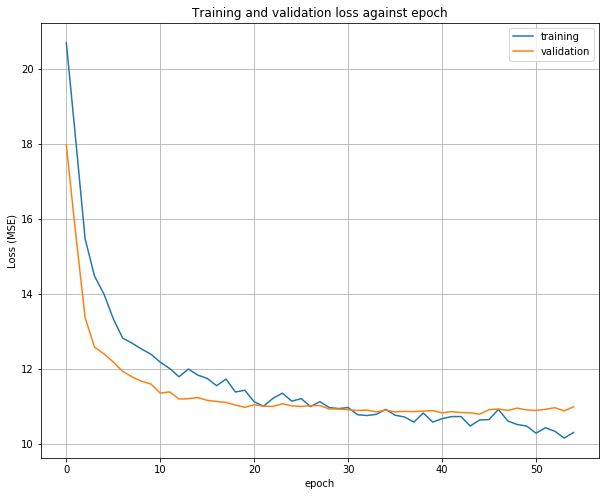

In [65]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.grid()
plt.title('Training and validation loss against epoch')
plt.xlabel('epoch')
plt.ylabel('Loss (MSE)')
plt.show()

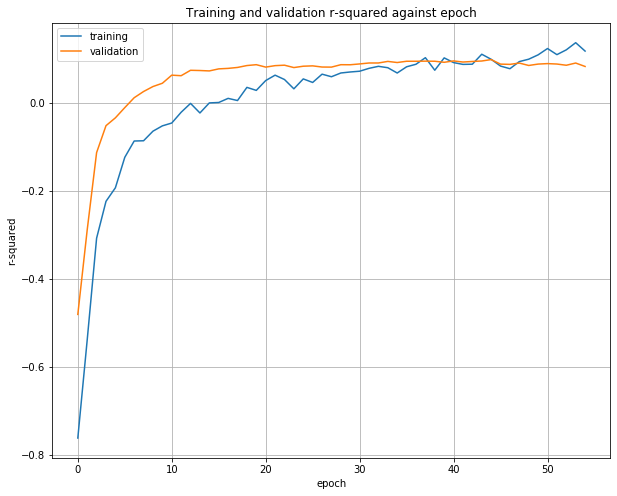

In [66]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['r_squared'], label='training')
plt.plot(history.history['val_r_squared'], label='validation')
plt.legend()
plt.grid()
plt.title('Training and validation r-squared against epoch')
plt.xlabel('epoch')
plt.ylabel('r-squared')
plt.show()

In [67]:
# get predictions for train set
y_pred_train = model.predict(X_train).flatten()

# calculate cross entropy loss for test set
train_loss = (
    mean_absolute_error(y_train, y_pred_train),
    mean_squared_error(y_train, y_pred_train),
    r2_score(y_train, y_pred_train)
)
train_loss

(2.2966103140005565, 9.983325833912431, 0.15591586477383856)

In [68]:
# get predictions for test set
y_pred_test = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (
    mean_absolute_error(y_test, y_pred_test),
    mean_squared_error(y_test, y_pred_test),
    r2_score(y_test, y_pred_test)
)
test_loss

(2.384738231779857, 10.78581941284516, 0.1096214336256599)

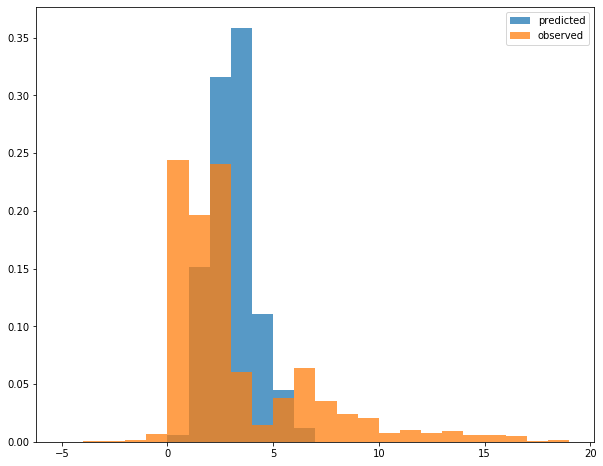

In [58]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred_test), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

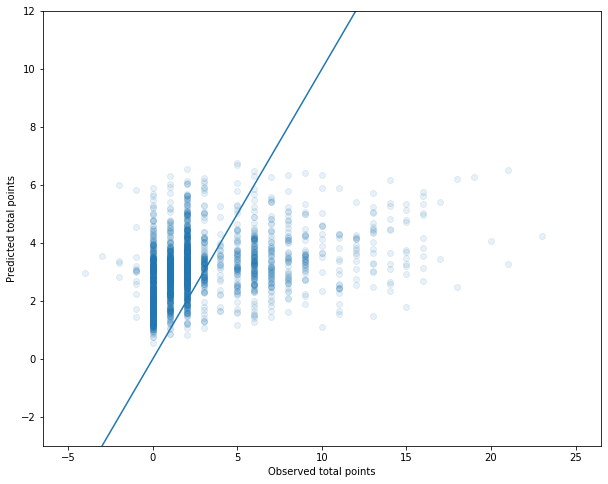

In [59]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred_test), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [60]:
print('test loss')
pd.DataFrame([
    ('XGBoost', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

test loss


,model,MAE,MSE,r2
0,XGBoost,2.48446,10.837983,0.105315


In [61]:
print('train loss')
pd.DataFrame([
    ('XGBoost', train_loss[0], train_loss[1], train_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

train loss


,model,MAE,MSE,r2
0,XGBoost,2.412876,10.052108,0.1501
